In [2]:
%matplotlib inline

In [2]:
!pip install arch


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\manue\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

rcParams['figure.figsize'] = 14,7
import warnings
warnings.filterwarnings('ignore')

Covid-19 epidemic was an important point for time series analysis, as it relies heavily on the use of time series to forecast and predict new cases, deaths, and ICU patients.

# Singapore Dataset

## Data overview

In [4]:
data = pd.read_csv('./Covid19_singapour.csv')
data

Date  Daily Confirmed  False Positives Found  \
0     2020-01-23              1.0                    NaN   
1     2020-01-24              2.0                    NaN   
2     2020-01-25              1.0                    NaN   
3     2020-01-26              0.0                    NaN   
4     2020-01-27              1.0                    NaN   
...          ...              ...                    ...   
1017  2022-11-05           2686.0                    NaN   
1018  2022-11-06           1893.0                    NaN   
1019  2022-11-07           1676.0                    NaN   
1020  2022-11-08              NaN                    NaN   
1021  2022-11-09              NaN                    NaN   

      Cumulative Confirmed  Daily Discharged  Passed but not due to COVID  \
0                      1.0               0.0                          0.0   
1                      3.0               0.0                          0.0   
2                      4.0               0.0                          0.0   
3                      4.0               0.0                          0.0   
4                      5.0               0.0                          0.0   
...                    ...               ...                          ...   
1017             2121435.0            4003.0                          NaN   
1018             2123328.0               NaN                          NaN   
1019             2125004.0               NaN                          NaN   
1020                   NaN               NaN                          NaN   
1021             2131554.0            1970.0                          NaN   

      Cumulative Discharged  Discharged to Isolation  Still Hospitalised  \
0                       0.0                      0.0                 1.0   
1                       0.0                      0.0                 3.0   
2                       0.0                      0.0                 4.0   
3                       0.0                      0.0                 4.0   
4                       0.0                      0.0                 5.0   
...                     ...                      ...                 ...   
1017                    NaN                      NaN                 NaN   
1018                    NaN                      NaN                 NaN   
1019                    NaN                      NaN                 NaN   
1020                    NaN                      NaN                 NaN   
1021                    NaN                      NaN                 NaN   

      Daily Deaths  ...  Cumulative Individuals Vaccinated  \
0              0.0  ...                                NaN   
1              0.0  ...                                NaN   
2              0.0  ...                                NaN   
3              0.0  ...                                NaN   
4              0.0  ...                                NaN   
...            ...  ...                                ...   
1017           1.0  ...                                NaN   
1018           1.0  ...                                NaN   
1019           3.0  ...                                NaN   
1020           1.0  ...                                NaN   
1021           2.0  ...                                NaN   

      Cumulative Individuals Vaccination Completed  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   
...                                            ...   
1017                                           NaN   
1018                                           NaN   
1019                                           NaN   
1020                                           NaN   
1021                                           NaN   

      Perc population completed at least one dose  \
0     

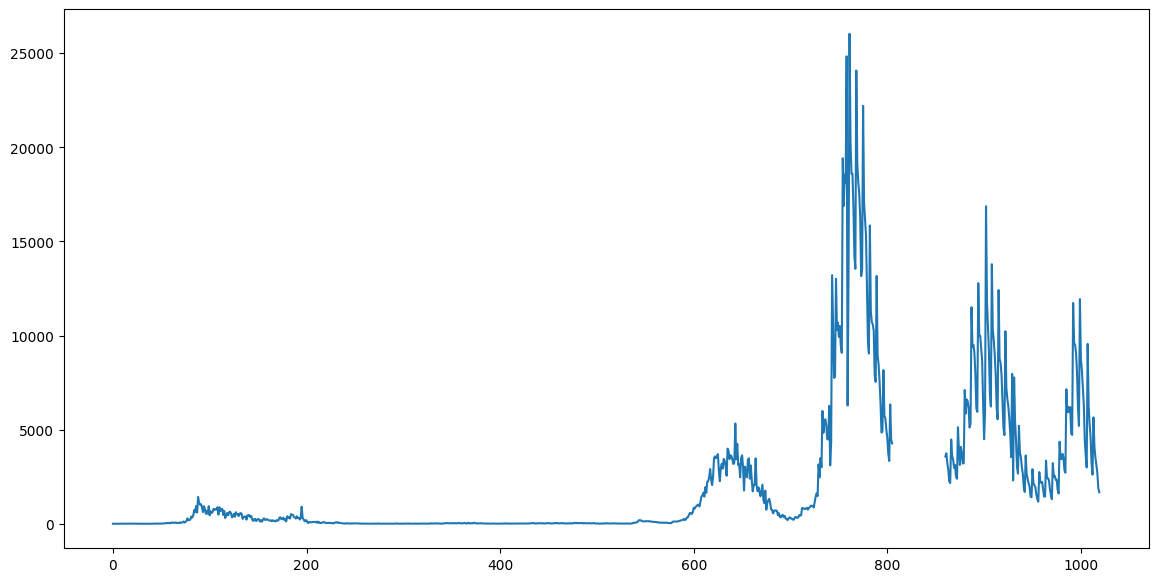

In [5]:
plt.plot(data["Daily Confirmed"].values)

In [6]:
data['Date']=pd.to_datetime(data['Date'], infer_datetime_format=True)
data = data.set_index('Date')

C:\Users\manue\AppData\Local\Temp\ipykernel_16496\3012526356.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Date']=pd.to_datetime(data['Date'], infer_datetime_format=True)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1022 entries, 2020-01-23 to 2022-11-09
Data columns (total 35 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Daily Confirmed                                                966 non-null    float64
 1   False Positives Found                                          697 non-null    float64
 2   Cumulative Confirmed                                           967 non-null    float64
 3   Daily Discharged                                               887 non-null    float64
 4   Passed but not due to COVID                                    806 non-null    float64
 5   Cumulative Discharged                                          790 non-null    float64
 6   Discharged to Isolation                                        792 non-null    float64
 7   Still Hospitalised                        

In [8]:
df = data.copy()

In [9]:
np.where(df.isna().values[:,0] == True)

(array([ 806,  807,  808,  809,  810,  811,  812,  813,  814,  815,  816,
         817,  818,  819,  820,  821,  822,  823,  824,  825,  826,  827,
         828,  829,  830,  831,  832,  833,  834,  835,  836,  837,  838,
         839,  840,  841,  842,  843,  844,  845,  846,  847,  848,  849,
         850,  851,  852,  853,  854,  855,  856,  857,  858,  859, 1020,
        1021], dtype=int64),)

In [10]:
df = df[:806]

In [11]:
np.where(df.isna().values[:,0] == True)

(array([], dtype=int64),)

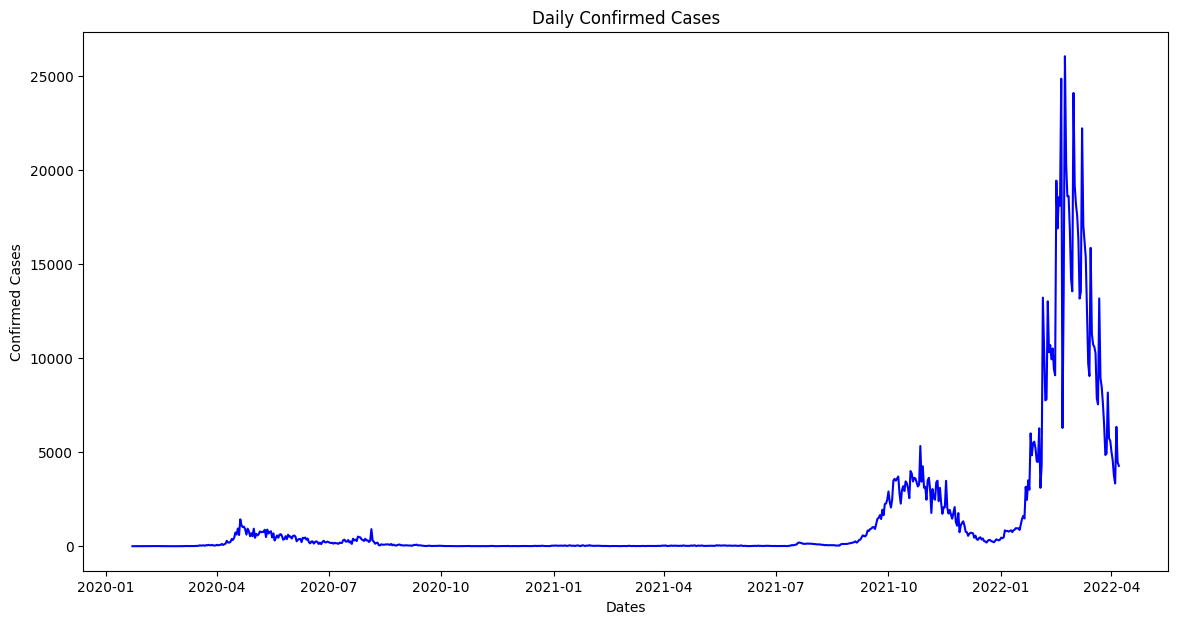

In [12]:
plt.xlabel('Dates')
plt.ylabel('Confirmed Cases')
plt.title('Daily Confirmed Cases')
plt.plot(df["Daily Confirmed"], color='b')

## Rolling Statistics

In [13]:
rolmean = df["Daily Confirmed"].rolling(window=3).mean()
rolstd = df["Daily Confirmed"].rolling(window=3).std()


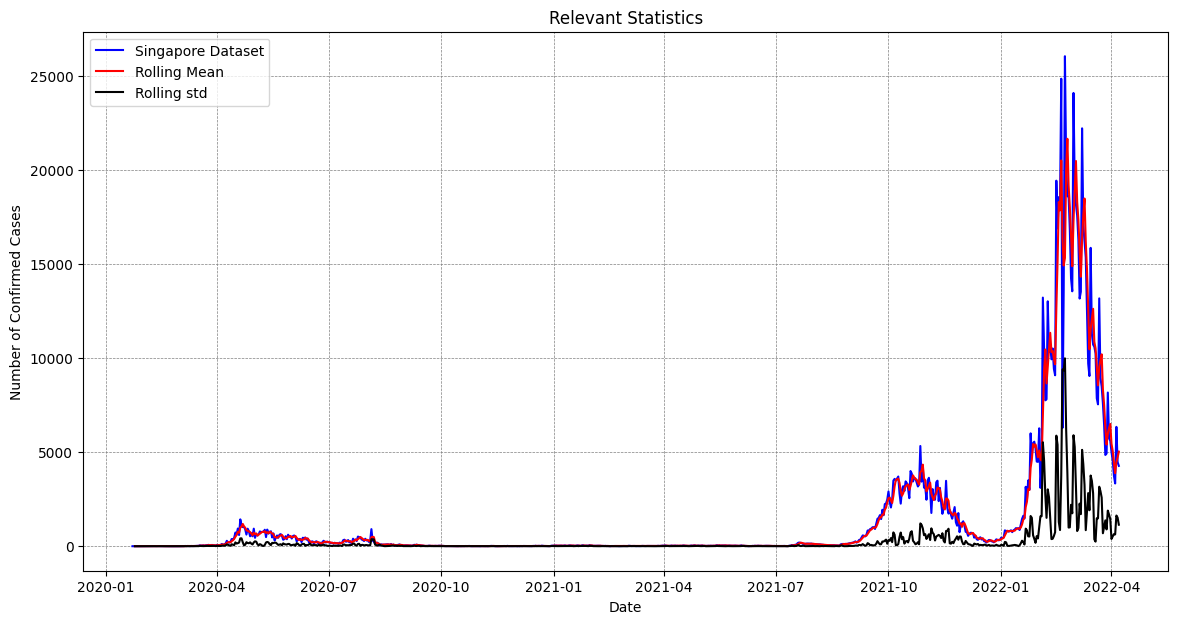

In [14]:
org = plt.plot(df["Daily Confirmed"], color='b', label='Singapore Dataset')
mean = plt.plot(rolmean, color='r', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling std')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend(loc='best')
plt.title('Relevant Statistics')
plt.ylabel("Number of Confirmed Cases")
plt.xlabel("Date")
plt.show(block=False)

In [15]:
print('Results of Dickey-Fuller Test')

dftest = adfuller(df["Daily Confirmed"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p value','#Lags used', 'No:of observations found'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test
Test Statistic               -4.724549
p value                       0.000076
#Lags used                   15.000000
No:of observations found    790.000000
Critical Value (1%)          -3.438655
Critical Value (5%)          -2.865205
Critical Value (10%)         -2.568722
dtype: float64


We can see that the data is stationary as the p value is less than 0.05

In [16]:
arma_order_select_ic(df["Daily Confirmed"])

C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'bic':               0             1             2
 0  20097.676297  14796.482995  14436.103013
 1  13855.113566  13651.113782  13650.911624
 2  13782.240409  13654.287518  13642.802781
 3  13647.047103  13622.736828  13628.561207
 4  13628.530628  13631.906234  13525.767030,
 'bic_min_order': (4, 2)}

## ARIMA Model

Plotting ARIMA Model


C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCac

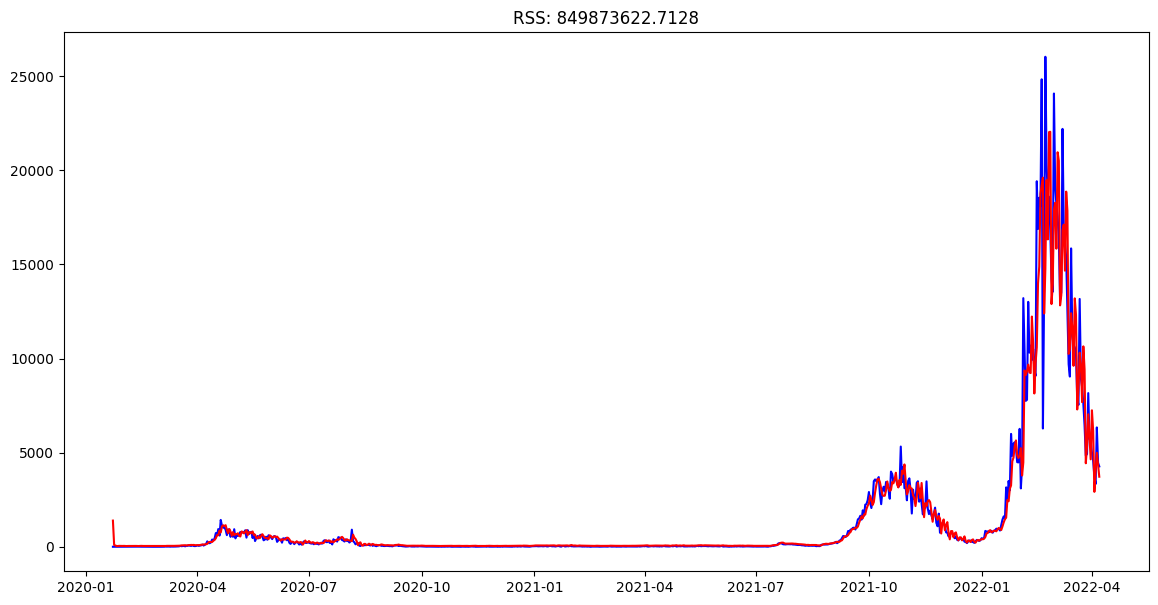

In [17]:
# ARIMA Model

print('Plotting ARIMA Model')
model = ARIMA(df["Daily Confirmed"], order=(4,0,2))
results_ARIMA = model.fit()
plt.plot(df["Daily Confirmed"],color='b')
plt.plot(results_ARIMA.fittedvalues, color='r')
plt.title('RSS: {:1.4f}'.format(sum((results_ARIMA.fittedvalues-df['Daily Confirmed'])**2)))
plt.show()

In [80]:
def test_residuals(residuals, lags=20):
    # Ljung-Box test
    ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(ljung_box_result)
    fig, axs = plt.subplots(2,2,figsize=(14, 10))
    for ax in axs.flatten():
        ax.grid(color='gray', linestyle='--', linewidth=0.5)
    # Plot residuals
    axs[0,0].plot(residuals)
    axs[0,0].set_title('Residuals')

    # Plot histogram of residuals
    axs[1,0].hist(residuals, bins=20)
    axs[1,0].set_title('Histogram of Residuals')

    # ACF plot
    plot_acf(residuals, ax=axs[0,1], lags=lags)
    
    # PACF plot
    plot_pacf(residuals,ax=axs[1,1], lags=lags)
    plt.tight_layout()
    plt.show()



In [19]:
residuals = results_ARIMA.resid
test_residuals(residuals, label="")

TypeError: test_residuals() got an unexpected keyword argument 'label'

The model may still not be a good fit, as the p-value is very low.

Predictions

In [ ]:
pred_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
pred_ARIMA = pred_ARIMA_diff.to_frame()
pred_ARIMA.tail()

0
Date                   
2022-04-03  2917.335548
2022-04-04  4070.087299
2022-04-05  4992.590783
2022-04-06  4354.353807
2022-04-07  3721.912418

Plotting ARIMA Model


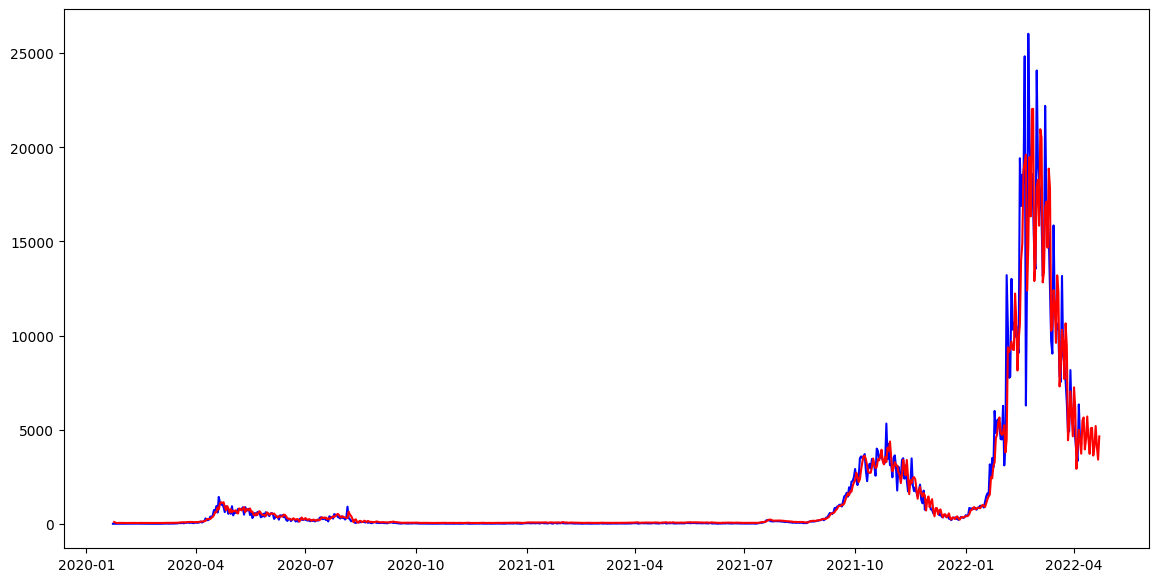

In [ ]:
# predictions for the next 14 days
predictions = results_ARIMA.predict(1, len(df)+14)
print('Plotting ARIMA Model')
plt.plot(df["Daily Confirmed"],color='b')
plt.plot(predictions, color='r')
plt.show()

In [ ]:
fc=results_ARIMA.forecast(steps=14)
forecast = fc.values
forecast

array([5483.03255065, 5648.84873972, 3951.33901136, 4501.72583603,
       5699.56460604, 4506.10645367, 3711.68495613, 5077.23564811,
       5099.782999  , 3624.12018151, 4114.28161674, 5193.75362852,
       4108.13746258, 3408.6008327 ])

In [ ]:
df.tail()

Daily Confirmed  False Positives Found  Cumulative Confirmed  \
Date                                                                       
2022-04-03           3743.0                    0.0             1109744.0   
2022-04-04           3334.0                    0.0             1113078.0   
2022-04-05           6341.0                    0.0             1119419.0   
2022-04-06           4467.0                    0.0             1123886.0   
2022-04-07           4269.0                    0.0             1128155.0   

            Daily Discharged  Passed but not due to COVID  \
Date                                                        
2022-04-03            5612.0                          0.0   
2022-04-04            5155.0                          0.0   
2022-04-05            4644.0                          0.0   
2022-04-06            3918.0                          0.0   
2022-04-07            3595.0                          0.0   

            Cumulative Discharged  Discharged to Isolation  \
Date                                                         
2022-04-03                    NaN                      NaN   
2022-04-04                    NaN                      NaN   
2022-04-05                    NaN                      NaN   
2022-04-06                    NaN                      NaN   
2022-04-07                    NaN                      NaN   

            Still Hospitalised  Daily Deaths  Cumulative Deaths  ...  \
Date                                                             ...   
2022-04-03                 NaN           4.0             1276.0  ...   
2022-04-04                 NaN           7.0             1283.0  ...   
2022-04-05                 NaN           1.0             1284.0  ...   
2022-04-06                 NaN           3.0             1287.0  ...   
2022-04-07                 NaN           3.0             1290.0  ...   

            Cumulative Individuals Vaccinated  \
Date                                            
2022-04-03                                NaN   
2022-04-04                                NaN   
2022-04-05                                NaN   
2022-04-06                                NaN   
2022-04-07                                NaN   

            Cumulative Individuals Vaccination Completed  \
Date                                                       
2022-04-03                                           NaN   
2022-04-04                                           NaN   
2022-04-05                                           NaN   
2022-04-06                                           NaN   
2022-04-07                                           NaN   

            Perc population completed at least one dose  \
Date                                                      
2022-04-03                                           93   
2022-04-04                                           93   
2022-04-05                                           93   
2022-04-06                                           93   
2022-04-07                                           93   

            Perc population completed vaccination  Sinovac vaccine doses  \
Date                                                                       
2022-04-03                                     92                    NaN   
2022-04-04                                     92                    NaN   
2022-04-05                                     92                    NaN   
2022-04-06                                     92                    NaN   
2022-04-07                                     92                    NaN   

            Cumulative individuals using Sinovac vaccine  \
Date                                                       
2022-04-03                                           NaN   
2022-04-04                                           NaN   
2022-04-05                                           NaN   
2022-04-06                                           NaN   
2022-04-07                             

In [ ]:
# forecast dataframe
forecast_df = pd.DataFrame({'Date':pd.date_range('2022-04-08','2022-04-21'), # 2 weeks
                           'Confirmed':forecast}) 

# set datatype to datetime format
forecast_df['Date']=pd.to_datetime(forecast_df['Date'], infer_datetime_format=True)

# set Date column as index
forecast_df = forecast_df.set_index('Date')

In [ ]:
forecast_df

Confirmed
Date                   
2022-04-08  5483.032551
2022-04-09  5648.848740
2022-04-10  3951.339011
2022-04-11  4501.725836
2022-04-12  5699.564606
2022-04-13  4506.106454
2022-04-14  3711.684956
2022-04-15  5077.235648
2022-04-16  5099.782999
2022-04-17  3624.120182
2022-04-18  4114.281617
2022-04-19  5193.753629
2022-04-20  4108.137463
2022-04-21  3408.600833

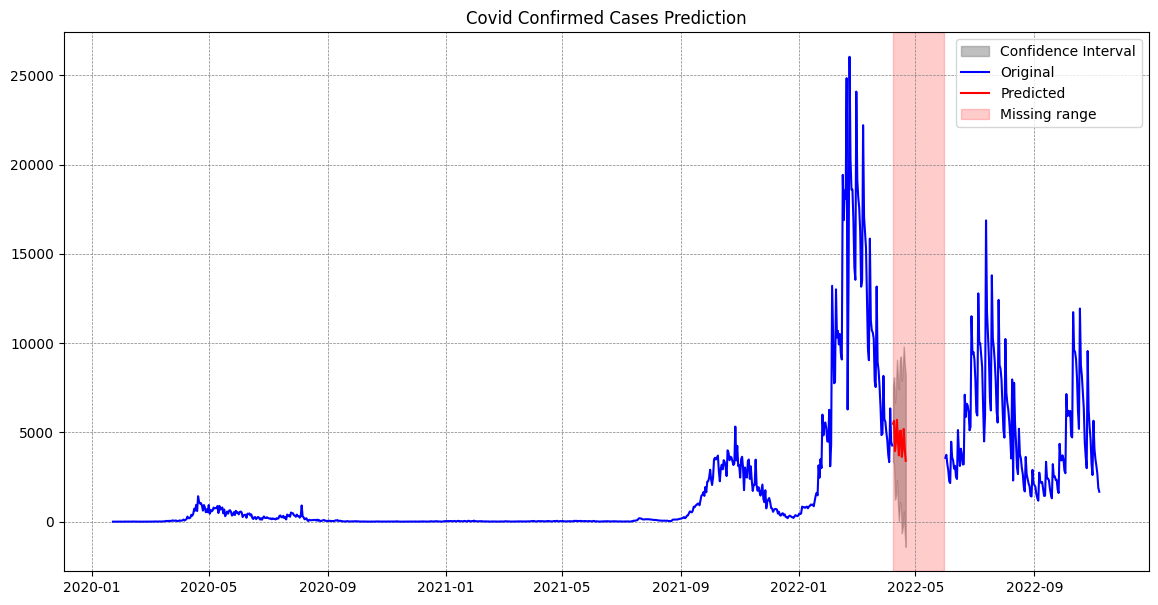

In [ ]:
# Prediction Plotting
pred = results_ARIMA.get_forecast(steps=14)
pred_ci = pred.conf_int().values
lower_ci = pred_ci[:, 0]
upper_ci = pred_ci[:, 1]
date_range = pd.date_range(start="2022-04-08", periods=14)

plt.fill_between(date_range, lower_ci, upper_ci, color='gray', alpha=0.5, label='Confidence Interval')
orgi = plt.plot(df["Daily Confirmed"], color='b', label='Original')
predi = plt.plot(forecast_df, color='r', label='Predicted')
restdata = plt.plot(data[806:]["Daily Confirmed"], color='b')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.axvspan("2022-04-08", "2022-05-31", color="red", alpha=0.2, label="Missing range")
plt.legend(loc='best')
plt.title('Covid Confirmed Cases Prediction')
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.show(block=False)

What if we try to predict the fully missing 54 values?

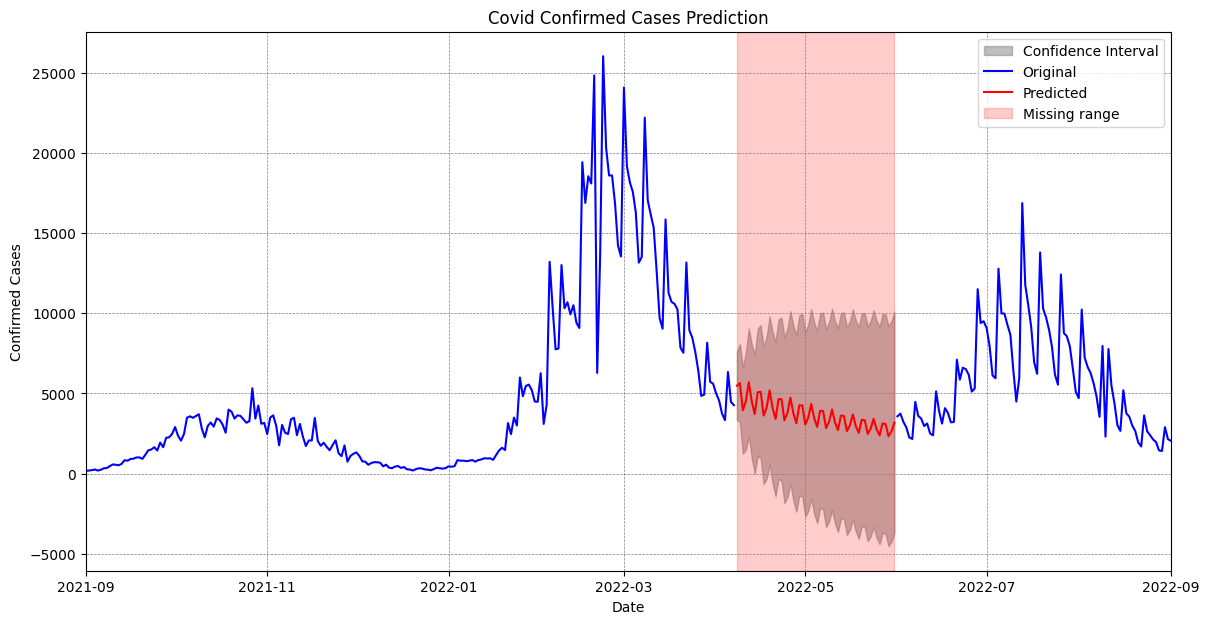

In [22]:
fc=results_ARIMA.forecast(steps=54)
forecast = fc.values
pred = results_ARIMA.get_forecast(steps=54)
pred_ci = pred.conf_int().values
lower_ci = pred_ci[:, 0]
upper_ci = pred_ci[:, 1]
date_range = pd.date_range(start="2022-04-08", periods=54)
fig, ax = plt.subplots()
# Prediction Plotting
ax.fill_between(date_range, lower_ci, upper_ci, color='gray', alpha=0.5, label='Confidence Interval')
ax.plot(df["Daily Confirmed"], color='b', label='Original')
ax.plot(pd.date_range(start='2022-04-08',periods=54), forecast, color='r', label='Predicted')
ax.plot(pd.date_range(start='2022-04-08', periods=216), data[806:]["Daily Confirmed"], color='b')
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.axvspan("2022-04-08", "2022-05-31", color="red", alpha=0.2, label="Missing range")
ax.legend(loc='best')
ax.set_title('Covid Confirmed Cases Prediction')
ax.set_xlim(pd.to_datetime("2021-09-01"), pd.to_datetime("2022-09-01"))
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.show(block=False)

It seems to be a good fit, qualitatively, but as we saw before it may not be a good fit as the residuals are not IID noise.

Let's try averaging last 7 days

In [24]:
daily_data = pd.DataFrame(df["Daily Confirmed"])
weekly_data = daily_data.rolling(window=7).mean()
weekly_data = weekly_data.dropna()
weekly_data

Daily Confirmed
Date                       
2020-01-29         1.428571
2020-01-30         1.714286
2020-01-31         1.857143
2020-02-01         2.000000
2020-02-02         2.000000
...                     ...
2022-04-03      5391.285714
2022-04-04      5164.000000
2022-04-05      4903.571429
2022-04-06      4723.285714
2022-04-07      4532.428571

[800 rows x 1 columns]

Plotting ARIMA Model


C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


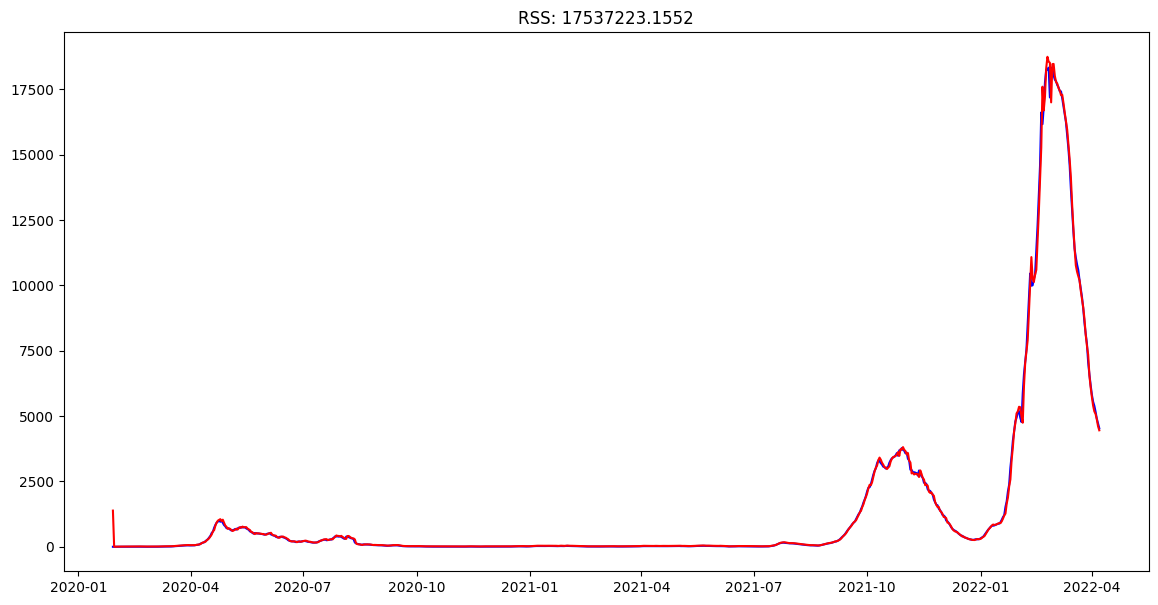

In [25]:
print('Plotting ARIMA Model')
model = ARIMA(weekly_data["Daily Confirmed"], order=(4,0,2))
results_ARIMA = model.fit()
plt.plot(weekly_data["Daily Confirmed"],color='b')
plt.plot(results_ARIMA.fittedvalues, color='r')
plt.title('RSS: {:1.4f}'.format(sum((results_ARIMA.fittedvalues-weekly_data['Daily Confirmed'])**2)))
plt.show()

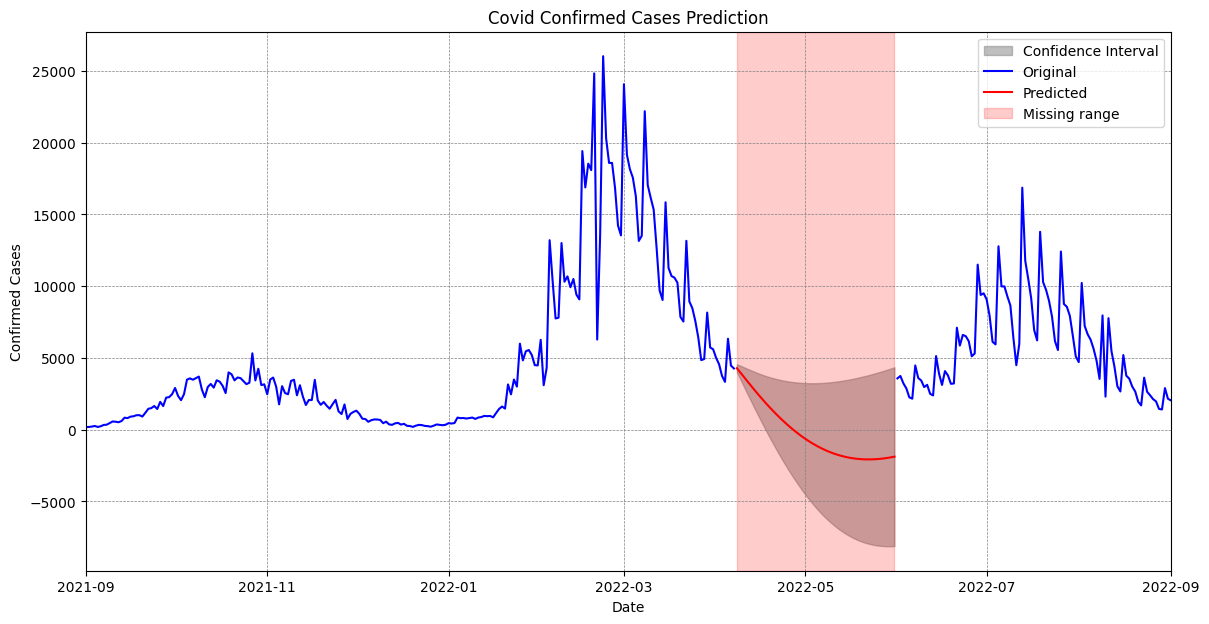

In [26]:
fc=results_ARIMA.forecast(steps=54)
forecast = fc.values
pred = results_ARIMA.get_forecast(steps=54)
pred_ci = pred.conf_int().values
lower_ci = pred_ci[:, 0]
upper_ci = pred_ci[:, 1]
date_range = pd.date_range(start="2022-04-08", periods=54)
fig, ax = plt.subplots()
# Prediction Plotting
ax.fill_between(date_range, lower_ci, upper_ci, color='gray', alpha=0.5, label='Confidence Interval')
ax.plot(df["Daily Confirmed"], color='b', label='Original')
ax.plot(pd.date_range(start='2022-04-08',periods=54), forecast, color='r', label='Predicted')
ax.plot(pd.date_range(start='2022-04-08', periods=216), data[806:]["Daily Confirmed"], color='b')
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.axvspan("2022-04-08", "2022-05-31", color="red", alpha=0.2, label="Missing range")
ax.legend(loc='best')
ax.set_title('Covid Confirmed Cases Prediction')
ax.set_xlim(pd.to_datetime("2021-09-01"), pd.to_datetime("2022-09-01"))
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.show(block=False)

----

In [127]:
time = np.arange(806)
time_with_const = sm.add_constant(time) 
model = sm.OLS(df["Daily Confirmed"].values, time_with_const)
results = model.fit()

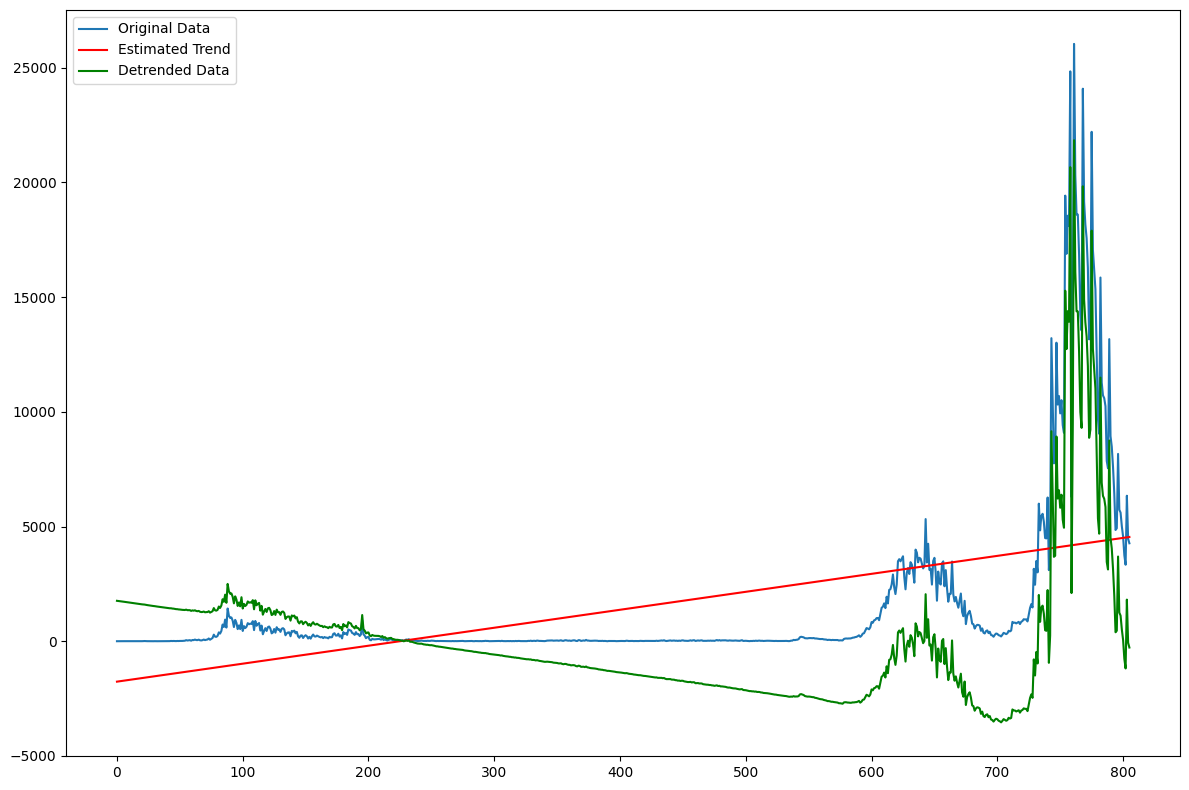

In [130]:

# Extract the trend
trend = results.fittedvalues

# Detrend the time series
detrended = df["Daily Confirmed"] - trend

# Plot the original data, trend, and detrended data
plt.figure(figsize=(12, 8))

plt.plot(time, df["Daily Confirmed"], label='Original Data')

plt.plot(time, trend, label='Estimated Trend', color='red')

plt.plot(time, detrended, label='Detrended Data', color='green')
plt.legend()

plt.tight_layout()
plt.show()

Plotting ARIMA Model


C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCac

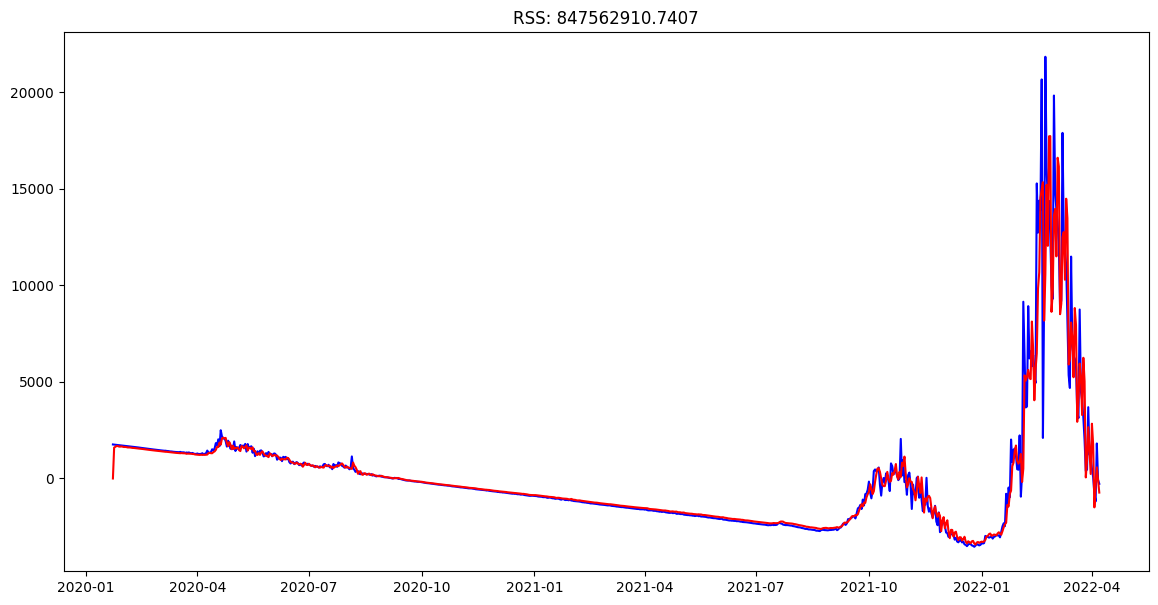

In [132]:

print('Plotting ARIMA Model')
model = ARIMA(detrended, order=(4,0,2))
results_ARIMA = model.fit()
plt.plot(detrended,color='b')
plt.plot(results_ARIMA.fittedvalues, color='r')
plt.title('RSS: {:1.4f}'.format(sum((results_ARIMA.fittedvalues-detrended)**2)))
plt.show()

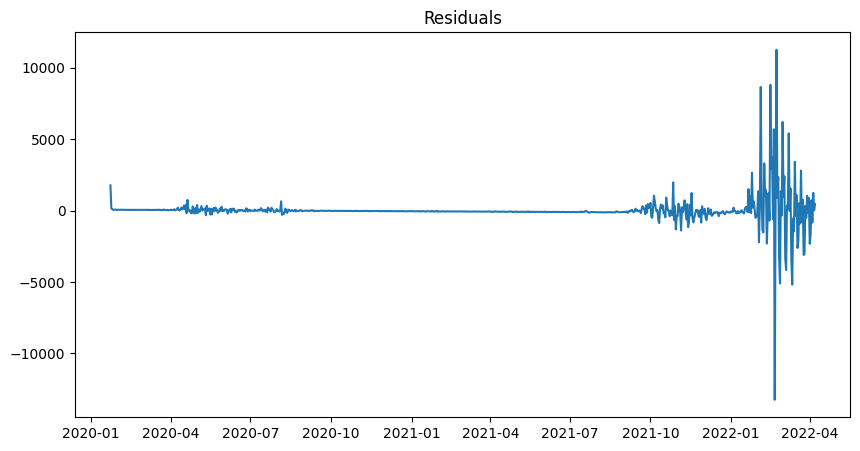

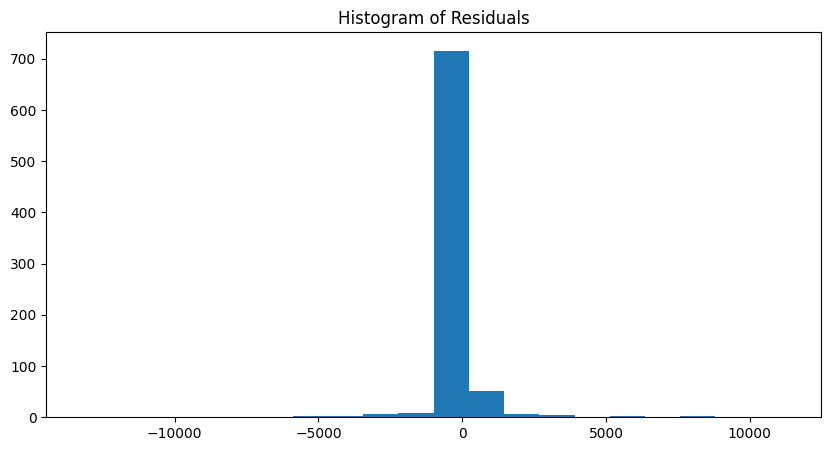

       lb_stat     lb_pvalue
10  269.241819  4.831927e-52


In [134]:
residuals = results_ARIMA.resid
# Plot residuals
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.show()

# Ljung-Box test
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_result)


There is no actual effect with or without the linear trend.

## ARFIMA

Plotting ARFIMA Model


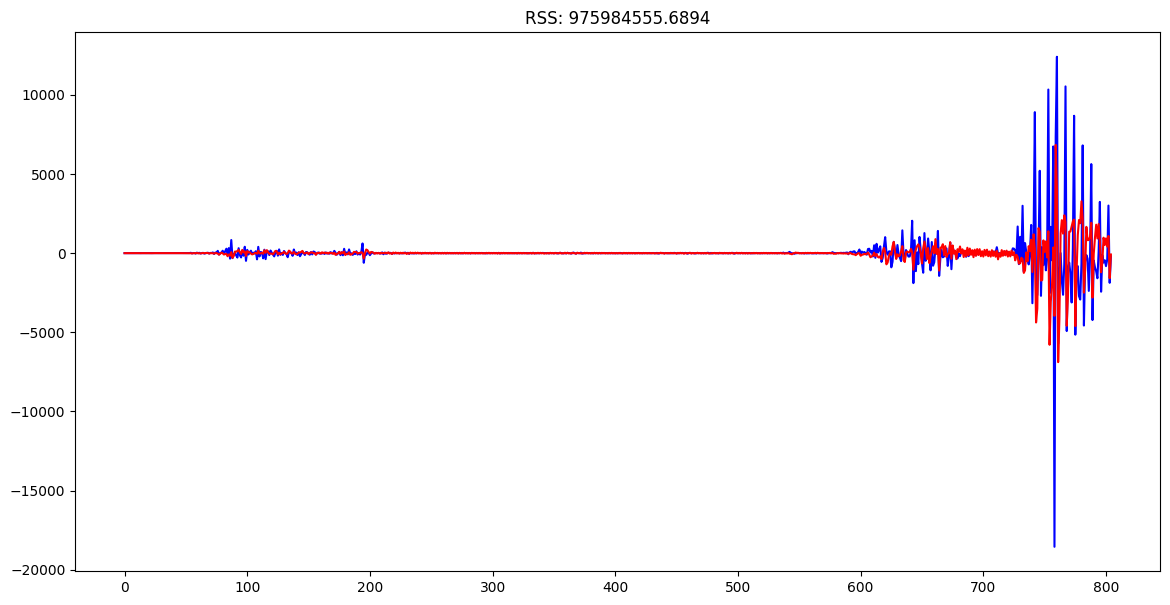

In [488]:
print('Plotting ARFIMA Model')
model = ARIMA(np.diff(df["Daily Confirmed"]), order=(4,1.0,2))
results_ARFIMA = model.fit()
plt.plot(np.diff(df["Daily Confirmed"]),color='b')
plt.plot(results_ARFIMA.fittedvalues, color='r')
plt.title('RSS: {:1.4f}'.format(sum((results_ARFIMA.fittedvalues-np.diff(df["Daily Confirmed"]))**2)))
plt.show()

       lb_stat     lb_pvalue
10  304.061787  2.151985e-59


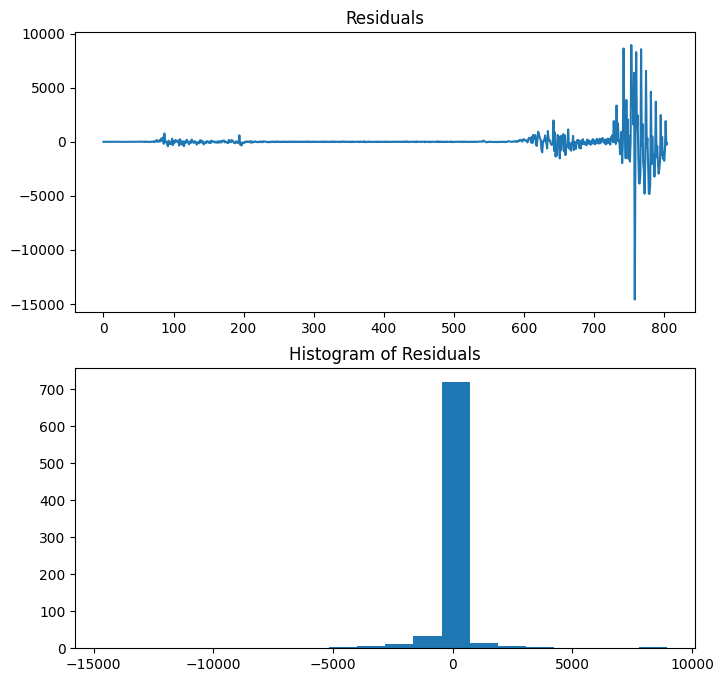

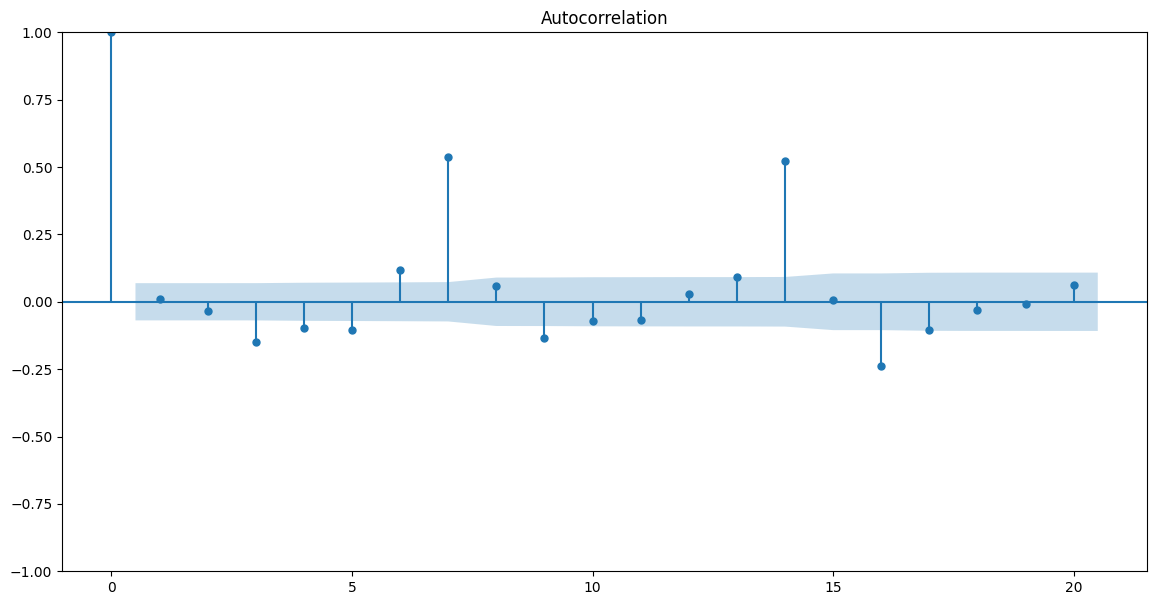

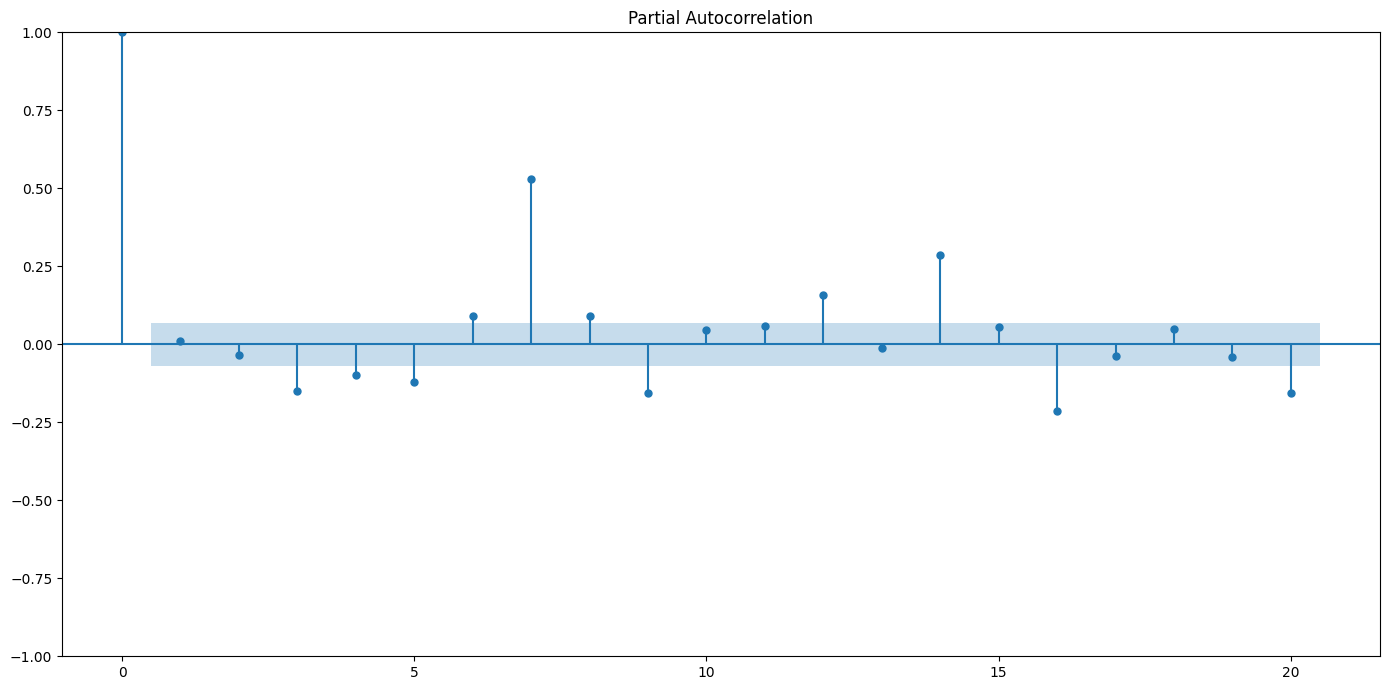

In [489]:
residuals = results_ARFIMA.resid
test_residuals(residuals)

This is still not a good fit as the p-value is too low.

## GARCH

In [224]:
garch_data = np.diff(np.log(df["Daily Confirmed"]))
garch_data = garch_data[~np.isnan(garch_data)]
garch_data = garch_data[np.isfinite(garch_data)]

model = arch_model(garch_data, vol='Garch', p=1, q=1)
fitted_model = model.fit(disp='off')
print(fitted_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -438.123
Distribution:                  Normal   AIC:                           884.245
Method:            Maximum Likelihood   BIC:                           902.974
                                        No. Observations:                  798
Date:                Thu, Jun 13 2024   Df Residuals:                      797
Time:                        12:26:24   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0164  1.514e-02      1.083      0.279 

C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


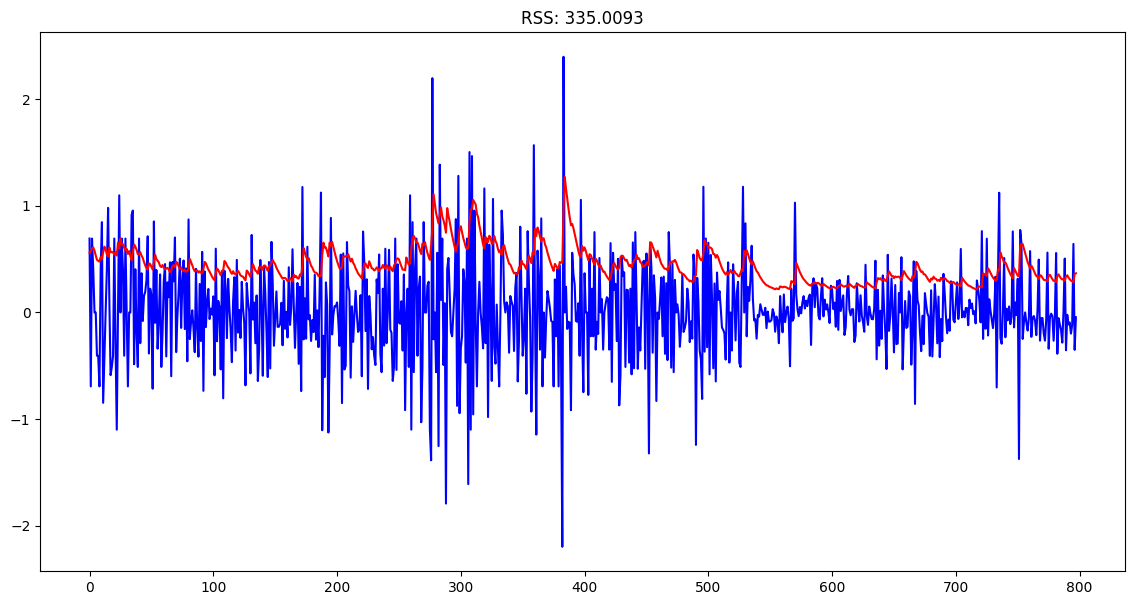

In [229]:
plt.plot(garch_data,color='b')
plt.plot(fitted_model.conditional_volatility, color='r')
plt.title('RSS: {:1.4f}'.format(sum((fitted_model.conditional_volatility-garch_data)**2)))
plt.show()

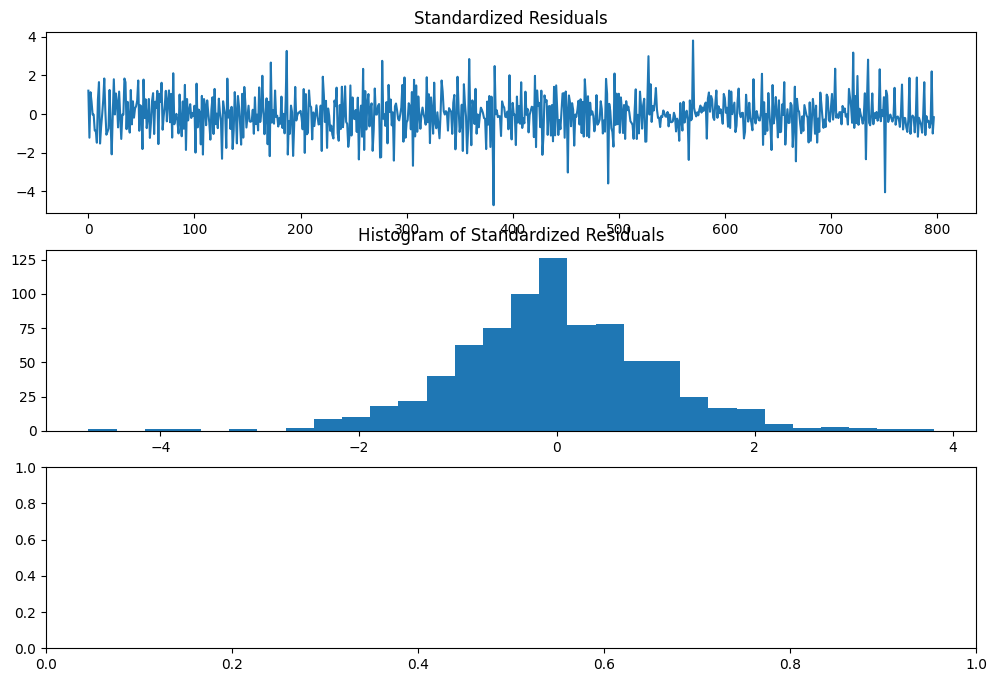

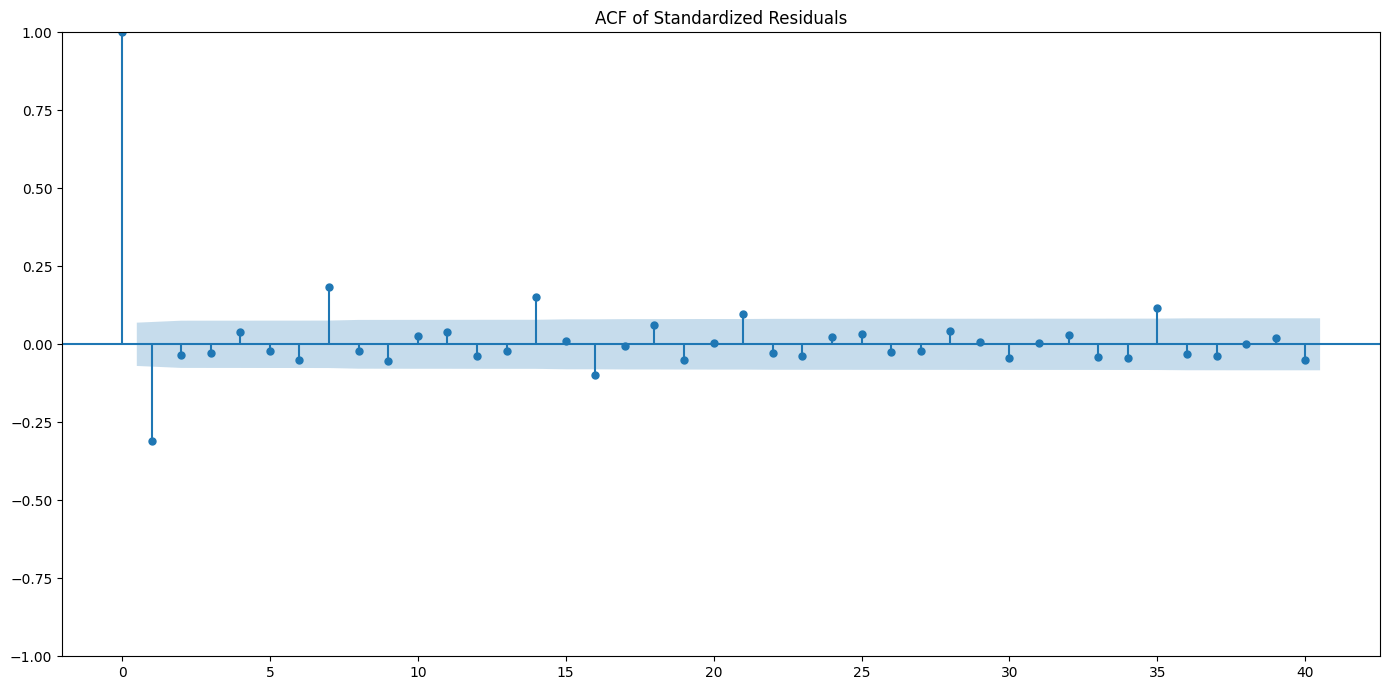

Ljung-Box test on standardized residuals:
        lb_stat     lb_pvalue
10  112.057379  2.051309e-19
20  147.209988  2.147319e-21
Ljung-Box test on standardized squared residuals:
       lb_stat  lb_pvalue
10  15.292763   0.121747
20  26.798413   0.141031


In [230]:
# Standardized residuals
residuals = fitted_model.resid / fitted_model.conditional_volatility

plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(residuals)
plt.title('Standardized Residuals')

plt.subplot(312)
plt.hist(residuals, bins=30)
plt.title('Histogram of Standardized Residuals')

plt.subplot(313)
plot_acf(residuals, lags=40)
plt.title('ACF of Standardized Residuals')

plt.tight_layout()
plt.show()

lb_resid = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
lb_squared_resid = acorr_ljungbox(residuals**2, lags=[10, 20], return_df=True)
print('Ljung-Box test on standardized residuals:\n', lb_resid)
print('Ljung-Box test on standardized squared residuals:\n', lb_squared_resid)

In [167]:
def fit_garch_model(data, p, q):
    model = arch_model(data, vol='Garch', p=p, q=q)
    fitted_model = model.fit(disp='off')
    return fitted_model

best_aic = np.inf
best_bic = np.inf
best_model = None

for p in range(1, 4):
    for q in range(1, 4):
        try:
            fitted_model = fit_garch_model(garch_data, p, q)
            print(f'GARCH({p},{q}) - AIC: {fitted_model.aic}, BIC: {fitted_model.bic}')
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_bic = fitted_model.bic
                best_model = fitted_model
        except:
            continue

print('Best Model based on AIC:')
print(best_model.summary())

GARCH(1,1) - AIC: 2413.4369355202666, BIC: 2432.205270490293
GARCH(1,2) - AIC: 2415.4197292857225, BIC: 2438.880147998256
GARCH(1,3) - AIC: 2365.3556072259935, BIC: 2393.508109681033
GARCH(2,1) - AIC: 2515.0577113065992, BIC: 2538.5181300191325
GARCH(2,2) - AIC: 2377.4248227267262, BIC: 2405.577325181766
GARCH(2,3) - AIC: 2361.7413672176604, BIC: 2394.585953415207
GARCH(3,1) - AIC: 2377.424373706177, BIC: 2405.5768761612167
GARCH(3,2) - AIC: 2347.6190704577734, BIC: 2380.46365665532
GARCH(3,3) - AIC: 2349.619093541396, BIC: 2387.155763481449
Best Model based on AIC:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:        Daily Confirmed   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1166.81
Distribution:                  Normal   AIC:                           2347.62
Method:            Maximum Likel

C:\Users\manue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


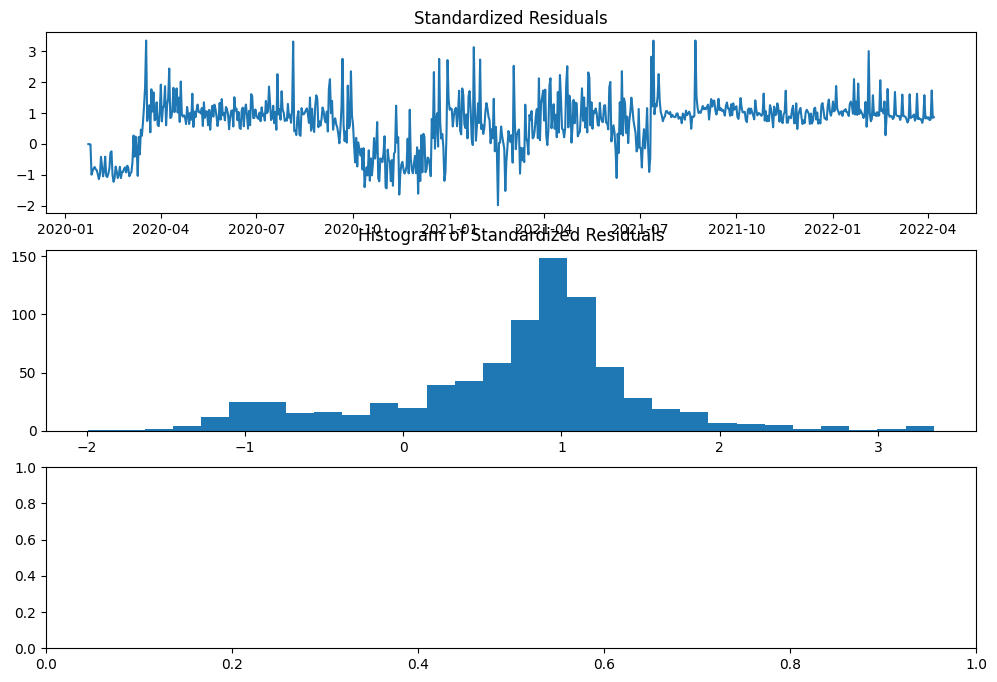

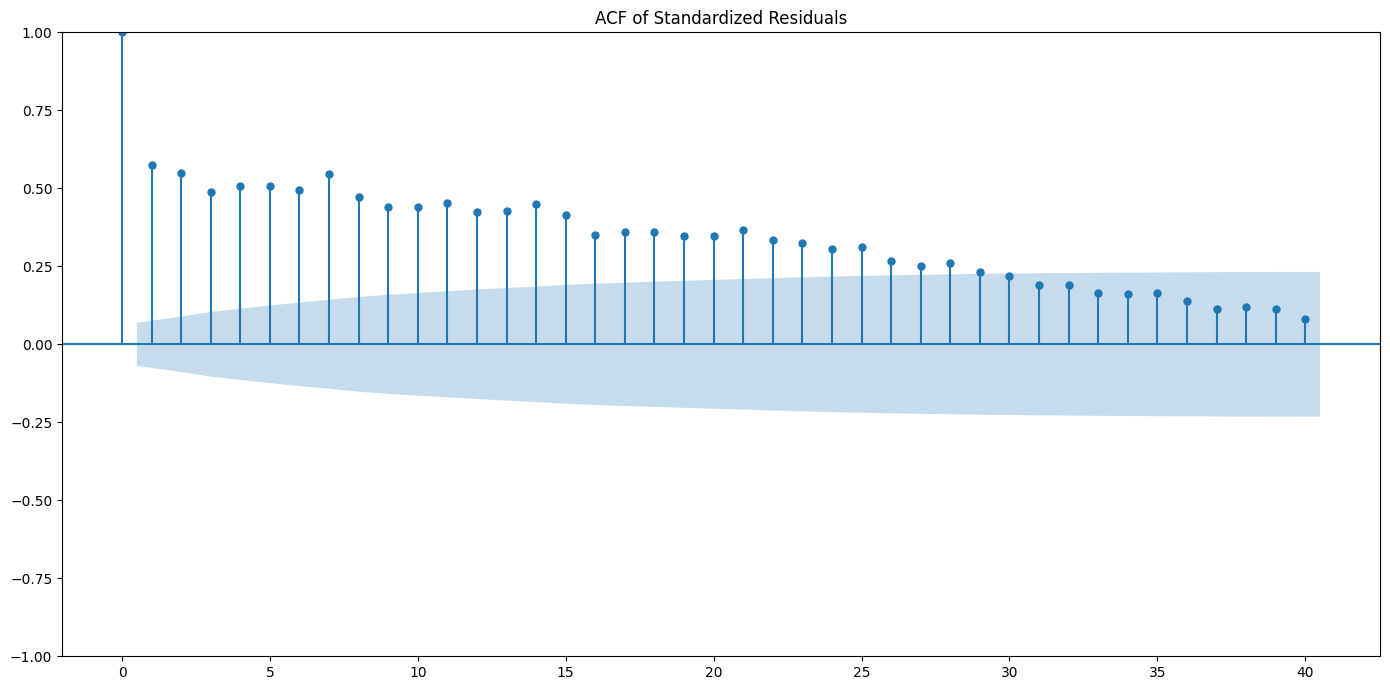

Ljung-Box test on standardized residuals:
         lb_stat  lb_pvalue
10  2059.963671        0.0
20  3346.326078        0.0
Ljung-Box test on standardized squared residuals:
       lb_stat  lb_pvalue
10  13.001199   0.223605
20  22.236415   0.327821


In [231]:
# Standardized residuals
residuals = best_model.resid / best_model.conditional_volatility

plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(residuals)
plt.title('Standardized Residuals')

plt.subplot(312)
plt.hist(residuals, bins=30)
plt.title('Histogram of Standardized Residuals')

plt.subplot(313)
plot_acf(residuals, lags=40)
plt.title('ACF of Standardized Residuals')

plt.tight_layout()
plt.show()

lb_resid = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
lb_squared_resid = acorr_ljungbox(residuals**2, lags=[10, 20], return_df=True)
print('Ljung-Box test on standardized residuals:\n', lb_resid)
print('Ljung-Box test on standardized squared residuals:\n', lb_squared_resid)

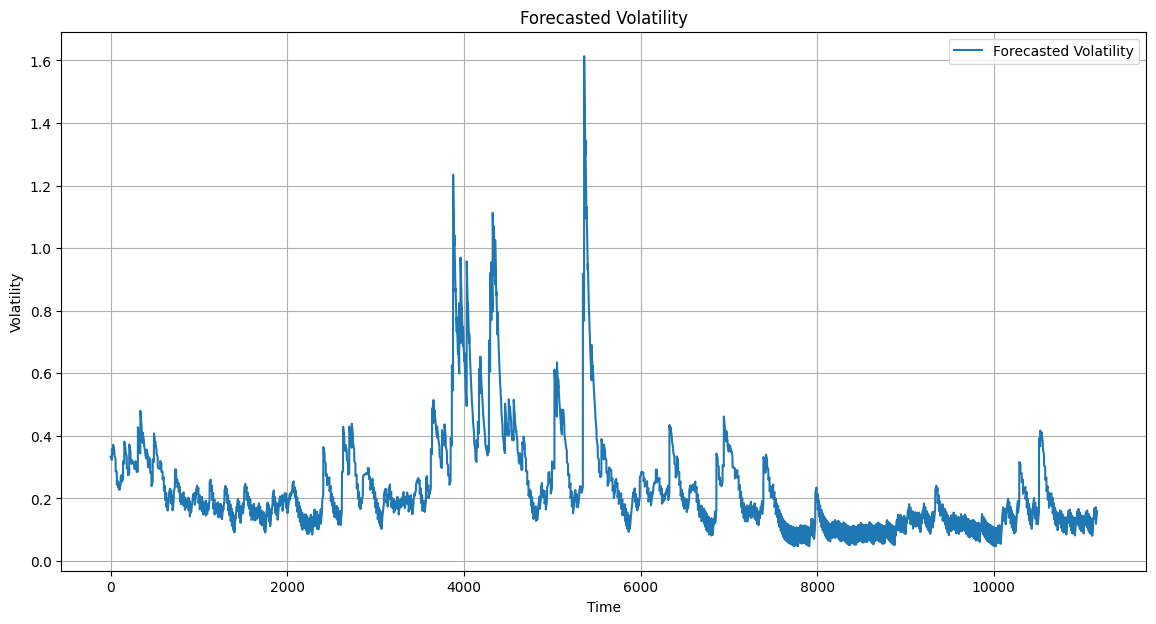

In [251]:
# Forecast the next 14 steps
forecast = fitted_model.forecast(start=0, horizon=14)
forecast_volatility = forecast.variance.dropna().values.flatten()
# Plot the forecasted volatility
plt.plot(forecast_volatility, label="Forecasted Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.title("Forecasted Volatility")
plt.legend()
plt.grid(True)

plt.show()

In [233]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(fitted_model.conditional_volatility - garch_data))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((fitted_model.conditional_volatility - garch_data) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.5117450591317969
Root Mean Squared Error (RMSE): 0.6479283698612747


The GARCH model seem to properly model the volatility of the time series as they have low errors, it seems that the data the next 14 days isn't going to fluctuate too much over time.

## LSTMs

In [257]:
data_lstm = df["Daily Confirmed"].values
data_lstm = data_lstm.reshape(-1, 1)
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_lstm)

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)



Epoch 1/20
17/17 [==============================] - 3s 45ms/step - loss: 7.1524e-05 - val_loss: 0.0038
Epoch 2/20
17/17 [==============================] - 0s 17ms/step - loss: 2.2012e-05 - val_loss: 8.4633e-04
Epoch 3/20
17/17 [==============================] - 0s 17ms/step - loss: 2.0071e-05 - val_loss: 9.6994e-04
Epoch 4/20
17/17 [==============================] - 0s 17ms/step - loss: 1.6020e-05 - val_loss: 8.2982e-04
Epoch 5/20
17/17 [==============================] - 0s 16ms/step - loss: 1.4501e-05 - val_loss: 7.5028e-04
Epoch 6/20
17/17 [==============================] - 0s 16ms/step - loss: 1.4387e-05 - val_loss: 8.0618e-04
Epoch 7/20
17/17 [==============================] - 0s 16ms/step - loss: 1.3943e-05 - val_loss: 6.1916e-04
Epoch 8/20
17/17 [==============================] - 0s 16ms/step - loss: 1.3717e-05 - val_loss: 7.0716e-04
Epoch 9/20
17/17 [==============================] - 0s 16ms/step - loss: 1.4078e-05 - val_loss: 5.4752e-04
Epoch 10/20
17/17 [======================

1/1 [==============================] - 0s 14ms/step


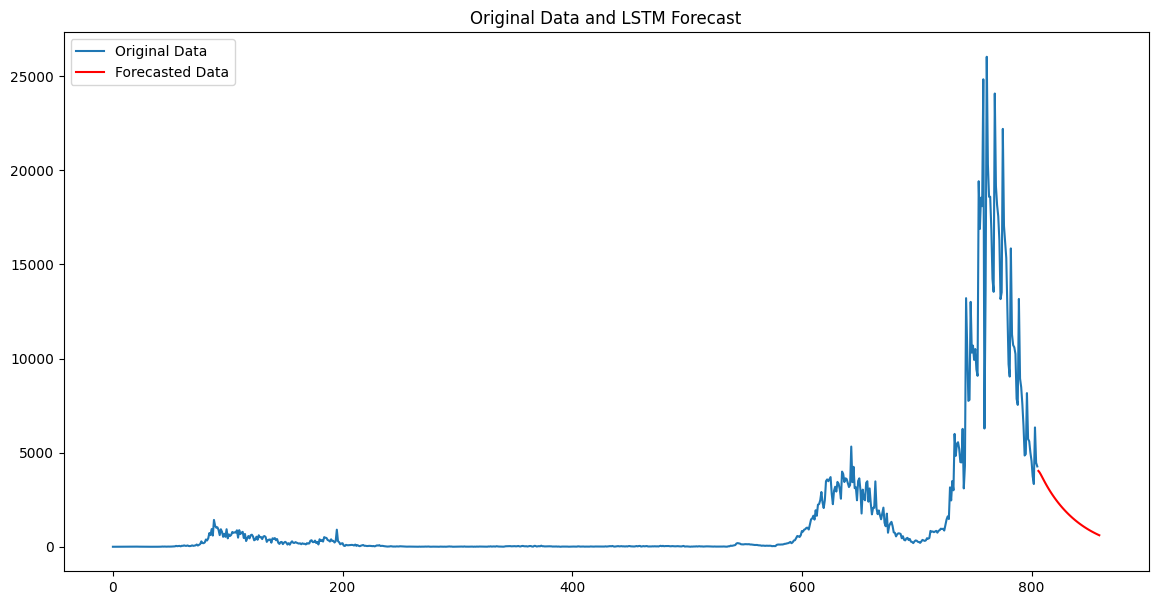

In [259]:
# Forecast the next 14 steps
predicted = []
last_sequence = X_test[-1]

for _ in range(54):
    next_pred = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    predicted.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(seq_length, 1)

# Inverse transform the predicted values
predicted = scaler.inverse_transform(np.array(predicted).reshape(-1, 1))

# Plot the results
plt.plot(data_lstm, label='Original Data')
plt.plot(range(len(data_lstm), len(data_lstm) + 54), predicted, label='Forecasted Data', color='red')
plt.title('Original Data and LSTM Forecast')
plt.legend()
plt.show()


24/24 [==============================] - 0s 6ms/step


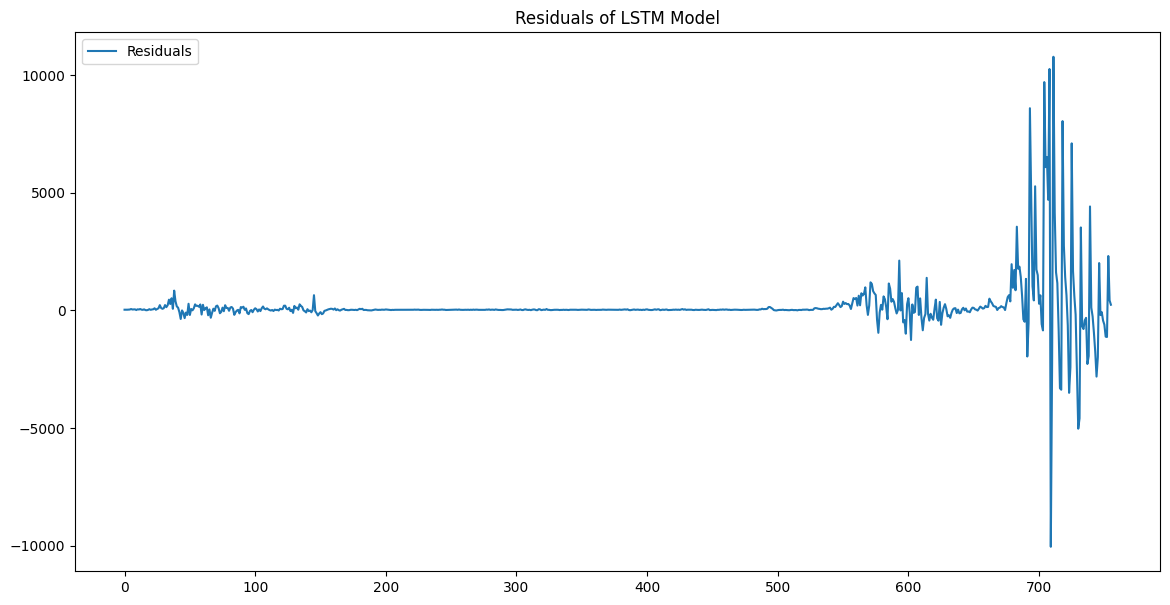

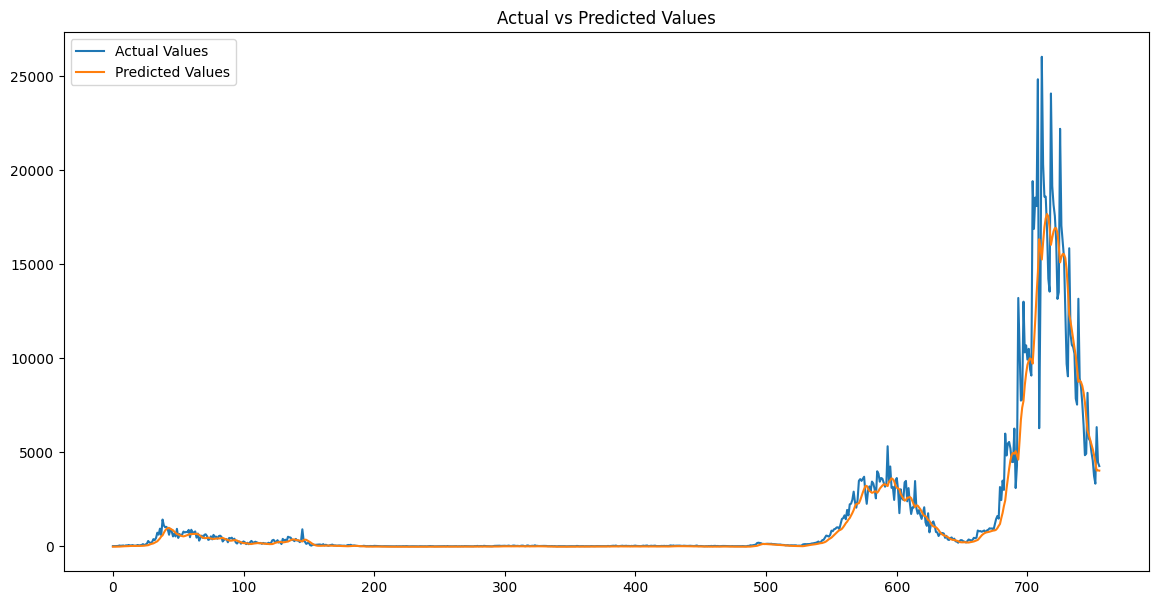

In [263]:

y_pred = model.predict(X)
y_inv = scaler.inverse_transform(y.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)
residuals = y_inv - y_pred_inv

# Plot the residuals
plt.plot(residuals, label='Residuals')
plt.title('Residuals of LSTM Model')
plt.legend()
plt.show()

plt.plot(y_inv, label='Actual Values')
plt.plot(y_pred_inv, label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

       lb_stat     lb_pvalue
10  366.668298  1.151542e-72


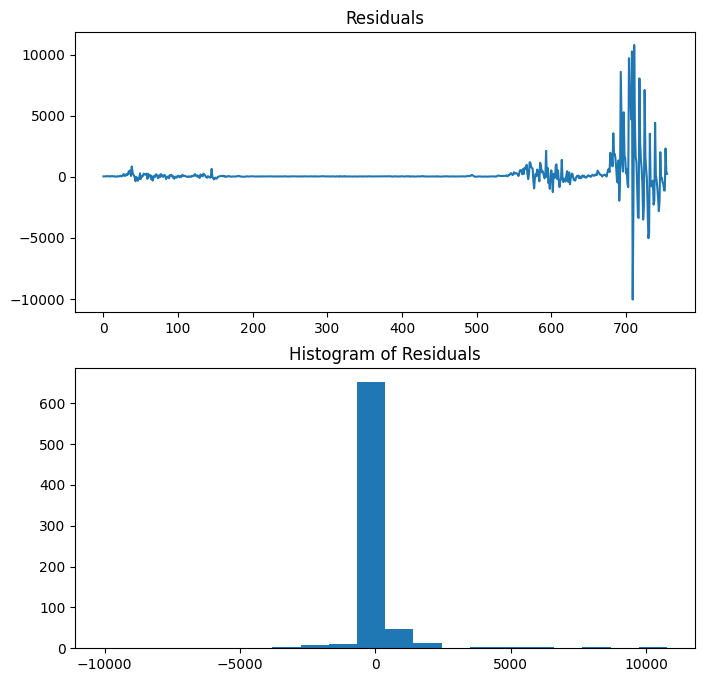

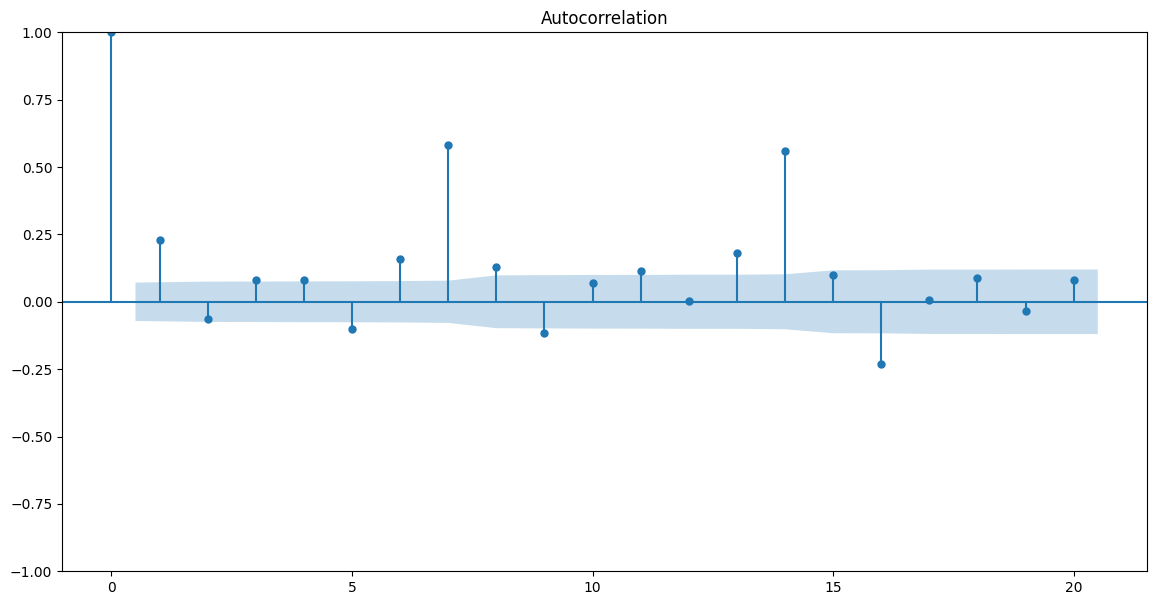

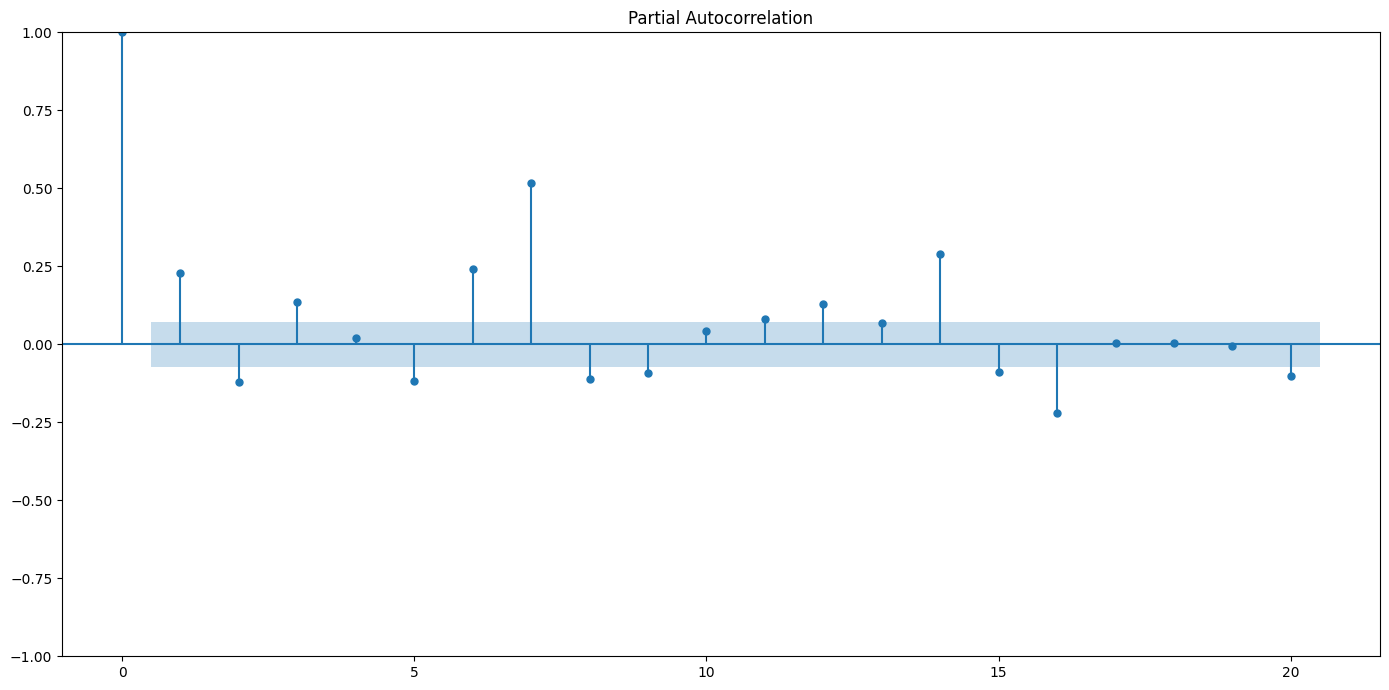

In [264]:
test_residuals(residuals)

The LSTM seems to have a medium performance, even if the residuals are not IID noise. This model gives an approximation of the series

In [274]:
y_inv.shape

(756, 1)

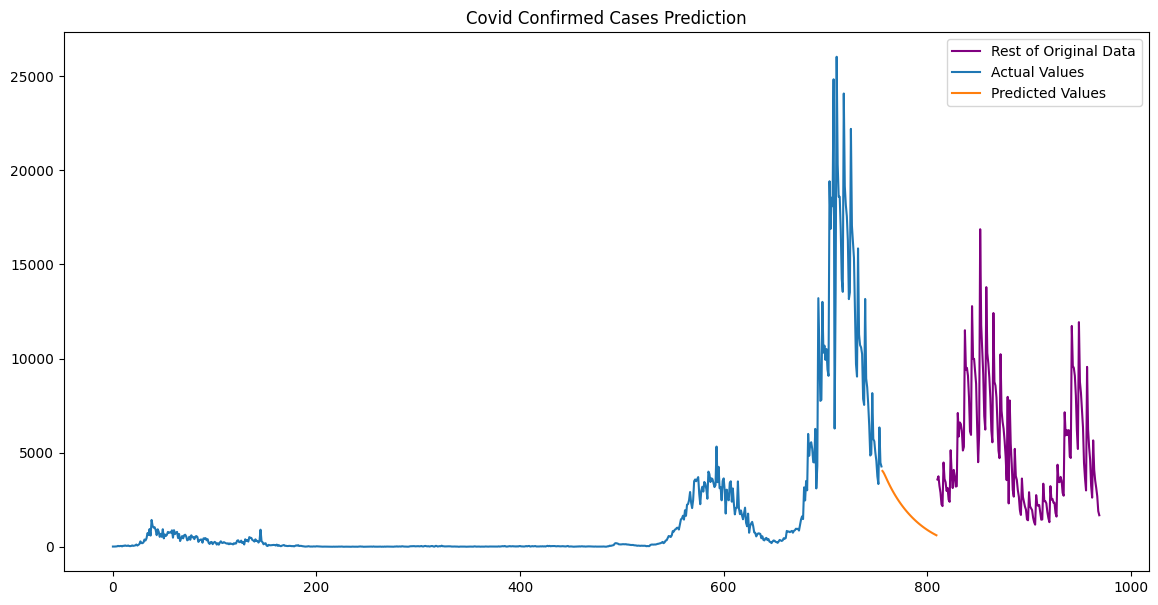

In [278]:
plt.plot(np.arange(756,756+216), data[806:]["Daily Confirmed"].values, color='purple', label='Rest of Original Data')
plt.plot(y_inv, label='Actual Values')
plt.plot(np.arange(756,756+54), predicted, label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend(loc='best')
plt.title('Covid Confirmed Cases Prediction')
plt.show(block=False)

After a few days the model won't be very accurate, so it may be useful to know with some degree what will happen in a few days ahead.

# A Complete Overview

In [3]:
data = pd.read_csv('./covid19cases_test.csv')
data

date     area area_type  population  cases  cumulative_cases  \
0      2020-02-01  Alameda    County   1685886.0    3.0               3.0   
1      2020-02-02  Alameda    County   1685886.0    0.0               3.0   
2      2020-02-03  Alameda    County   1685886.0    0.0               3.0   
3      2020-02-04  Alameda    County   1685886.0    0.0               3.0   
4      2020-02-05  Alameda    County   1685886.0    0.0               3.0   
...           ...      ...       ...         ...    ...               ...   
86554  2023-12-16     Yuba    County     79290.0    3.0           21081.0   
86555  2023-12-17     Yuba    County     79290.0    0.0           21081.0   
86556  2023-12-18     Yuba    County     79290.0    2.0           21083.0   
86557  2023-12-19     Yuba    County     79290.0    0.0           21083.0   
86558         NaN     Yuba    County     79290.0    4.0           21087.0   

       deaths  cumulative_deaths  total_tests  cumulative_total_tests  \
0         0.0                0.0          4.0                       4   
1         0.0                0.0          1.0                       5   
2         0.0                0.0          0.0                       5   
3         0.0                0.0          0.0                       5   
4         0.0                0.0          1.0                       6   
...       ...                ...          ...                     ...   
86554     0.0              147.0         45.0                  220674   
86555     0.0              147.0         50.0                  220724   
86556     0.0              147.0         27.0                  220751   
86557     0.0              147.0          NaN                  220751   
86558     NaN              147.0         41.0                  220792   

       positive_tests  cumulative_positive_tests  
0                 0.0                          0  
1                 0.0                          0  
2                 0.0                          0  
3                 0.0                          0  
4                 0.0                          0  
...               ...                        ...  
86554             5.0                      24559  
86555             1.0                      24560  
86556             3.0                      24563  
86557             NaN                      24563  
86558             3.0                      24566  

[86559 rows x 12 columns]

In [4]:
dates = data["date"].unique()
dates = dates[:-1]
dates.shape

(1418,)

In [5]:
added_data = dict()
added_data["Confirmed"] = []
added_data["Deaths"] = []
added_data["Tests"] = []
added_data["Negatives"] = []
for date in dates:
    c_date = data[data["date"] == date]
    cases = np.nansum(c_date["cases"].values)
    tests = np.nansum(c_date["total_tests"].values)
    added_data["Confirmed"].append(cases)
    added_data["Deaths"].append(np.nansum(c_date["deaths"].values))
    added_data["Tests"].append(tests)
    added_data["Negatives"].append(tests-cases)

for c in added_data:
    added_data[c] = np.array(added_data[c])

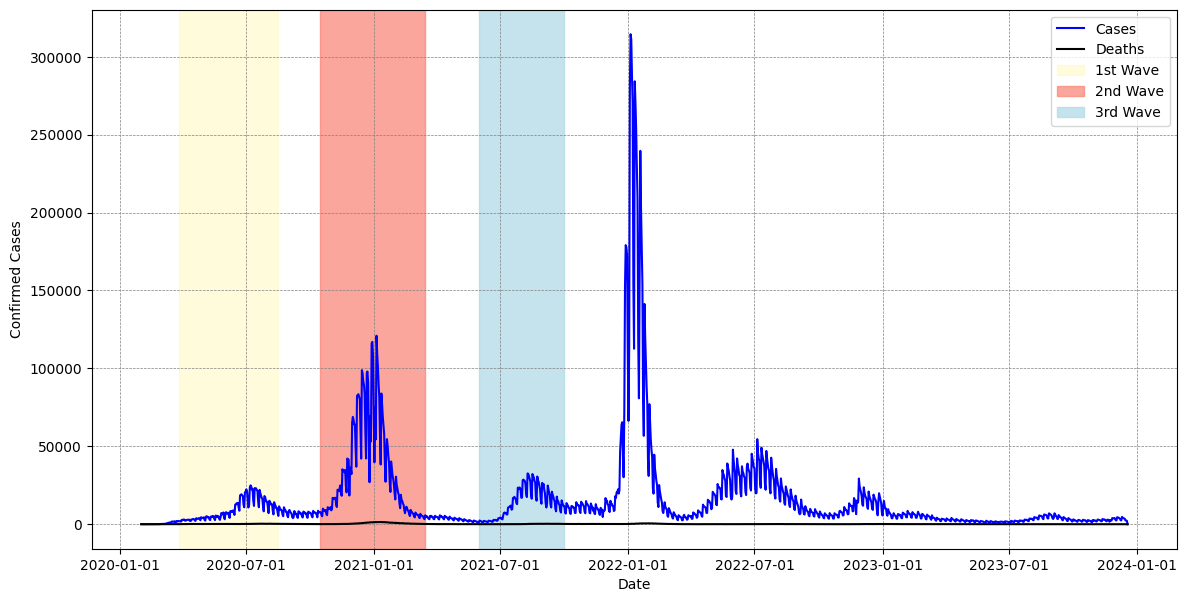

In [6]:
from matplotlib.dates import DateFormatter, AutoDateLocator
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(dates), added_data["Confirmed"], color="blue", label="Cases")
ax.plot(pd.to_datetime(dates), added_data["Deaths"], color="black", label="Deaths")
#plt.plot(dates, added_data["Tests"], color="purple", label="Tests")
#plt.plot(dates, added_data["Negatives"], color="red", label="Negatives")
locator = AutoDateLocator()
formatter = DateFormatter('%Y-%m-%d')

shade_ranges = [
    (pd.Timestamp('2020-03-26'), pd.Timestamp('2020-08-16'),"lemonchiffon","1st Wave"),
    (pd.Timestamp('2020-10-15'), pd.Timestamp('2021-03-14'),"salmon","2nd Wave"),
    (pd.Timestamp('2021-05-31'), pd.Timestamp('2021-09-30'),"lightblue","3rd Wave")
]

for shade_start, shade_end, color, name in shade_ranges:
    plt.axvspan(shade_start, shade_end, color=color, alpha=0.7, label=name)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Confirmed Cases")
ax.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

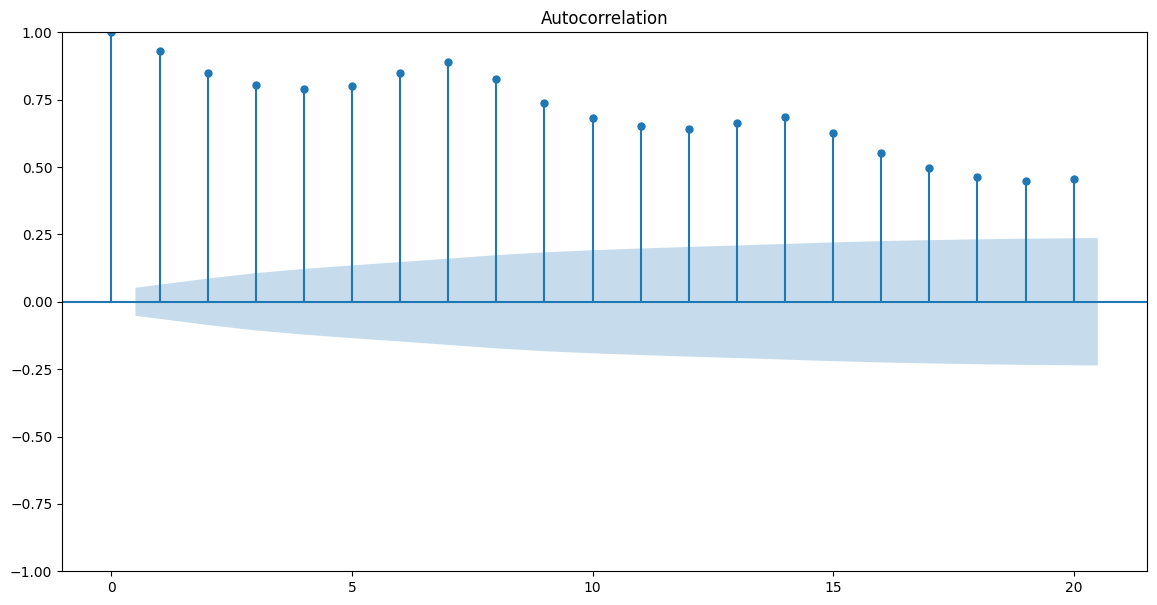

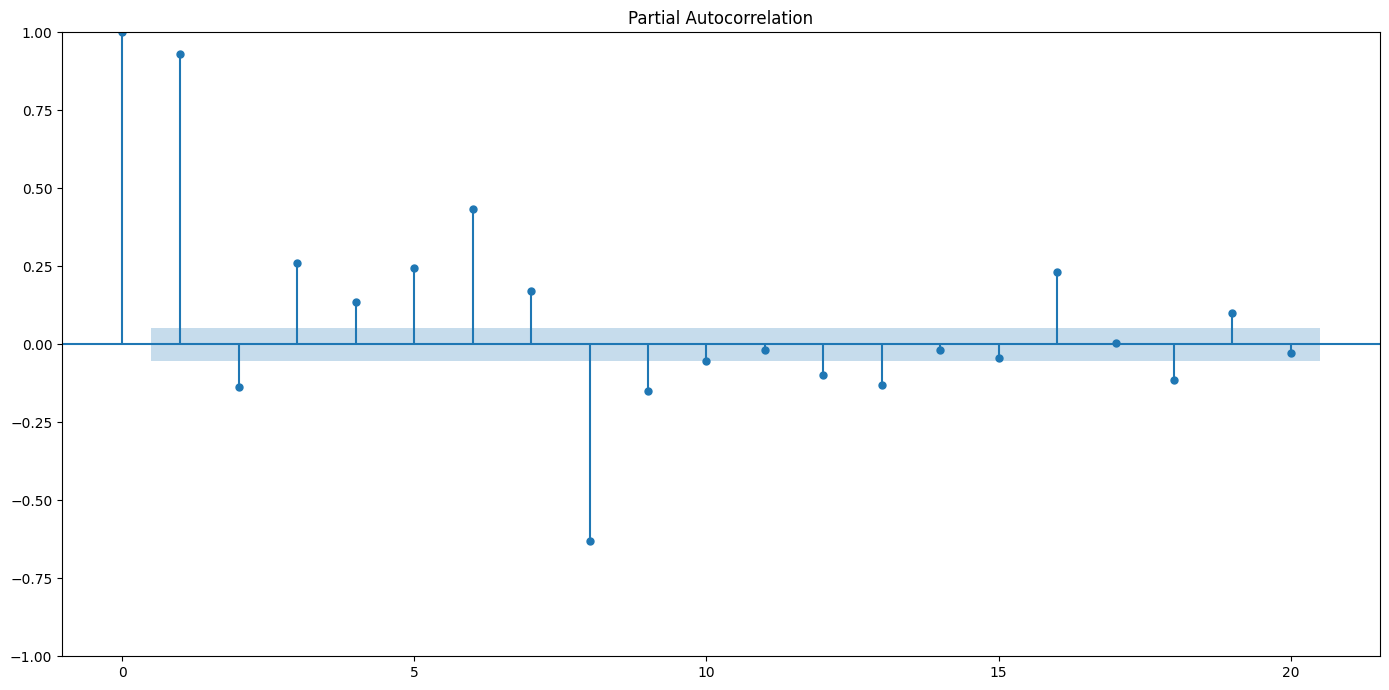

In [7]:
# ACF plot
plot_acf(added_data["Confirmed"], lags=20)

# PACF plot
plot_pacf(added_data["Confirmed"], lags=20)
plt.tight_layout()
plt.show()

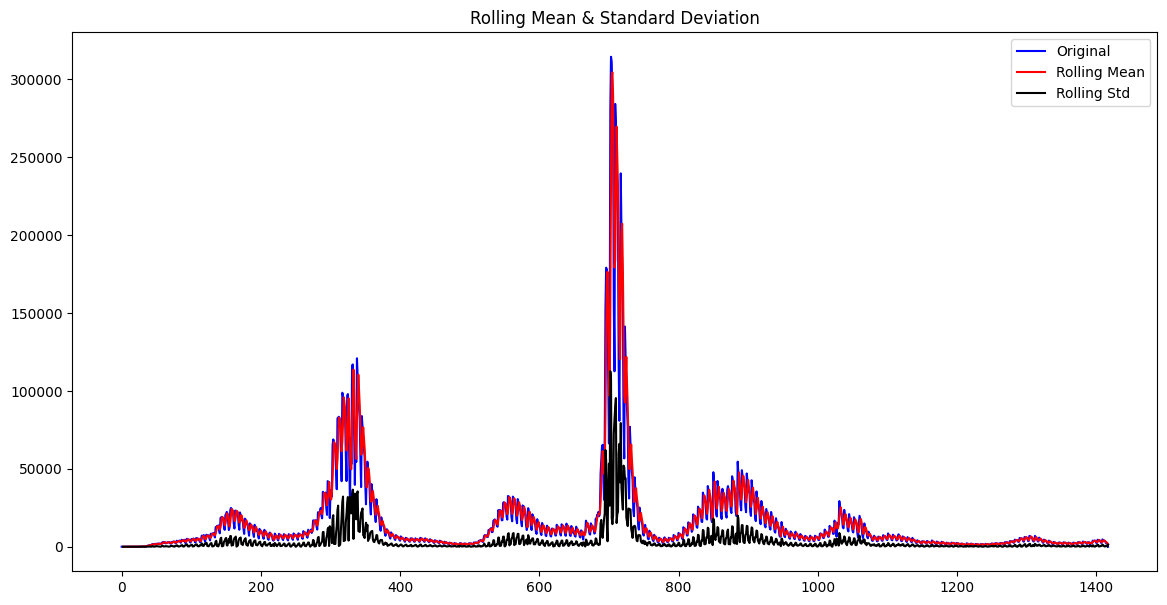

In [8]:
rolmean = pd.Series(added_data["Confirmed"]).rolling(window=3).mean()
rolstd = pd.Series(added_data["Confirmed"]).rolling(window=3).std()
plt.plot(added_data["Confirmed"], color='b', label='Original')
plt.plot(rolmean, color='r', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [9]:
print('Results of Dickey-Fuller Test')

dftest = adfuller(added_data["Confirmed"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p value','#Lags used', 'No:of observations found'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test
Test Statistic                -4.221988
p value                        0.000605
#Lags used                    24.000000
No:of observations found    1393.000000
Critical Value (1%)           -3.435053
Critical Value (5%)           -2.863617
Critical Value (10%)          -2.567876
dtype: float64


In [10]:

def test_data(data, best=True, exog=None, verbose=True):
    models = []
    results = []
    R2 = []
    RMSE = []
    MAE = []
    names = []
    SSt = np.sum((data-np.mean(data))**2)
    for ar in range(0,5):
        for d in range(0,3):
            for am in range(0,5):
                try:
                    model = ARIMA(data, order=(ar,d,am))
                    results_ARIMA = model.fit()
                    models.append(model)
                    results.append(results_ARIMA)

                    SSr = np.sum((data-results_ARIMA.fittedvalues)**2)
                    RMSE.append(np.sqrt(0.5*SSr))
                    R2.append(1-SSr/SSt)
                    MAE.append((np.sum(np.abs(data-results_ARIMA.fittedvalues)))/data.shape[0])
                    if verbose:
                        print(f"Model ARIMA({ar},{d},{am}):")
                        print(f"\tR2: {R2[-1]}")
                        print(f"\tRMSE: {RMSE[-1]}")
                        print(f"\tMAE: {MAE[-1]}")
                    name = ""
                    if ar > 0: name+="AR"
                    if d > 0: name+="I"
                    if am > 0: name+="MA"
                    names.append(name+f"({ar},{d},{am})")
                except:
                    continue
    if exog is not None:
        for ar in range(0,5):
            for d in range(0,3):
                for am in range(0,5):
                    try:
                        model = ARIMA(data, order=(ar,d,am), exog=exog)
                        results_ARIMA = model.fit()
                        models.append(model)
                        results.append(results_ARIMA)

                        SSr = np.sum((data-results_ARIMA.fittedvalues)**2)
                        RMSE.append(np.sqrt(0.5*SSr))
                        R2.append(1-SSr/SSt)
                        MAE.append((np.sum(np.abs(data-results_ARIMA.fittedvalues)))/data.shape[0])
                        if verbose:
                            print(f"Model ARIMAX({ar},{d},{am}):")
                            print(f"\tR2: {R2[-1]}")
                            print(f"\tRMSE: {RMSE[-1]}")
                            print(f"\tMAE: {MAE[-1]}")
                        name = ""
                        if ar > 0: name+="AR"
                        if d > 0: name+="I"
                        if am > 0: name+="MA"
                        names.append(name+f"X({ar},{d},{am})")
                    except:
                        continue
    if best:
        besti = np.argmax(R2)
        return models[besti], results[besti], (R2[besti], RMSE[besti], MAE[besti])
    else:
        return models, results, (R2, RMSE, MAE), names

In [390]:
model, res, perf = test_data(added_data["Confirmed"], exog=added_data["Deaths"])

Model ARIMA(0,0,0):
	R2: -2.220446049250313e-16
	RMSE: 838447.4784290484
	MAE: 15717.780361700561
Model ARIMA(0,0,1):
	R2: 0.6530761835031629
	RMSE: 493847.56944655854
	MAE: 8961.618261992213
Model ARIMA(0,0,2):
	R2: 0.795837873831669
	RMSE: 378846.65138409927
	MAE: 6541.65858942574
Model ARIMA(0,0,3):
	R2: 0.8095772902619417
	RMSE: 365877.1044478585
	MAE: 6114.449788157819
Model ARIMA(0,0,4):
	R2: 0.874013994852542
	RMSE: 297602.80179256294
	MAE: 4720.3444912382865
Model ARIMA(0,1,0):
	R2: 0.8635550740474065
	RMSE: 309709.5220170022
	MAE: 3757.5599435825106
Model ARIMA(0,1,1):
	R2: 0.86626100478796
	RMSE: 306623.1147221553
	MAE: 3756.0463657811697
Model ARIMA(0,1,2):
	R2: 0.8820490111262839
	RMSE: 287956.3473960465
	MAE: 3861.552177386885
Model ARIMA(0,1,3):
	R2: 0.8860596531965808
	RMSE: 283018.3739546209
	MAE: 3784.168730757551
Model ARIMA(0,1,4):
	R2: 0.8896990100539947
	RMSE: 278461.7627749686
	MAE: 3852.984649249746
Model ARIMA(0,2,0):
	R2: 0.7540010243034004
	RMSE: 415855.559954

In [393]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1418
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -14812.731
Date:                Thu, 13 Jun 2024   AIC                          29643.463
Time:                        14:46:43   BIC                          29690.770
Sample:                             0   HQIC                         29661.137
                               - 1418                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9810      0.016     63.169      0.000       0.951       1.011
ar.L2         -1.4884      0.017    -86.295      0.000      -1.522      -1.455
ar.L3          0.7884      0.016     47.937      0.000       0.756       0.821
ar.L4         -0.7893      0.010    -81.212      0.000      -0.808      -0.770
ma.L1         -1.1840      0.021    -56.652      0.000      -1.225      -1.143
ma.L2          1.5326      0.030     51.760      0.000       1.475       1.591
ma.L3         -0.8337      0.032    -26.021      0.000      -0.896      -0.771
ma.L4          0.3781      0.020     19.195      0.000       0.340       0.417
sigma2      1.031e+08   1.14e-10   9.09e+17      0.000    1.03e+08    1.03e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):            251490.68
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             2.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+33. Standard errors may be unstable.
"""

       lb_stat     lb_pvalue
10  308.135466  2.959495e-60


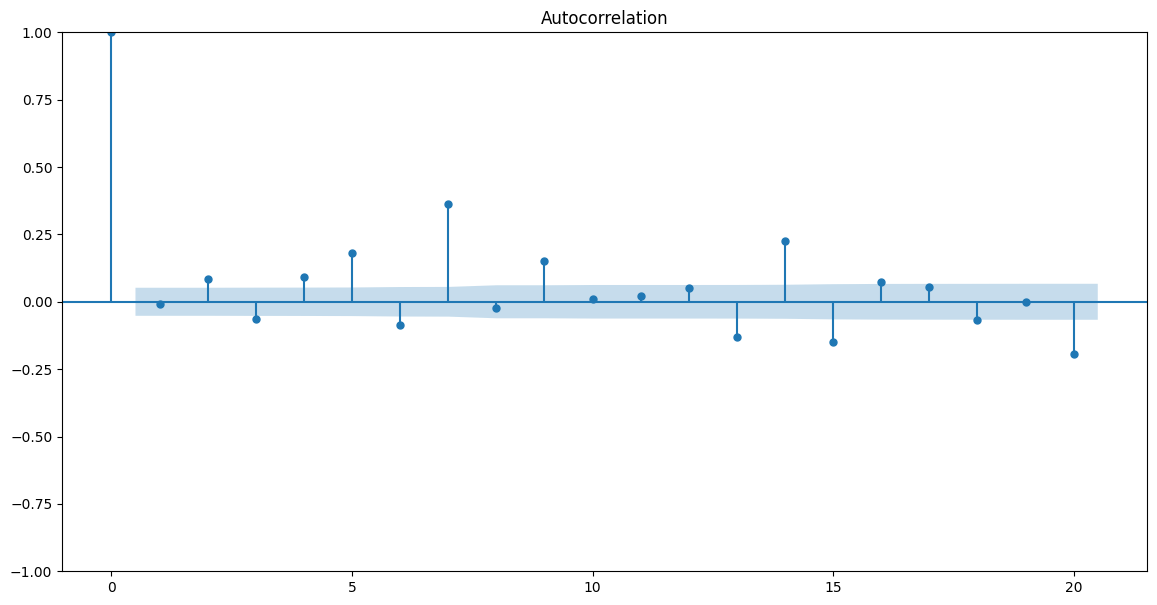

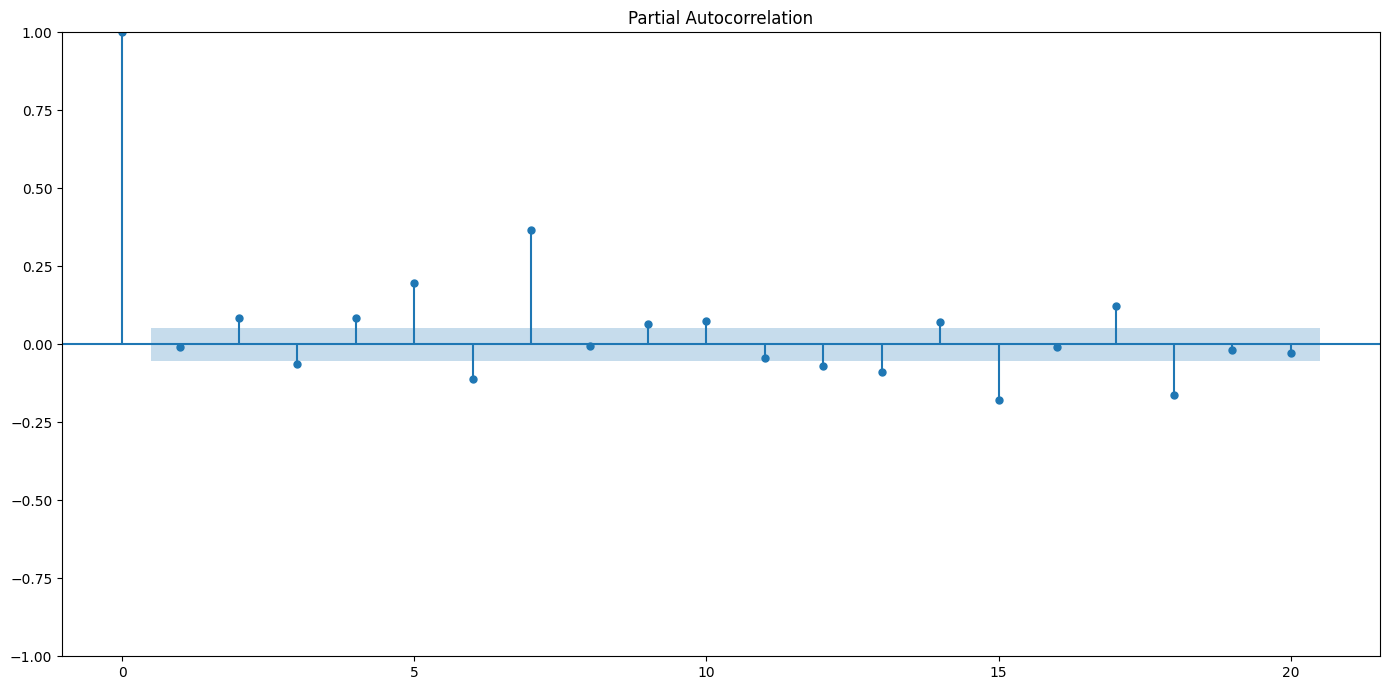

In [394]:
test_residuals(res.resid)

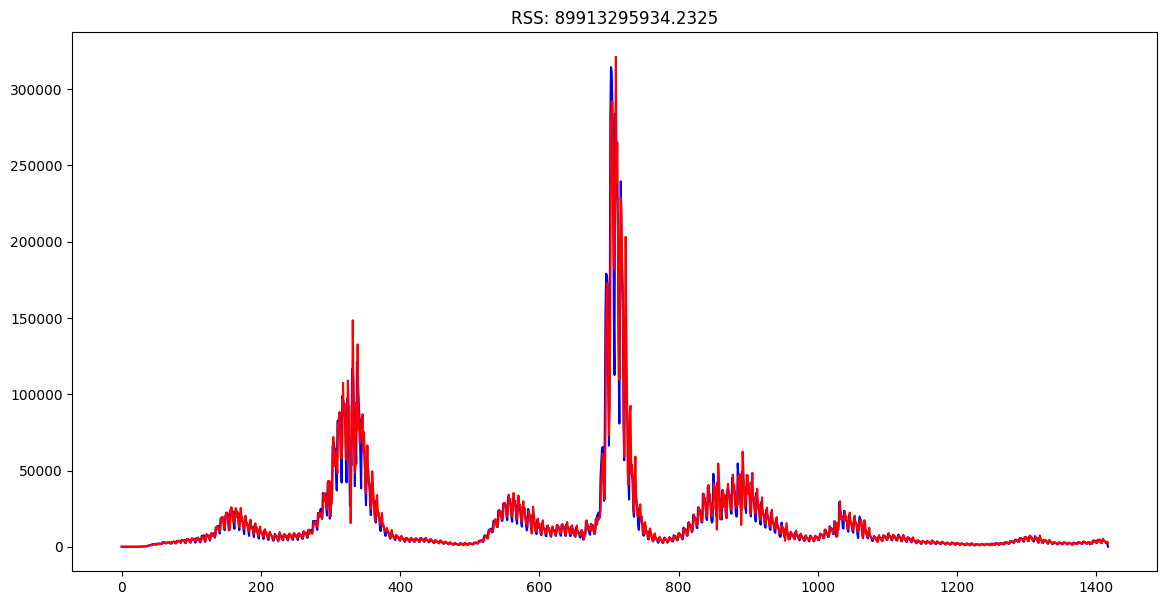

In [395]:
plt.plot(added_data["Confirmed"],color='b')
plt.plot(res.fittedvalues, color='r')
plt.title('RSS: {:1.4f}'.format(sum((res.fittedvalues-added_data["Confirmed"])**2)))
plt.show()

In [405]:
pred = res.get_prediction()
pred_ci = pred.conf_int()
lower_ci = pred_ci[:, 0]
upper_ci = pred_ci[:, 1]

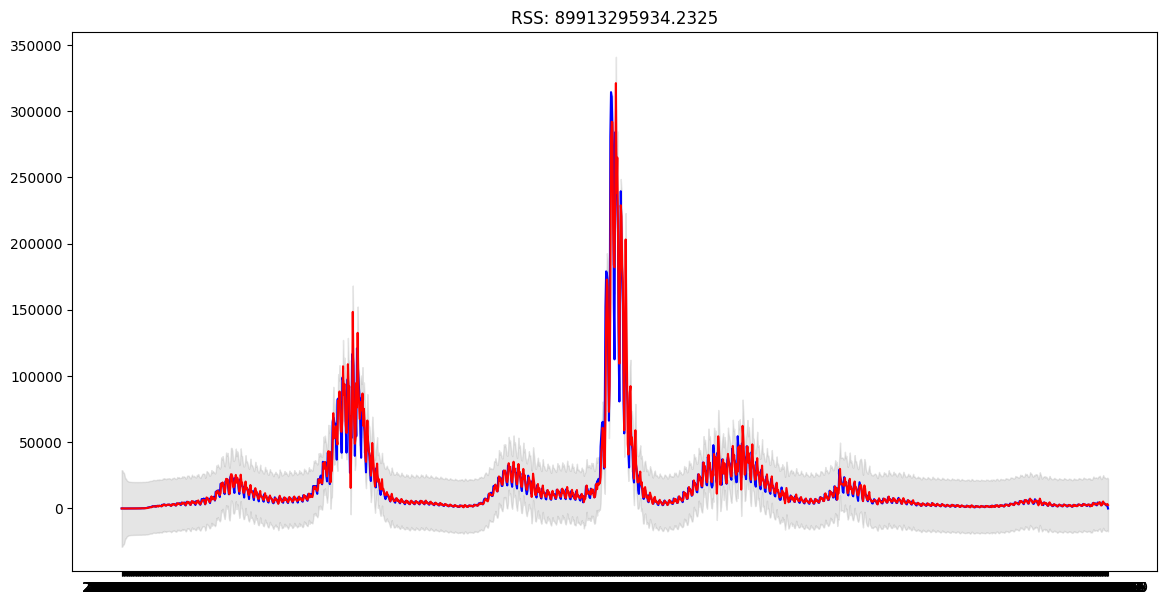

In [406]:
plt.plot(dates, added_data["Confirmed"],color='b')
plt.plot(dates, res.fittedvalues, color='r')
plt.title('RSS: {:1.4f}'.format(sum((res.fittedvalues-added_data["Confirmed"])**2)))
plt.fill_between(dates, lower_ci, upper_ci, color='gray', alpha=0.2, label='Confidence Interval')
plt.show()

In [90]:

splits = [
    (np.where(dates == '2020-03-26')[0][0], np.where(dates == '2020-08-16')[0][0]),
    (np.where(dates == '2020-10-15')[0][0], np.where(dates == '2021-03-14')[0][0]),
    (np.where(dates == '2021-05-31')[0][0], np.where(dates == '2021-09-30')[0][0]),
    (0, -1)
]

best_models = []
perf_data = dict()
for i, (start, end) in enumerate(splits):
    print(start, end)
    model, res, perf, names = test_data(added_data["Confirmed"][start:end], exog=added_data["Deaths"][start:end], verbose=False, best=False)
    perf_data[i] = (perf, names)
    best_models.append((model, res, perf))

print(best_models)

54 197
257 407
485 607
0 -1
[([<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E829B04C0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E827E82B0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E829B2980>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E829B2A70>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E82A1C250>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E82A1D870>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E82A1CB80>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E8292B1F0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E8292BA30>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E829FE5F0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E829FF310>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E829FD6F0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E829FCE20>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E829FECB0>, <statsmodels.tsa.arima.model.ARIMA object at 

In [19]:
waves_split = ["1st Wave", "2nd Wave", "3rd Wave", "All data"]
perf_data2 = {waves_split[x]: perf_data[x] for x in perf_data} #R2, RMSE, MAE

In [34]:
def process_df(name):
    df_1st = pd.DataFrame()
    df_1st["Names"] = perf_data2[name][1]
    df_1st["R2"] = perf_data2[name][0][0]
    df_1st["RMSE"] = perf_data2[name][0][1]
    df_1st["MAE"] = perf_data2[name][0][2]
    df_1st.drop(0,inplace=True)
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("ARI\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("^IMA\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("ARIX\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("^IMAX\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("^X\(", regex=True)]
    return df_1st

In [37]:
df_1st = process_df("1st Wave")
df_2nd = process_df("2nd Wave")
df_3rd4th = process_df("3rd Wave")
df_all = process_df("All data")

In [50]:

# Merge the DataFrames on 'Names'
merged_df = df_1st.merge(df_2nd, on='Names', how='outer', suffixes=(' 1st Wave', ' 2nd Wave'))
merged_df = merged_df.merge(df_3rd4th, on='Names', how='outer', suffixes=('', ' 3rd+4th Wave'))
merged_df = merged_df.merge(df_all, on='Names', how='outer', suffixes=('', ' All Data'))

In [52]:
merged_df.rename({'R2':'R2 3rd+4th Wave', 'RMSE' :'RMSE 3rd+4th Wave', 'MAE':'MAE 3rd+4th Wave'},axis=1,inplace=True)

In [54]:
merged_df.to_csv("./performances.csv")

In [53]:
merged_df.columns

Index(['Names', 'R2 1st Wave', 'RMSE 1st Wave', 'MAE 1st Wave', 'R2 2nd Wave',
       'RMSE 2nd Wave', 'MAE 2nd Wave', 'R2 3rd+4th Wave', 'RMSE 3rd+4th Wave',
       'MAE 3rd+4th Wave', 'R2 All Data', 'RMSE All Data', 'MAE All Data'],
      dtype='object')

In [60]:
print("R2")
print(merged_df["R2 1st Wave"].max(),merged_df[merged_df["R2 1st Wave"]==merged_df["R2 1st Wave"].max()]["Names"].values[0])
print(merged_df["R2 2nd Wave"].max(),merged_df[merged_df["R2 2nd Wave"]==merged_df["R2 2nd Wave"].max()]["Names"].values[0])
print(merged_df["R2 3rd+4th Wave"].max(),merged_df[merged_df["R2 3rd+4th Wave"]==merged_df["R2 3rd+4th Wave"].max()]["Names"].values[0])
print(merged_df["R2 All Data"].max(),merged_df[merged_df["R2 All Data"]==merged_df["R2 All Data"].max()]["Names"].values[0])
print("RMSE")
print(merged_df["RMSE 1st Wave"].max(),merged_df[merged_df["RMSE 1st Wave"]==merged_df["RMSE 1st Wave"].max()]["Names"].values[0])
print(merged_df["RMSE 2nd Wave"].max(),merged_df[merged_df["RMSE 2nd Wave"]==merged_df["RMSE 2nd Wave"].max()]["Names"].values[0])
print(merged_df["RMSE 3rd+4th Wave"].max(),merged_df[merged_df["RMSE 3rd+4th Wave"]==merged_df["RMSE 3rd+4th Wave"].max()]["Names"].values[0])
print(merged_df["RMSE All Data"].max(),merged_df[merged_df["RMSE All Data"]==merged_df["RMSE All Data"].max()]["Names"].values[0])
print("MAE")
print(merged_df["MAE 1st Wave"].max(),merged_df[merged_df["MAE 1st Wave"]==merged_df["MAE 1st Wave"].max()]["Names"].values[0])
print(merged_df["MAE 2nd Wave"].max(),merged_df[merged_df["MAE 2nd Wave"]==merged_df["MAE 2nd Wave"].max()]["Names"].values[0])
print(merged_df["MAE 3rd+4th Wave"].max(),merged_df[merged_df["MAE 3rd+4th Wave"]==merged_df["MAE 3rd+4th Wave"].max()]["Names"].values[0])
print(merged_df["MAE All Data"].max(),merged_df[merged_df["MAE All Data"]==merged_df["MAE All Data"].max()]["Names"].values[0])


R2
0.9371406696519546 ARIMAX(4,1,4)
0.8843170464085058 ARIMAX(4,1,4)
0.9408561423799601 ARIMA(4,1,4)
0.9360426631880066 ARIMA(4,1,4)
RMSE
37295.762162568186 I(0,2,0)
205155.22055069444 I(0,2,0)
47676.97905253261 MA(0,0,1)
493805.25273270445 MA(0,0,1)
MAE
3409.1014290710737 MA(0,0,1)
15679.460967964415 MA(0,0,1)
5156.69414485542 MA(0,0,1)
8964.629598139341 MA(0,0,1)


In [101]:

splits = [
    (np.where(dates == '2020-03-26')[0][0], np.where(dates == '2020-08-16')[0][0]),
    (np.where(dates == '2020-10-15')[0][0], np.where(dates == '2021-03-14')[0][0]),
    (np.where(dates == '2021-05-31')[0][0], np.where(dates == '2021-09-30')[0][0]),
    (0, -1)
]

best_models = []
perf_data = dict()
for i, (start, end) in enumerate(splits):
    print(start, end)
    model, res, perf = test_data(added_data["Confirmed"][start:end], verbose=False, best=True)
    perf_data[i] = perf
    best_models.append((model, res, perf))

print(best_models)

54 197
257 407
485 607
0 -1
[(<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E7C3EEB30>, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024E7FFB0670>, (0.9146197373961201, 16383.688732133927, 1356.778424339306)), (<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E7C3ED3F0>, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024E7C3EF100>, (0.8750733696824359, 95071.44757564843, 7012.680534084017)), (<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E7C3ED360>, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024E7C3ECEB0>, (0.9408561423799601, 18195.1980329931, 1681.1231226023265)), (<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E7C3EC520>, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024E7C3ECE80>, (0.9360426631880066, 212021.53478776148, 2817.3299752421226))]


In [111]:
titles = ["1st Wave", "2nd Wave", "3rd Wave"]
splits = [
    (np.where(dates == '2020-03-26')[0][0], np.where(dates == '2020-08-16')[0][0]),
    (np.where(dates == '2020-10-15')[0][0], np.where(dates == '2021-03-14')[0][0]),
    (np.where(dates == '2021-05-31')[0][0], np.where(dates == '2021-09-30')[0][0])
]
forwrd = 14
fig, ax = plt.subplots(3)
for i, (start, end) in enumerate(splits):
    fc=best_models[i][1].forecast(steps=forwrd)
    forecast = fc
    pred = best_models[i][1].get_forecast(steps=forwrd)
    pred_ci = pred.conf_int()
    lower_ci = pred_ci[:, 0]
    upper_ci = pred_ci[:, 1]

    date_range = pd.date_range(start=dates[end+1], periods=forwrd)

    # Prediction Plotting
    ax[i].fill_between(date_range, lower_ci, upper_ci, color='gray', alpha=0.5, label='Confidence Interval')
    ax[i].plot(pd.to_datetime(dates[start:end]), added_data["Confirmed"][start:end],color='b', label='Train Data')
    ax[i].plot(pd.to_datetime(dates[end:end+forwrd]), added_data["Confirmed"][end:end+forwrd],color='purple', label='Original Data')
    ax[i].plot(date_range, forecast, color='r', label='Prediction')
    ax[i].grid(color='gray', linestyle='--', linewidth=0.5)
    ax[i].legend(loc='best')
    ax[i].set_title('Covid Confirmed Cases Prediction')
    #ax.set_xlim(pd.to_datetime("2021-09-01"), pd.to_datetime("2022-09-01"))
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Confirmed Cases")
plt.tight_layout()
plt.show(block=False)

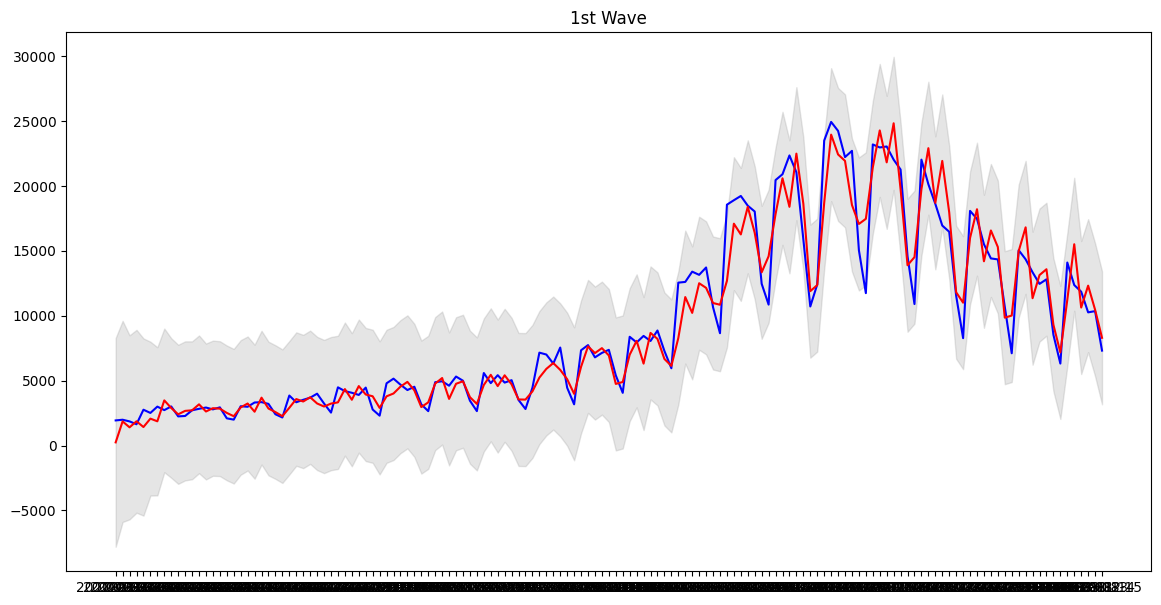

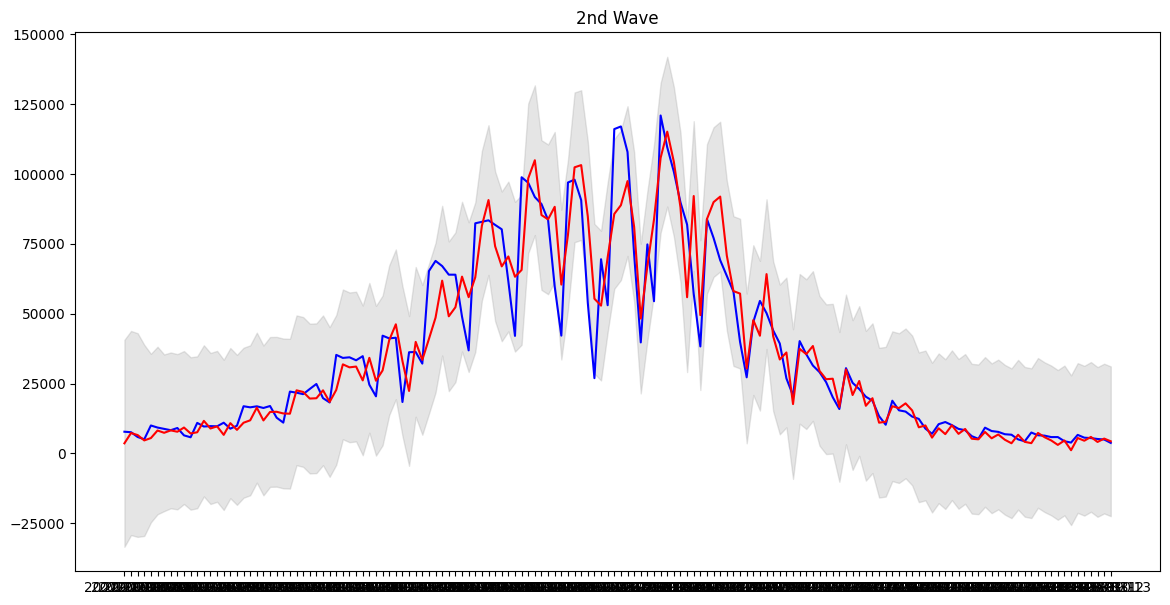

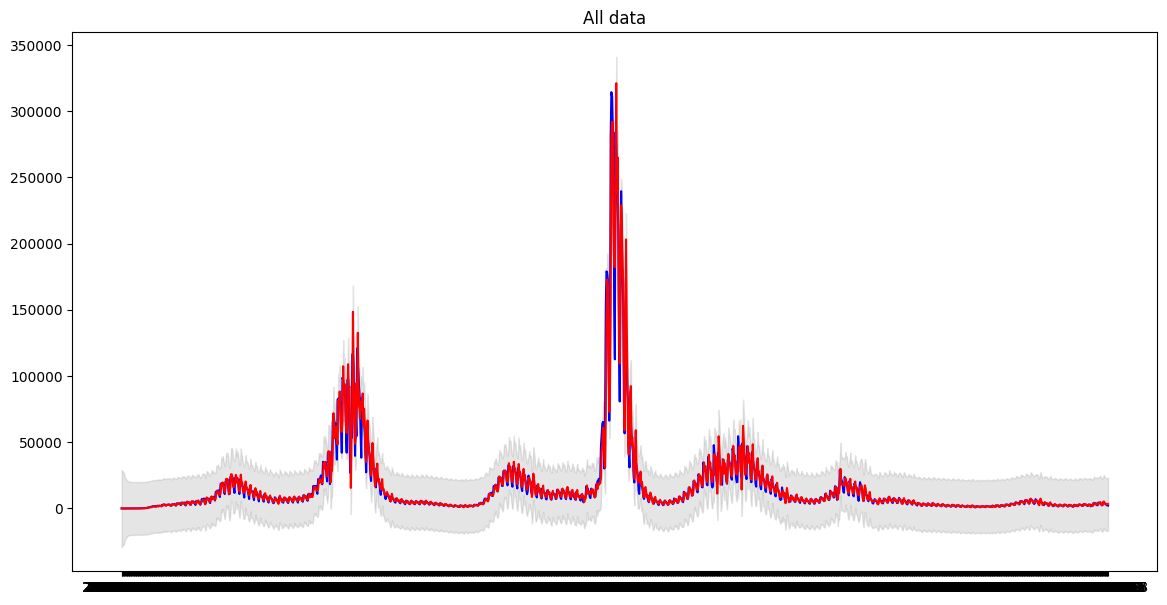

In [420]:
titles = ["1st Wave", "2nd Wave", "3rd Wave", "All data"]

for i, (start, end) in enumerate(splits):
    pred = best_models[i][1].get_prediction()
    pred_ci = pred.conf_int()
    lower_ci = pred_ci[:, 0]
    upper_ci = pred_ci[:, 1]

    plt.plot(pd.to_datetime(dates[start:end]), added_data["Confirmed"][start:end],color='b')
    plt.plot(pd.to_datetime(dates[start:end]), best_models[i][1].fittedvalues, color='r')
    plt.title(titles[i])
    plt.fill_between(pd.to_datetime(dates[start:end]), lower_ci, upper_ci, color='gray', alpha=0.2, label='Confidence Interval')
    plt.show()

In [119]:
daily_data = pd.DataFrame(added_data, index=pd.to_datetime(dates))
weekly_data = daily_data.rolling(window=7).mean()
weekly_data = weekly_data.dropna()

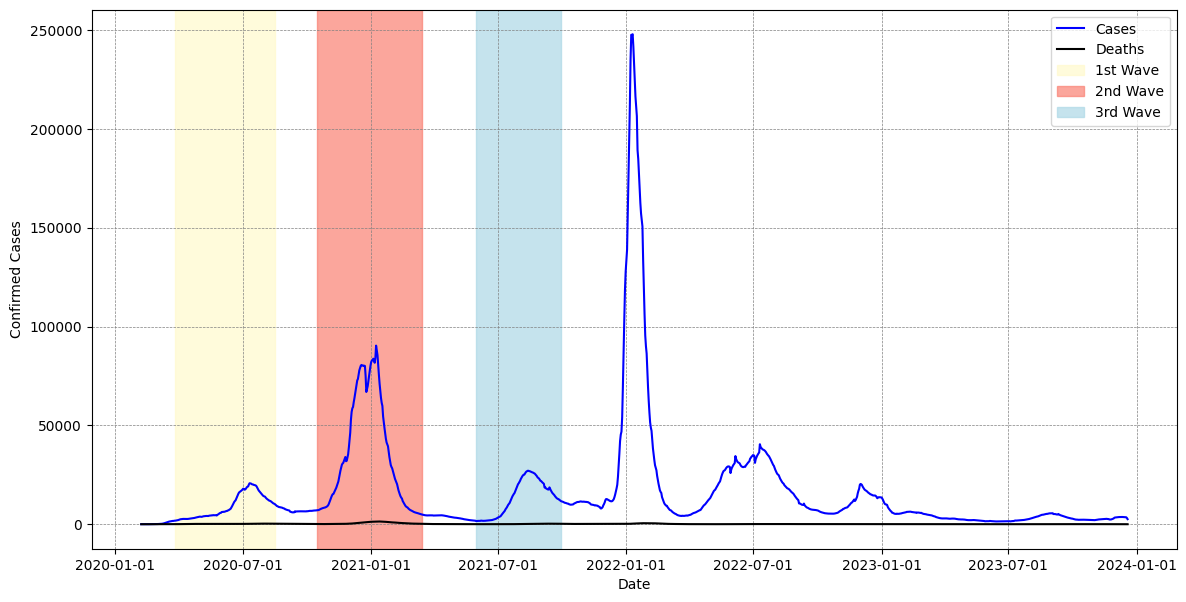

In [84]:
from matplotlib.dates import DateFormatter, AutoDateLocator
weekly_dates = dates[np.where(dates == "2020-02-07")[0][0]:]
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(weekly_dates), weekly_data["Confirmed"], color="blue", label="Cases")
ax.plot(pd.to_datetime(weekly_dates), weekly_data["Deaths"], color="black", label="Deaths")
#plt.plot(dates, added_data["Tests"], color="purple", label="Tests")
#plt.plot(dates, added_data["Negatives"], color="red", label="Negatives")
locator = AutoDateLocator()
formatter = DateFormatter('%Y-%m-%d')

shade_ranges = [
    (pd.Timestamp('2020-03-26'), pd.Timestamp('2020-08-16'),"lemonchiffon","1st Wave"),
    (pd.Timestamp('2020-10-15'), pd.Timestamp('2021-03-14'),"salmon","2nd Wave"),
    (pd.Timestamp('2021-05-31'), pd.Timestamp('2021-09-30'),"lightblue","3rd Wave")
]

for shade_start, shade_end, color, name in shade_ranges:
    plt.axvspan(shade_start, shade_end, color=color, alpha=0.7, label=name)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Confirmed Cases")
ax.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [69]:
weekly_dates = dates[np.where(dates == "2020-02-07")[0][0]:]
splits = [
    (np.where(weekly_dates == '2020-03-26')[0][0], np.where(weekly_dates == '2020-08-16')[0][0]),
    (np.where(weekly_dates == '2020-10-15')[0][0], np.where(weekly_dates == '2021-03-14')[0][0]),
    (np.where(weekly_dates == '2021-05-31')[0][0], np.where(weekly_dates == '2021-09-30')[0][0]),
    (0, -1)
]
best_models = []
perf_data = dict()
for i, (start, end) in enumerate(splits):
    print(start, end)
    model, res, perf, names = test_data(weekly_data["Confirmed"].values[start:end], exog=weekly_data["Deaths"].values[start:end], verbose=False, best=False)
    perf_data[i] = (perf, names)
    best_models.append((model, res, perf))

print(best_models)

48 191
251 401
479 601
0 -1
[([<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E249543D0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E249553F0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E2797FFA0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E2797C8B0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E249073D0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E2B9BB760>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E2B9BB610>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278EFD90>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278EFF10>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278EFD30>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278EF850>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278EF9D0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278FAE00>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278FAD40>, <statsmodels.tsa.arima.model.ARIMA object at 

In [70]:
waves_split = ["1st Wave", "2nd Wave", "3rd Wave", "All data"]
perf_data2 = {waves_split[x]: perf_data[x] for x in perf_data} #R2, RMSE, MAE

def process_df(name):
    df_1st = pd.DataFrame()
    df_1st["Names"] = perf_data2[name][1]
    df_1st["R2"] = perf_data2[name][0][0]
    df_1st["RMSE"] = perf_data2[name][0][1]
    df_1st["MAE"] = perf_data2[name][0][2]
    df_1st.drop(0,inplace=True)
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("ARI\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("^IMA\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("ARIX\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("^IMAX\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("^X\(", regex=True)]
    return df_1st

df_1st = process_df("1st Wave")
df_2nd = process_df("2nd Wave")
df_3rd4th = process_df("3rd Wave")
df_all = process_df("All data")

# Merge the DataFrames on 'Names'
merged_df = df_1st.merge(df_2nd, on='Names', how='outer', suffixes=(' 1st Wave', ' 2nd Wave'))
merged_df = merged_df.merge(df_3rd4th, on='Names', how='outer', suffixes=('', ' 3rd+4th Wave'))
merged_df = merged_df.merge(df_all, on='Names', how='outer', suffixes=('', ' All Data'))
merged_df.rename({'R2':'R2 3rd+4th Wave', 'RMSE' :'RMSE 3rd+4th Wave', 'MAE':'MAE 3rd+4th Wave'},axis=1,inplace=True)
merged_df.to_csv("./performances_7days.csv")

In [71]:
merged_df.columns

Index(['Names', 'R2 1st Wave', 'RMSE 1st Wave', 'MAE 1st Wave', 'R2 2nd Wave',
       'RMSE 2nd Wave', 'MAE 2nd Wave', 'R2 3rd+4th Wave', 'RMSE 3rd+4th Wave',
       'MAE 3rd+4th Wave', 'R2 All Data', 'RMSE All Data', 'MAE All Data'],
      dtype='object')

In [72]:
print("R2")
print(merged_df["R2 1st Wave"].max(),merged_df[merged_df["R2 1st Wave"]==merged_df["R2 1st Wave"].max()]["Names"].values[0])
print(merged_df["R2 2nd Wave"].max(),merged_df[merged_df["R2 2nd Wave"]==merged_df["R2 2nd Wave"].max()]["Names"].values[0])
print(merged_df["R2 3rd+4th Wave"].max(),merged_df[merged_df["R2 3rd+4th Wave"]==merged_df["R2 3rd+4th Wave"].max()]["Names"].values[0])
print(merged_df["R2 All Data"].max(),merged_df[merged_df["R2 All Data"]==merged_df["R2 All Data"].max()]["Names"].values[0])
print("RMSE")
print(merged_df["RMSE 1st Wave"].max(),merged_df[merged_df["RMSE 1st Wave"]==merged_df["RMSE 1st Wave"].max()]["Names"].values[0])
print(merged_df["RMSE 2nd Wave"].max(),merged_df[merged_df["RMSE 2nd Wave"]==merged_df["RMSE 2nd Wave"].max()]["Names"].values[0])
print(merged_df["RMSE 3rd+4th Wave"].max(),merged_df[merged_df["RMSE 3rd+4th Wave"]==merged_df["RMSE 3rd+4th Wave"].max()]["Names"].values[0])
print(merged_df["RMSE All Data"].max(),merged_df[merged_df["RMSE All Data"]==merged_df["RMSE All Data"].max()]["Names"].values[0])
print("MAE")
print(merged_df["MAE 1st Wave"].max(),merged_df[merged_df["MAE 1st Wave"]==merged_df["MAE 1st Wave"].max()]["Names"].values[0])
print(merged_df["MAE 2nd Wave"].max(),merged_df[merged_df["MAE 2nd Wave"]==merged_df["MAE 2nd Wave"].max()]["Names"].values[0])
print(merged_df["MAE 3rd+4th Wave"].max(),merged_df[merged_df["MAE 3rd+4th Wave"]==merged_df["MAE 3rd+4th Wave"].max()]["Names"].values[0])
print(merged_df["MAE All Data"].max(),merged_df[merged_df["MAE All Data"]==merged_df["MAE All Data"].max()]["Names"].values[0])


R2
0.9988663399796699 ARIMAX(4,1,4)
0.9977967803775589 ARIMAX(4,1,4)
0.9989366283022338 ARIMA(4,1,4)
0.9987045225698398 ARIMA(4,1,2)
RMSE
26968.94856744756 MA(0,0,1)
125092.79935366103 MA(0,0,1)
37101.81468034397 MA(0,0,1)
400984.03820498305 MA(0,0,1)
MAE
2864.451785923874 MA(0,0,1)
12724.792960290331 MA(0,0,1)
4218.970794175321 MA(0,0,1)
8468.687082340288 MA(0,0,4)


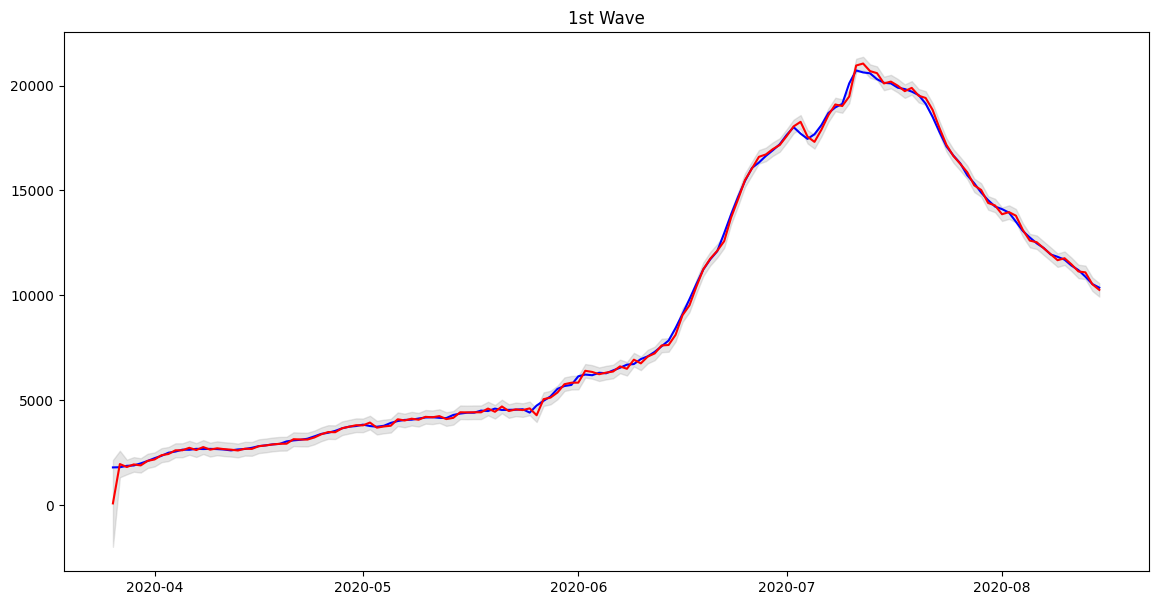

     lb_stat  lb_pvalue
10  3.330868   0.972532


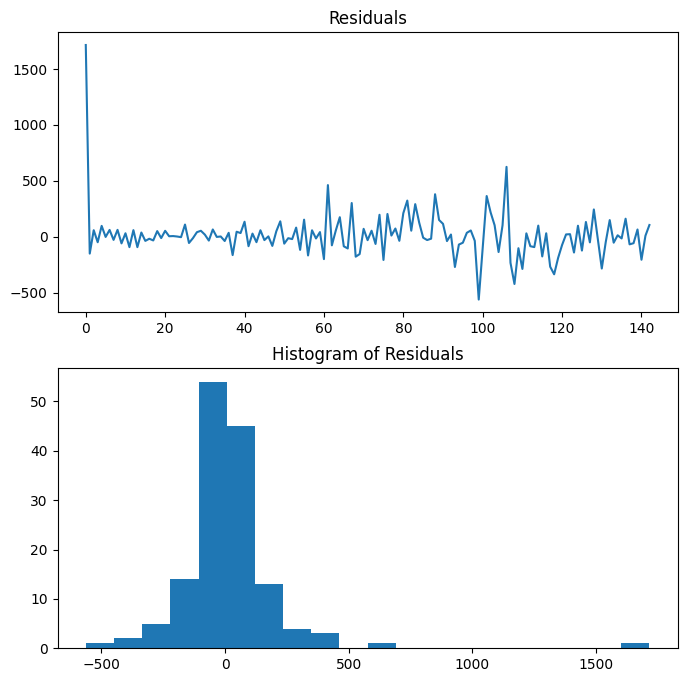

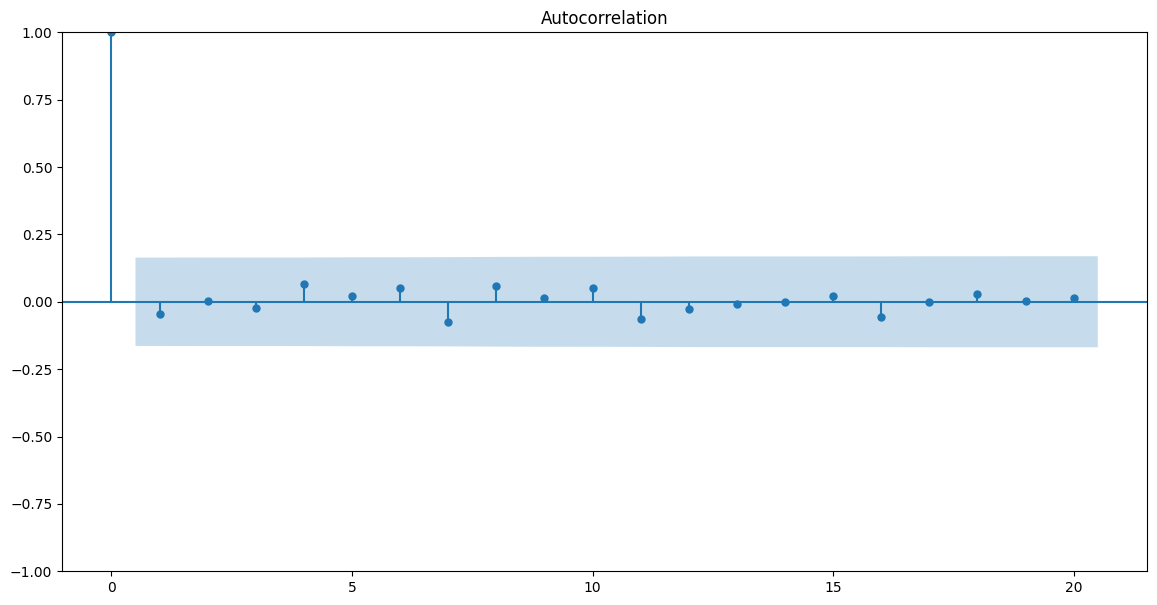

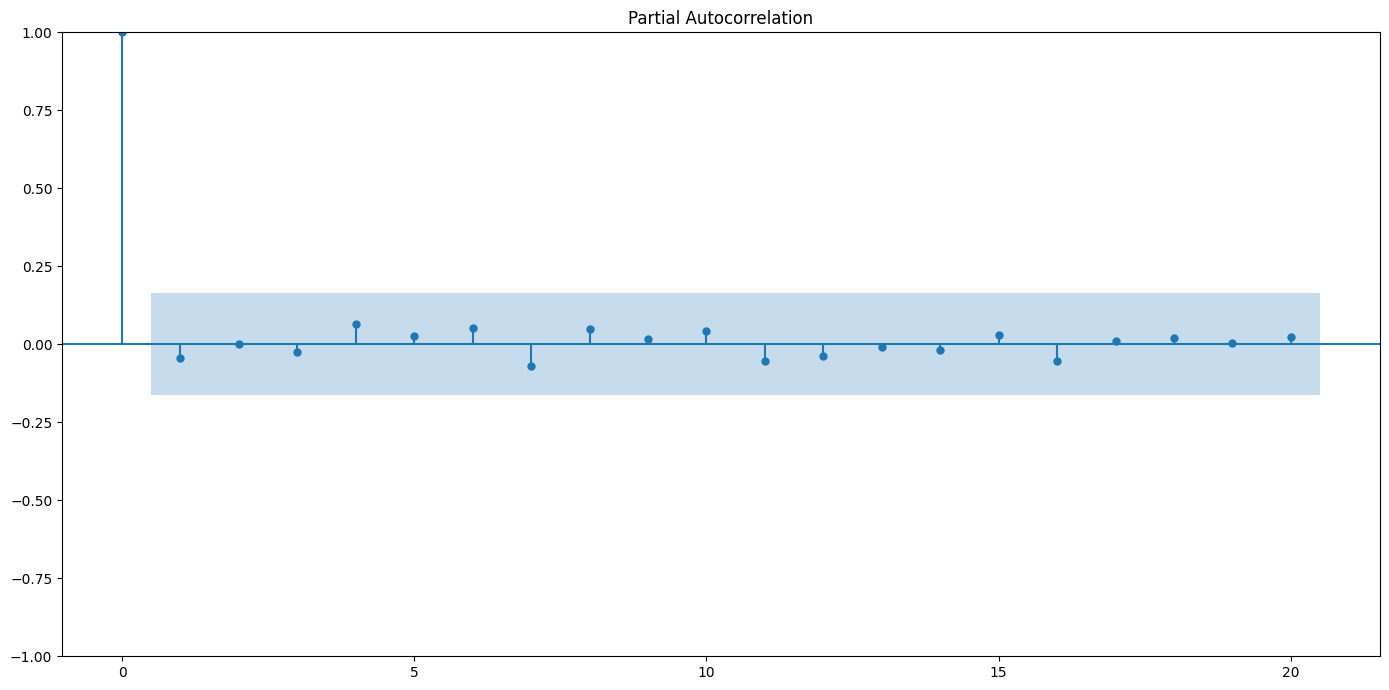

     lb_stat  lb_pvalue
10  3.443382   0.968986


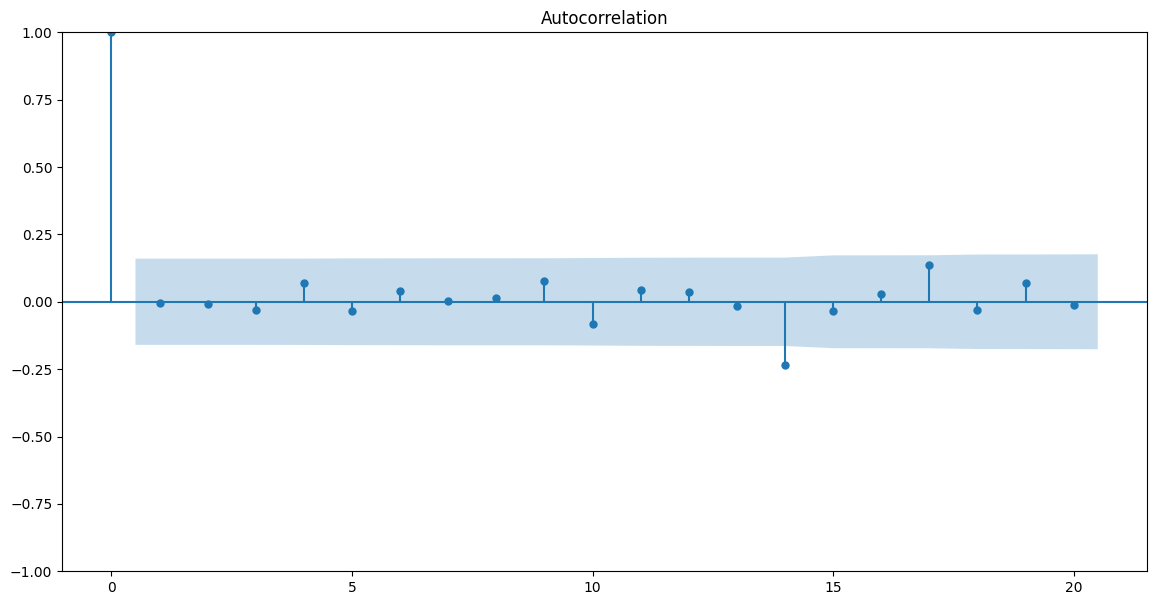

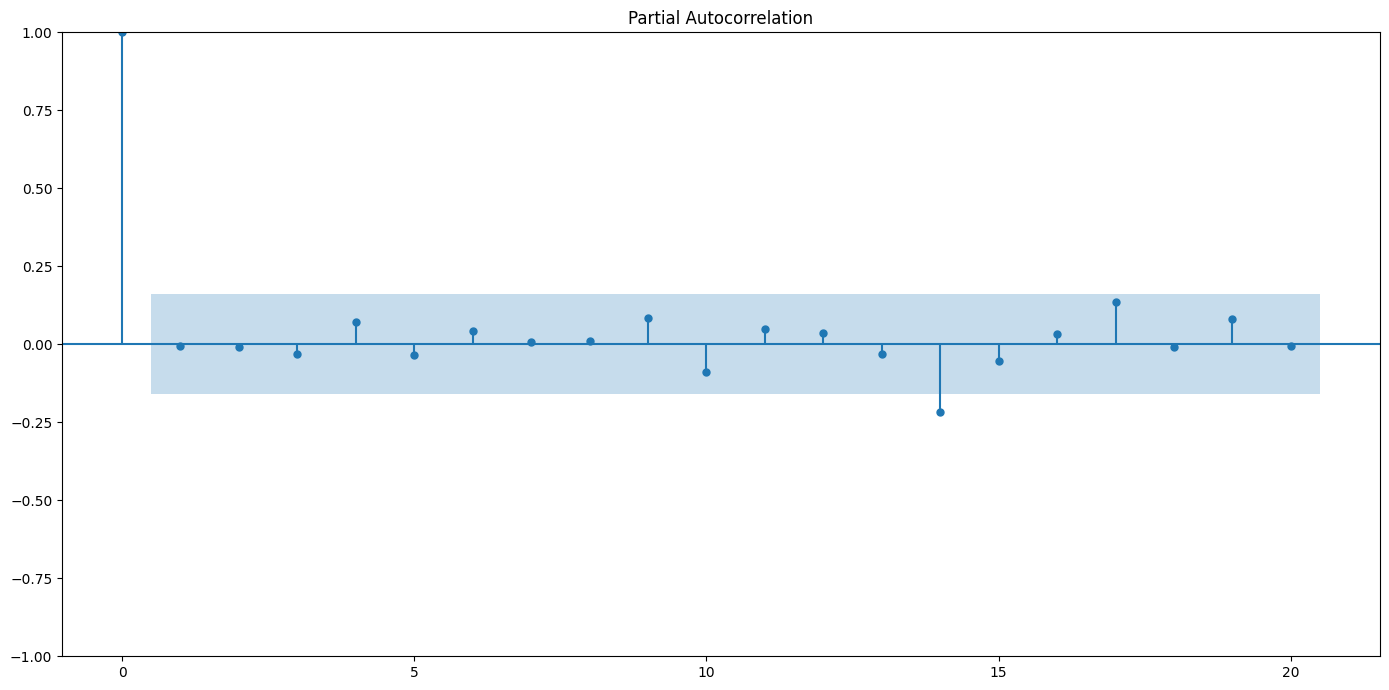

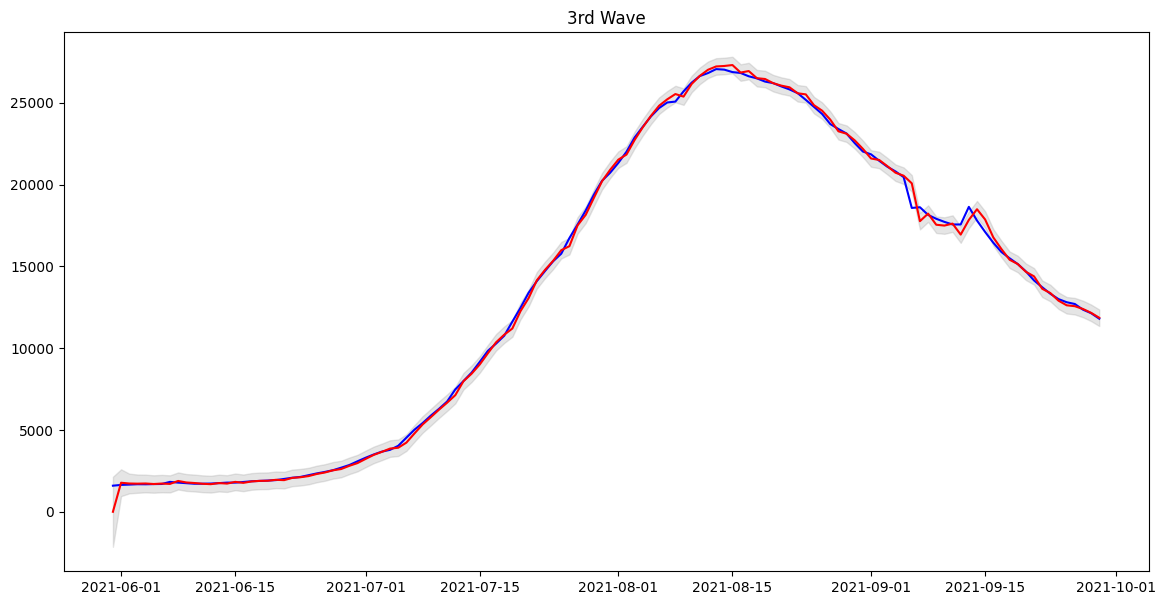

     lb_stat  lb_pvalue
10  3.086037   0.979326


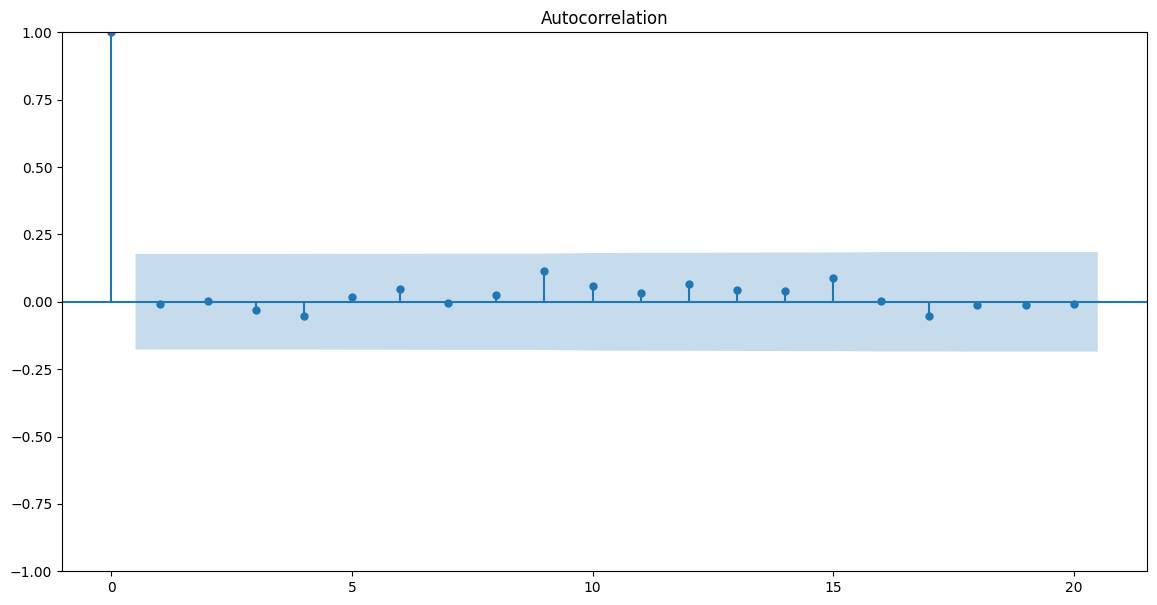

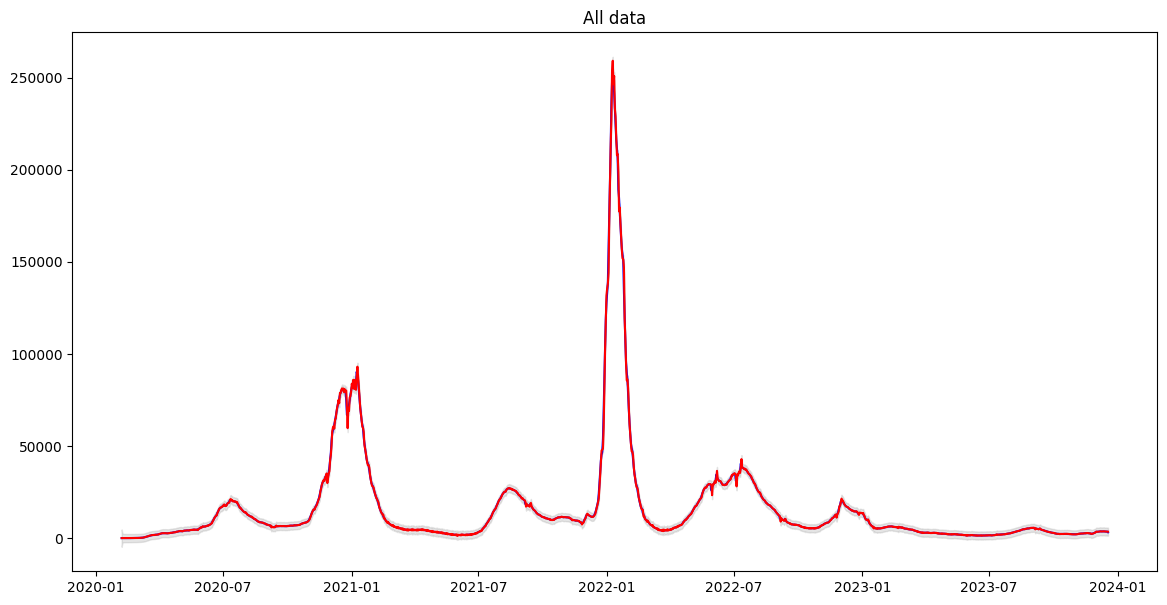

       lb_stat     lb_pvalue
10  108.543243  1.049071e-18


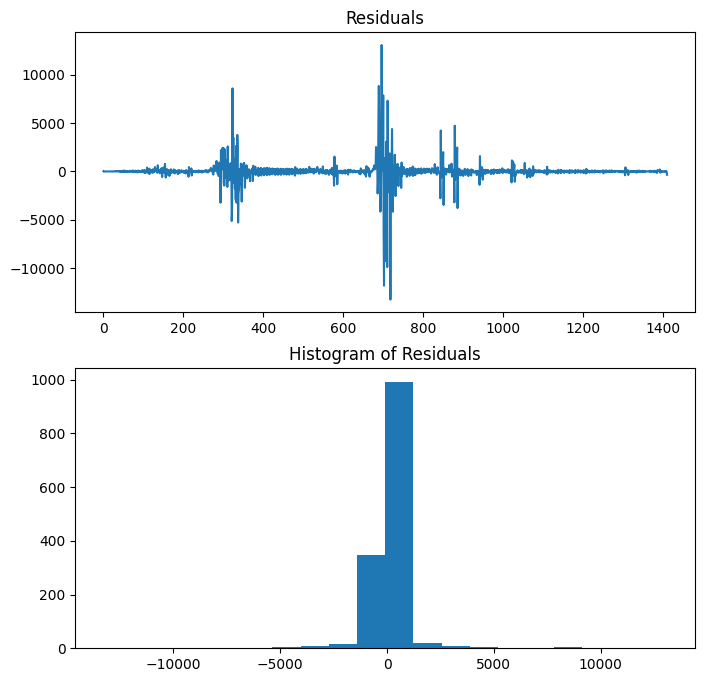

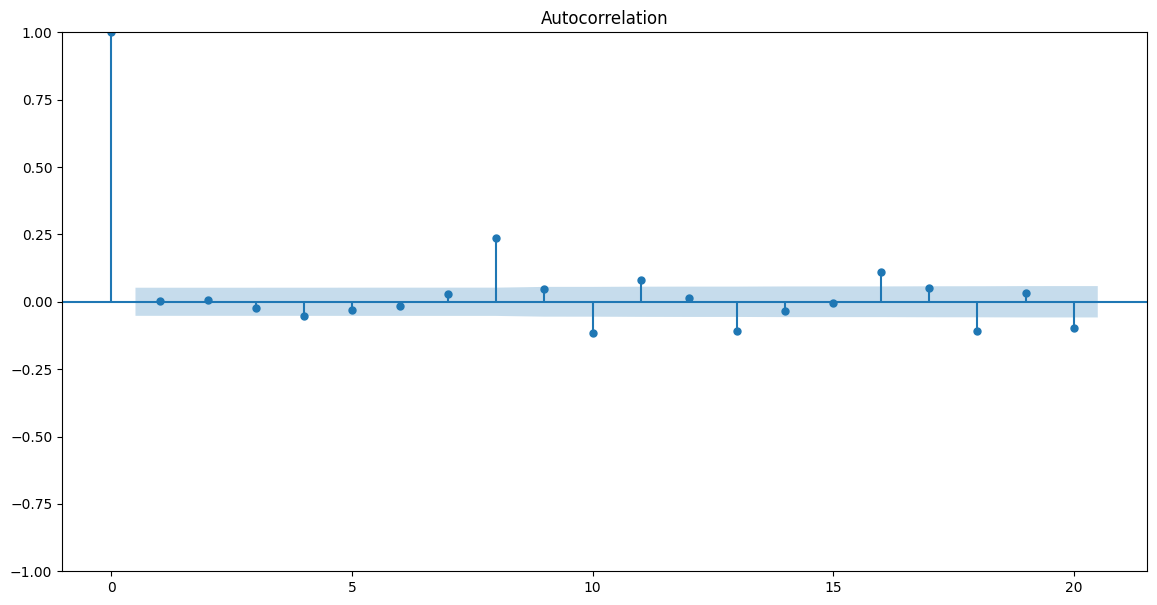

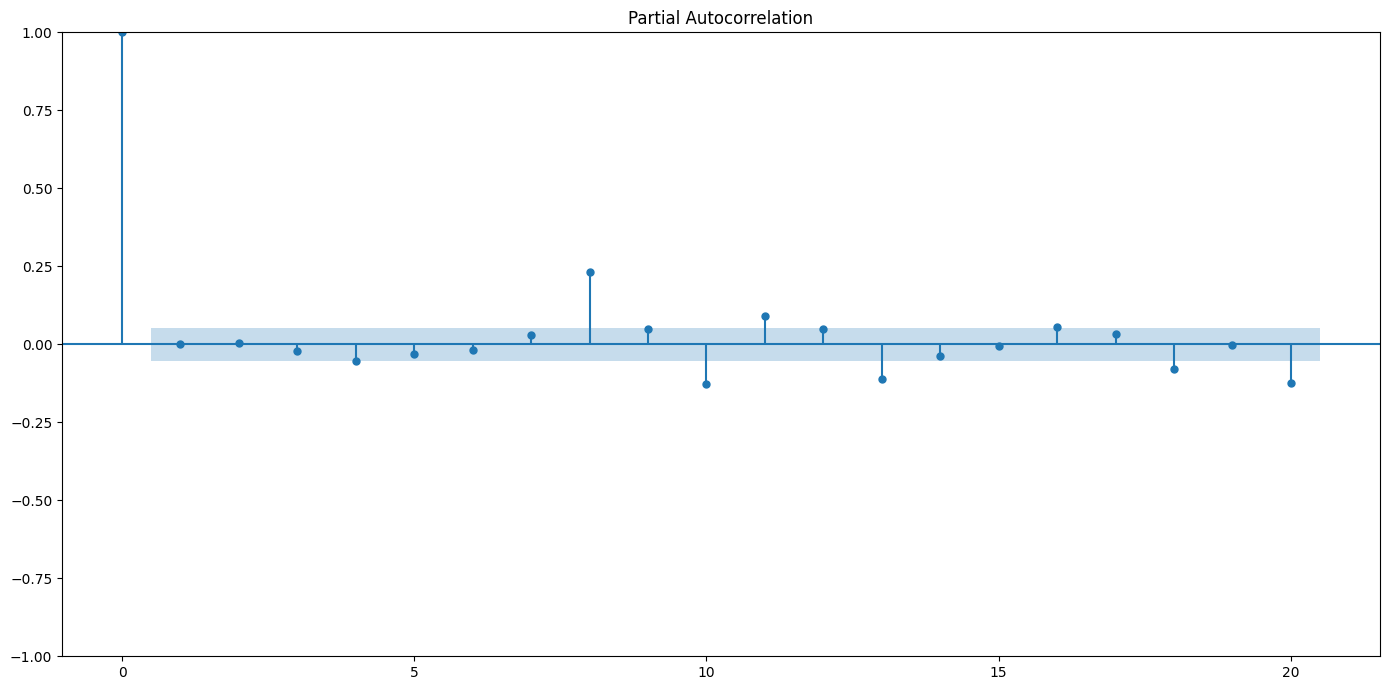

In [460]:
titles = ["1st Wave", "2nd Wave", "3rd Wave", "All data"]

for i, (start, end) in enumerate(splits):
    pred = best_models[i][1].get_prediction()
    pred_ci = pred.conf_int()
    lower_ci = pred_ci[:, 0]
    upper_ci = pred_ci[:, 1]
    plt.plot(pd.to_datetime(weekly_dates[start:end]), weekly_data["Confirmed"].values[start:end],color='b')
    plt.plot(pd.to_datetime(weekly_dates[start:end]), best_models[i][1].fittedvalues, color='r')
    plt.title(titles[i])
    plt.fill_between(pd.to_datetime(weekly_dates[start:end]), lower_ci, upper_ci, color='gray', alpha=0.2, label='Confidence Interval')
    plt.show()
    test_residuals(best_models[i][1].resid)

[(48, 191), (251, 401), (479, 601), (0, -1)]
48 191
251 401
479 601
0 -1
[(<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E7D04C9A0>, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024E7D04DED0>, (0.9988008025105739, 1814.4370045169837, 115.377187249608)), (<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E76E93520>, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024E7DF17430>, (0.9973225563054857, 12595.343818061607, 780.5569665959401)), (<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E76E93FD0>, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024E7DF16B90>, (0.9989366283022338, 2305.512765858549, 166.65927971879643)), (<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E786D09A0>, <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024E76E91A20>, (0.9987045225698398, 28183.516604439144, 337.5868112956044))]


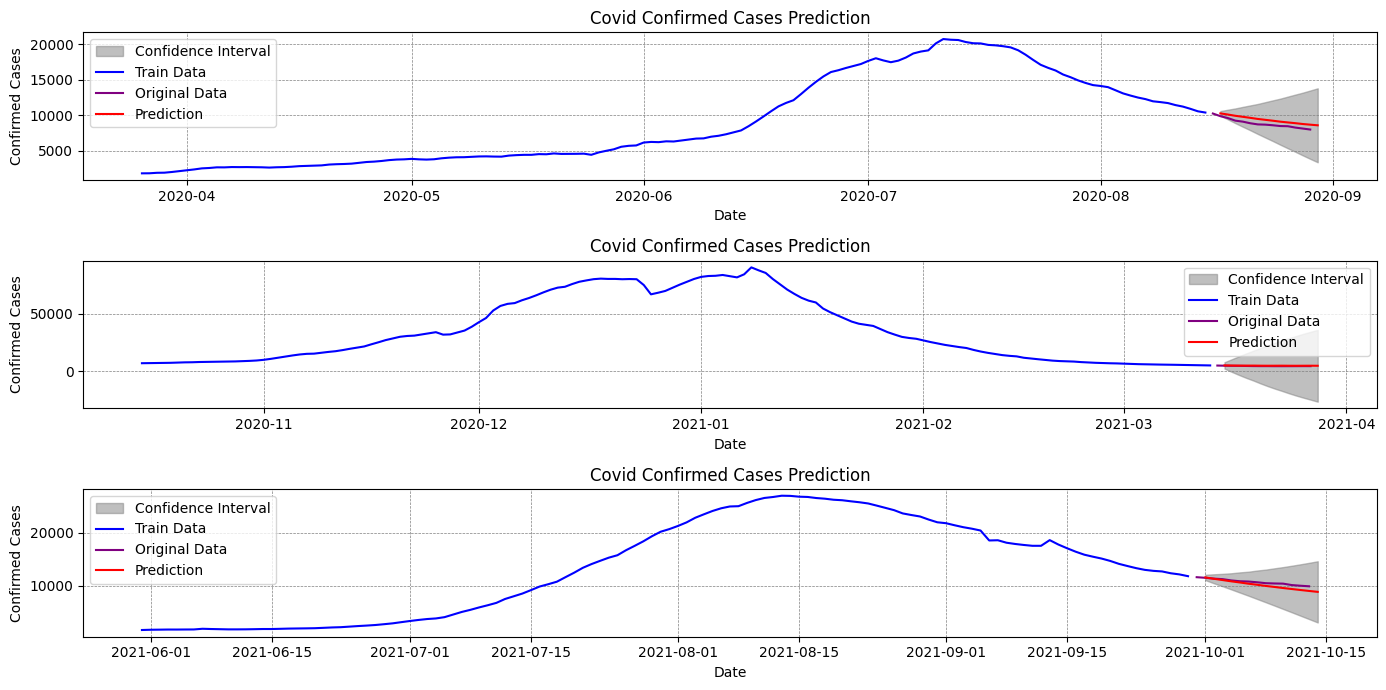

In [120]:
weekly_dates = dates[np.where(dates == "2020-02-07")[0][0]:]
splits = [
    (np.where(weekly_dates == '2020-03-26')[0][0], np.where(weekly_dates == '2020-08-16')[0][0]),
    (np.where(weekly_dates == '2020-10-15')[0][0], np.where(weekly_dates == '2021-03-14')[0][0]),
    (np.where(weekly_dates == '2021-05-31')[0][0], np.where(weekly_dates == '2021-09-30')[0][0]),
    (0, -1)
]
print(splits)
best_models = []
perf_data = dict()
for i, (start, end) in enumerate(splits):
    print(start, end)
    model, res, perf = test_data(weekly_data["Confirmed"].values[start:end], verbose=False, best=True)
    perf_data[i] = perf
    best_models.append((model, res, perf))

print(best_models)

titles = ["1st Wave", "2nd Wave", "3rd Wave"]
splits = [
    (np.where(weekly_dates == '2020-03-26')[0][0], np.where(weekly_dates == '2020-08-16')[0][0]),
    (np.where(weekly_dates == '2020-10-15')[0][0], np.where(weekly_dates == '2021-03-14')[0][0]),
    (np.where(weekly_dates == '2021-05-31')[0][0], np.where(weekly_dates == '2021-09-30')[0][0])
]
forwrd = 14
fig, ax = plt.subplots(3)
for i, (start, end) in enumerate(splits):
    fc=best_models[i][1].forecast(steps=forwrd)
    forecast = fc
    pred = best_models[i][1].get_forecast(steps=forwrd)
    pred_ci = pred.conf_int()
    lower_ci = pred_ci[:, 0]
    upper_ci = pred_ci[:, 1]

    date_range = pd.date_range(start=weekly_dates[end+1], periods=forwrd)

    # Prediction Plotting
    ax[i].fill_between(date_range, lower_ci, upper_ci, color='gray', alpha=0.5, label='Confidence Interval')
    ax[i].plot(pd.to_datetime(weekly_dates[start:end]), weekly_data["Confirmed"][start:end],color='b', label='Train Data')
    ax[i].plot(pd.to_datetime(weekly_dates[end:end+forwrd]), weekly_data["Confirmed"][end:end+forwrd],color='purple', label='Original Data')
    ax[i].plot(date_range, forecast, color='r', label='Prediction')
    ax[i].grid(color='gray', linestyle='--', linewidth=0.5)
    ax[i].legend(loc='best')
    ax[i].set_title('Covid Confirmed Cases Prediction')
    #ax.set_xlim(pd.to_datetime("2021-09-01"), pd.to_datetime("2022-09-01"))
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Confirmed Cases")
plt.tight_layout()
plt.show(block=False)

Looking at daily values is more unstable, predicting on smoothed last 7 days values is more stable and perhaps more useful.

In [121]:
daily_data = pd.DataFrame(added_data, index=pd.to_datetime(dates))
weekly_data = daily_data.resample('W').sum()
weekly_data

Confirmed  Deaths     Tests  Negatives
2020-02-02       68.0     0.0     200.0      132.0
2020-02-09      124.0     2.0    1288.0     1164.0
2020-02-16       86.0     0.0     398.0      312.0
2020-02-23      224.0     4.0     442.0      218.0
2020-03-01      634.0     0.0     862.0      228.0
...               ...     ...       ...        ...
2023-11-26    17334.0   254.0  266614.0   249280.0
2023-12-03    24010.0   262.0  327902.0   303892.0
2023-12-10    25488.0   230.0  342770.0   317282.0
2023-12-17    24638.0    68.0  343352.0   318714.0
2023-12-24     2178.0     0.0   19592.0    17414.0

[204 rows x 4 columns]

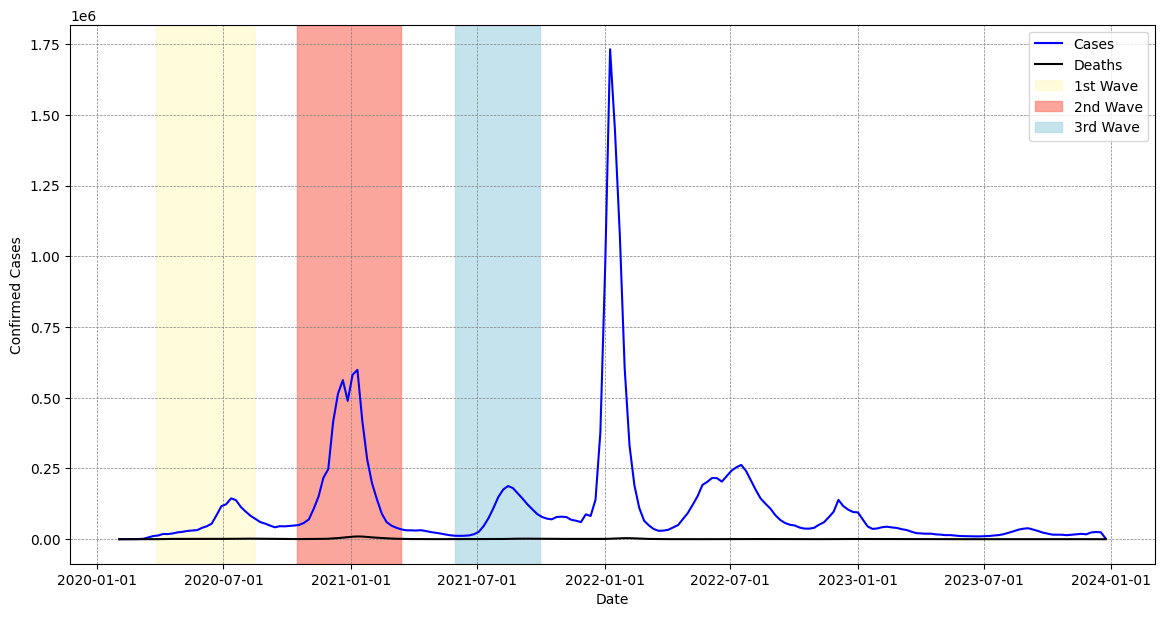

In [88]:
from matplotlib.dates import DateFormatter, AutoDateLocator
weekly_dates = weekly_data.index
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(weekly_dates), weekly_data["Confirmed"], color="blue", label="Cases")
ax.plot(pd.to_datetime(weekly_dates), weekly_data["Deaths"], color="black", label="Deaths")
#plt.plot(dates, added_data["Tests"], color="purple", label="Tests")
#plt.plot(dates, added_data["Negatives"], color="red", label="Negatives")
locator = AutoDateLocator()
formatter = DateFormatter('%Y-%m-%d')

shade_ranges = [
    (pd.Timestamp('2020-03-26'), pd.Timestamp('2020-08-16'),"lemonchiffon","1st Wave"),
    (pd.Timestamp('2020-10-15'), pd.Timestamp('2021-03-14'),"salmon","2nd Wave"),
    (pd.Timestamp('2021-05-31'), pd.Timestamp('2021-09-30'),"lightblue","3rd Wave")
]

for shade_start, shade_end, color, name in shade_ranges:
    plt.axvspan(shade_start, shade_end, color=color, alpha=0.7, label=name)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Confirmed Cases")
ax.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [63]:
weekly_dates = weekly_data.index
splits = [
    (np.where(weekly_dates == '2020-03-22T00:00:00.000000000')[0][0], np.where(weekly_dates == '2020-08-16T00:00:00.000000000')[0][0]),
    (np.where(weekly_dates == '2020-10-18T00:00:00.000000000')[0][0], np.where(weekly_dates == '2021-03-14T00:00:00.000000000')[0][0]),
    (np.where(weekly_dates == '2021-05-30T00:00:00.000000000')[0][0], np.where(weekly_dates == '2021-09-26T00:00:00.000000000')[0][0]),
    (0, -1)
]

best_models = []
perf_data = dict()
for i, (start, end) in enumerate(splits):
    print(start, end)
    model, res, perf, names = test_data(weekly_data["Confirmed"].values[start:end], exog=weekly_data["Deaths"].values[start:end], verbose=False, best=False)
    perf_data[i] = (perf, names)
    best_models.append((model, res, perf))

print(best_models)

7 28
37 58
69 86
0 -1
[([<statsmodels.tsa.arima.model.ARIMA object at 0x0000024E24944FA0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E249476D0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278EE950>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278EF490>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278EF820>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278EFDC0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278EFC70>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E22B17310>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E22B17E80>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E22B17760>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E22B17EB0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E22B171C0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278F93F0>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000024E278F9840>, <statsmodels.tsa.arima.model.ARIMA object at 0x0000

In [64]:
waves_split = ["1st Wave", "2nd Wave", "3rd Wave", "All data"]
perf_data2 = {waves_split[x]: perf_data[x] for x in perf_data} #R2, RMSE, MAE

def process_df(name):
    df_1st = pd.DataFrame()
    df_1st["Names"] = perf_data2[name][1]
    df_1st["R2"] = perf_data2[name][0][0]
    df_1st["RMSE"] = perf_data2[name][0][1]
    df_1st["MAE"] = perf_data2[name][0][2]
    df_1st.drop(0,inplace=True)
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("ARI\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("^IMA\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("ARIX\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("^IMAX\(", regex=True)]
    df_1st = df_1st.loc[~df_1st['Names'].str.contains("^X\(", regex=True)]
    return df_1st

df_1st = process_df("1st Wave")
df_2nd = process_df("2nd Wave")
df_3rd4th = process_df("3rd Wave")
df_all = process_df("All data")

# Merge the DataFrames on 'Names'
merged_df = df_1st.merge(df_2nd, on='Names', how='outer', suffixes=(' 1st Wave', ' 2nd Wave'))
merged_df = merged_df.merge(df_3rd4th, on='Names', how='outer', suffixes=('', ' 3rd+4th Wave'))
merged_df = merged_df.merge(df_all, on='Names', how='outer', suffixes=('', ' All Data'))
merged_df.rename({'R2':'R2 3rd+4th Wave', 'RMSE' :'RMSE 3rd+4th Wave', 'MAE':'MAE 3rd+4th Wave'},axis=1,inplace=True)
merged_df.to_csv("./performances_weekly.csv")

In [65]:
merged_df.columns

Index(['Names', 'R2 1st Wave', 'RMSE 1st Wave', 'MAE 1st Wave', 'R2 2nd Wave',
       'RMSE 2nd Wave', 'MAE 2nd Wave', 'R2 3rd+4th Wave', 'RMSE 3rd+4th Wave',
       'MAE 3rd+4th Wave', 'R2 All Data', 'RMSE All Data', 'MAE All Data'],
      dtype='object')

In [66]:
print("R2")
print(merged_df["R2 1st Wave"].max(),merged_df[merged_df["R2 1st Wave"]==merged_df["R2 1st Wave"].max()]["Names"].values[0])
print(merged_df["R2 2nd Wave"].max(),merged_df[merged_df["R2 2nd Wave"]==merged_df["R2 2nd Wave"].max()]["Names"].values[0])
print(merged_df["R2 3rd+4th Wave"].max(),merged_df[merged_df["R2 3rd+4th Wave"]==merged_df["R2 3rd+4th Wave"].max()]["Names"].values[0])
print(merged_df["R2 All Data"].max(),merged_df[merged_df["R2 All Data"]==merged_df["R2 All Data"].max()]["Names"].values[0])
print("RMSE")
print(merged_df["RMSE 1st Wave"].max(),merged_df[merged_df["RMSE 1st Wave"]==merged_df["RMSE 1st Wave"].max()]["Names"].values[0])
print(merged_df["RMSE 2nd Wave"].max(),merged_df[merged_df["RMSE 2nd Wave"]==merged_df["RMSE 2nd Wave"].max()]["Names"].values[0])
print(merged_df["RMSE 3rd+4th Wave"].max(),merged_df[merged_df["RMSE 3rd+4th Wave"]==merged_df["RMSE 3rd+4th Wave"].max()]["Names"].values[0])
print(merged_df["RMSE All Data"].max(),merged_df[merged_df["RMSE All Data"]==merged_df["RMSE All Data"].max()]["Names"].values[0])
print("MAE")
print(merged_df["MAE 1st Wave"].max(),merged_df[merged_df["MAE 1st Wave"]==merged_df["MAE 1st Wave"].max()]["Names"].values[0])
print(merged_df["MAE 2nd Wave"].max(),merged_df[merged_df["MAE 2nd Wave"]==merged_df["MAE 2nd Wave"].max()]["Names"].values[0])
print(merged_df["MAE 3rd+4th Wave"].max(),merged_df[merged_df["MAE 3rd+4th Wave"]==merged_df["MAE 3rd+4th Wave"].max()]["Names"].values[0])
print(merged_df["MAE All Data"].max(),merged_df[merged_df["MAE All Data"]==merged_df["MAE All Data"].max()]["Names"].values[0])


R2
0.9662004513397686 ARIMAX(4,1,4)
0.9440389194928042 ARMAX(4,0,3)
0.9937835328748592 ARIMA(4,1,3)
0.898388635487256 ARMAX(4,0,4)
RMSE
84010.65789070327 MA(0,0,1)
398998.0090887877 MA(0,0,1)
115146.65431280149 MA(0,0,1)
1214215.5714028962 MA(0,0,1)
MAE
22491.243246972317 MA(0,0,1)
103881.51619550755 MA(0,0,1)
34366.064102434975 MA(0,0,1)
62279.53524583618 MA(0,0,1)


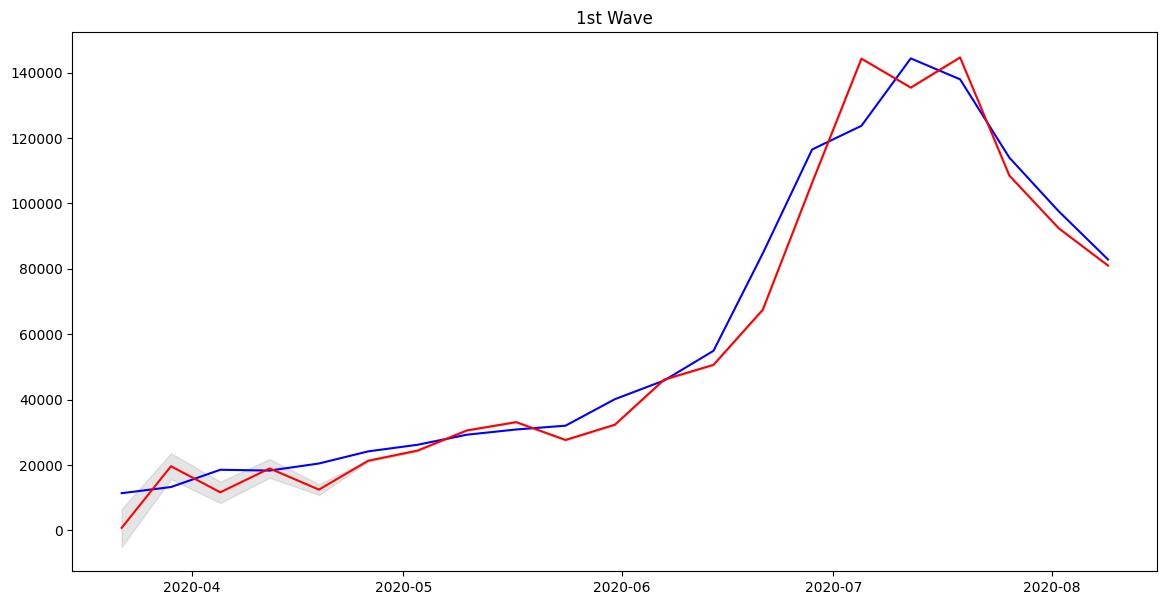

    lb_stat  lb_pvalue
10  3.52916   0.966099


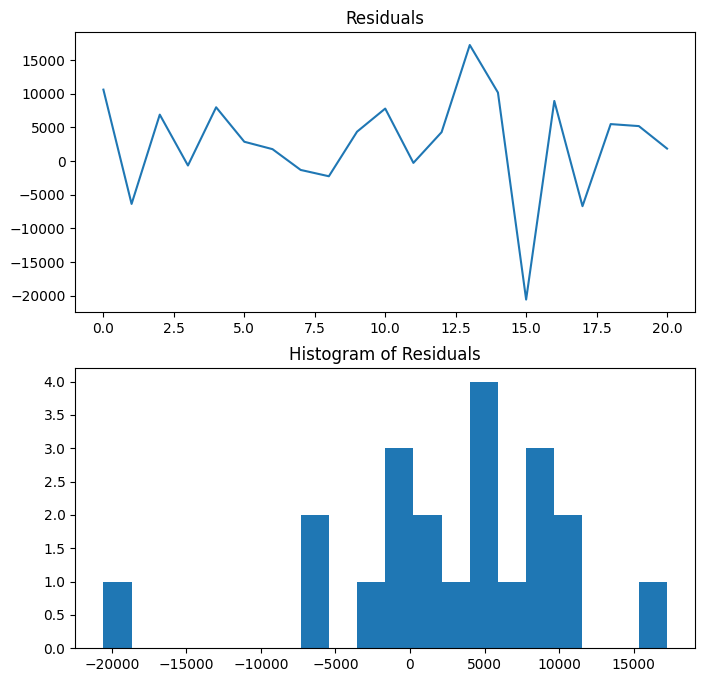

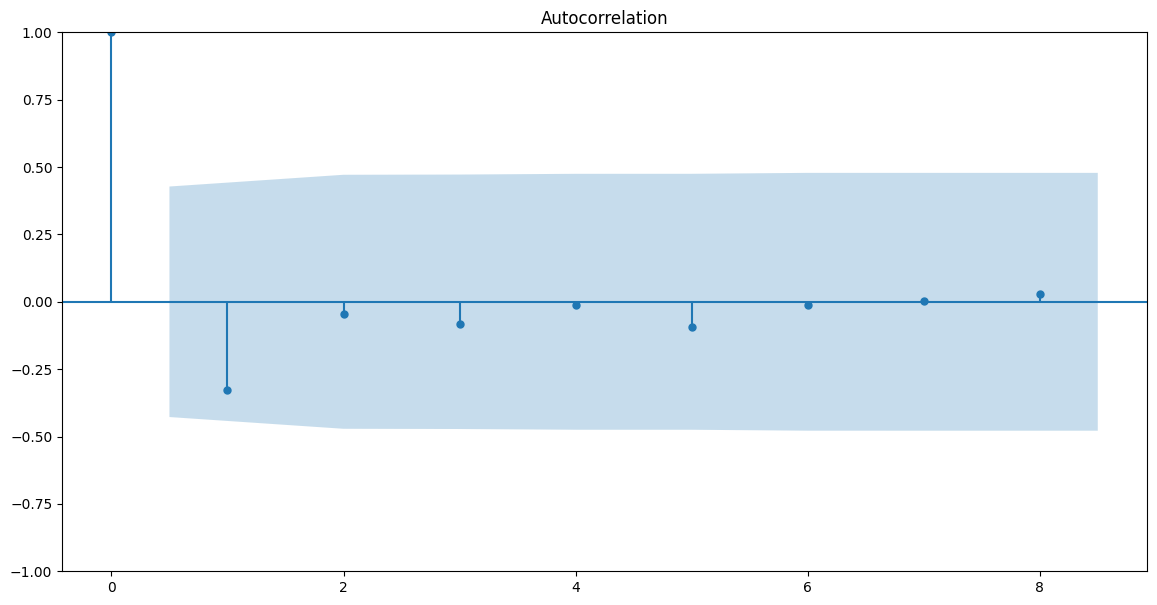

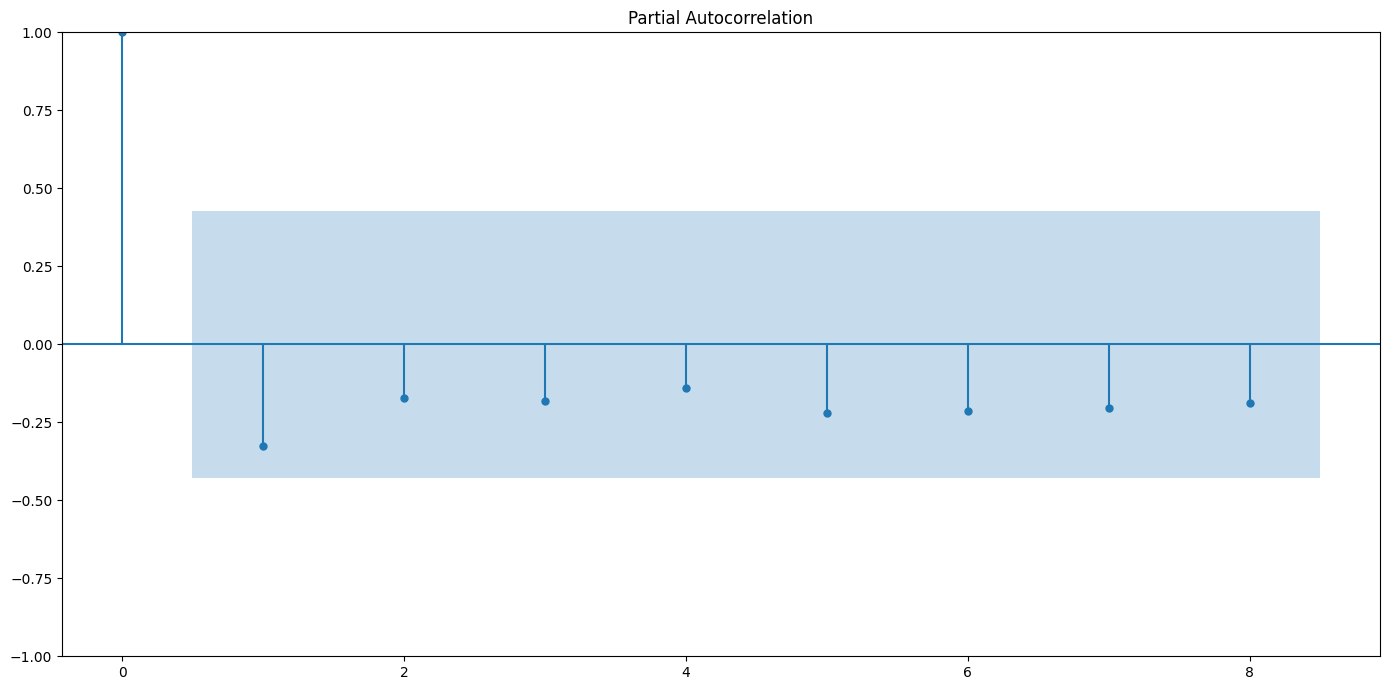

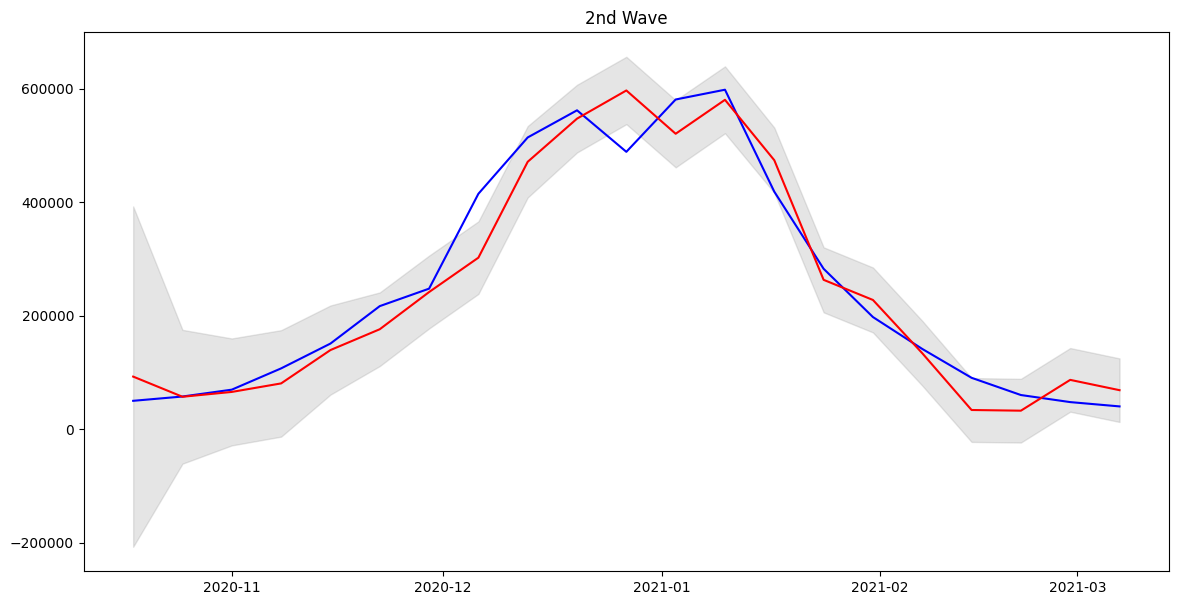

    lb_stat  lb_pvalue
10  9.29777   0.504097


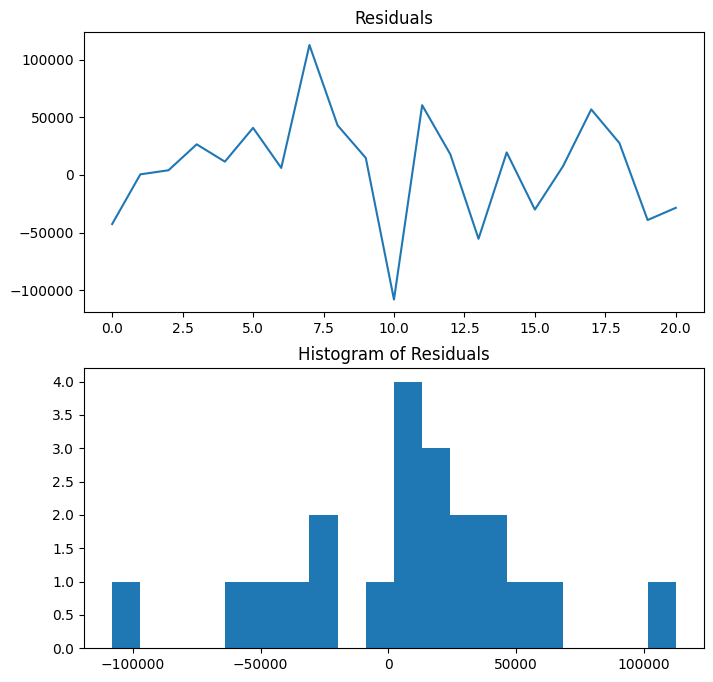

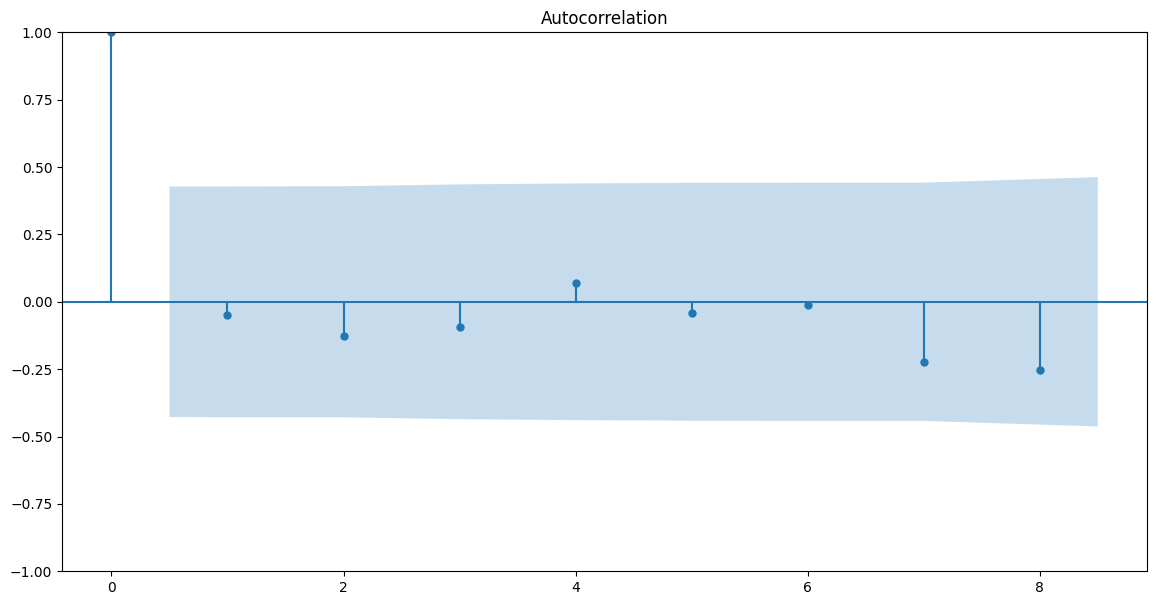

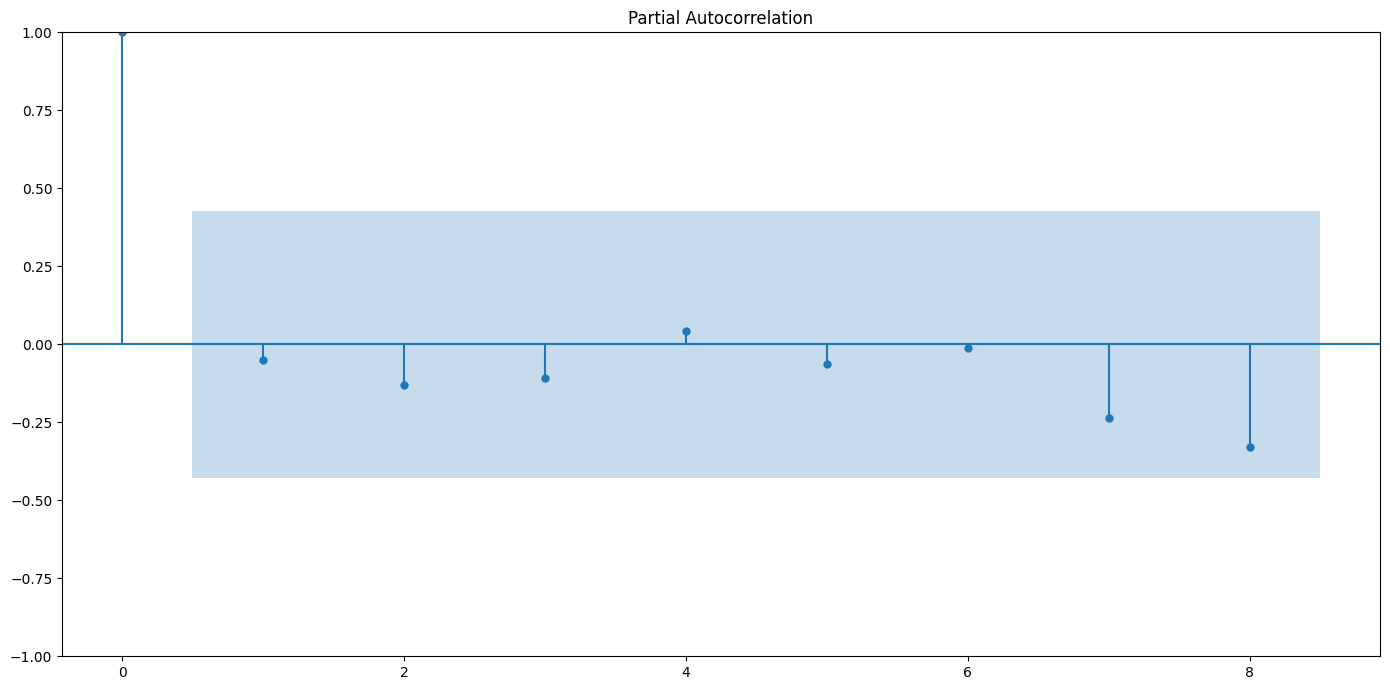

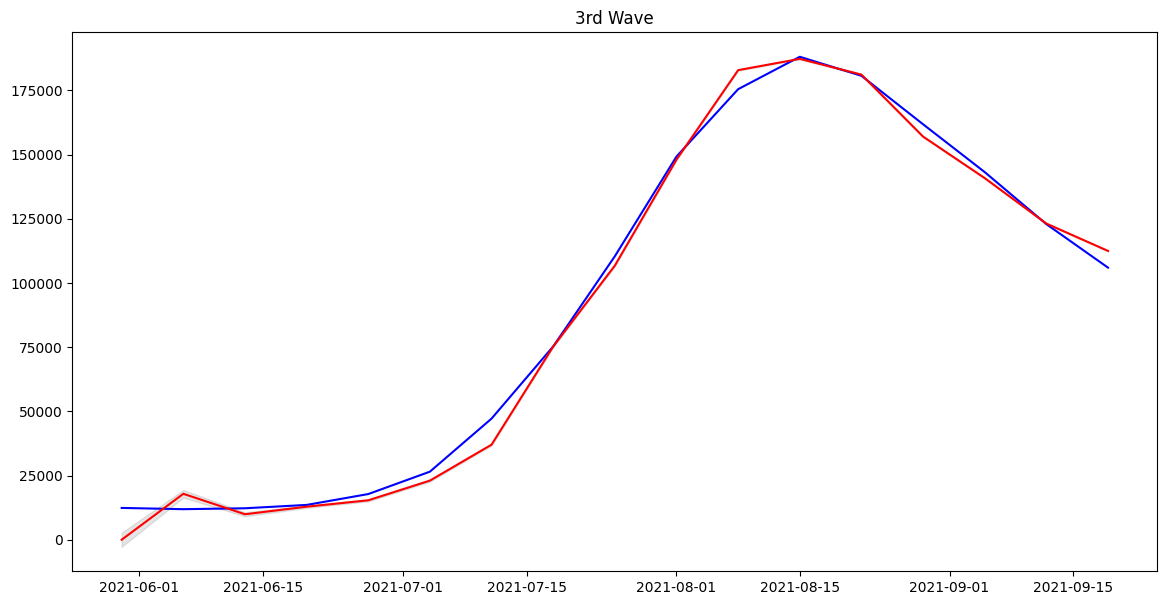

     lb_stat  lb_pvalue
10  13.78861   0.182854


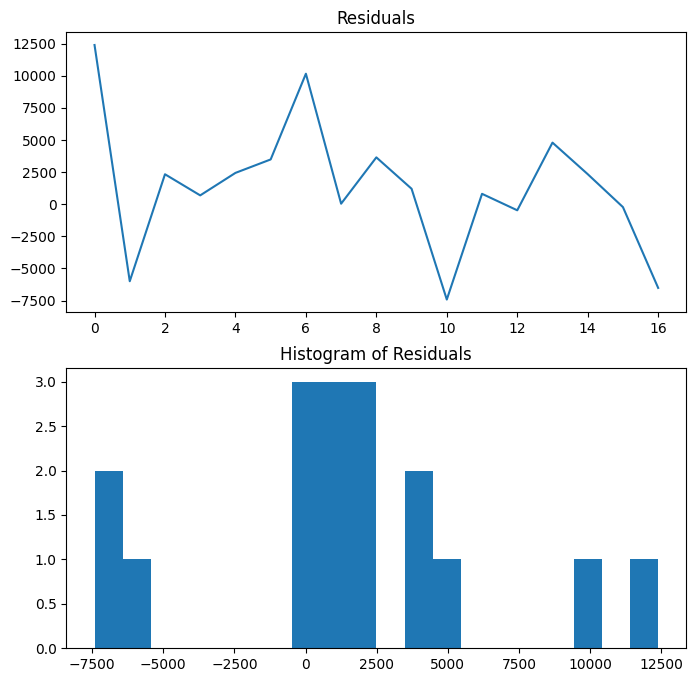

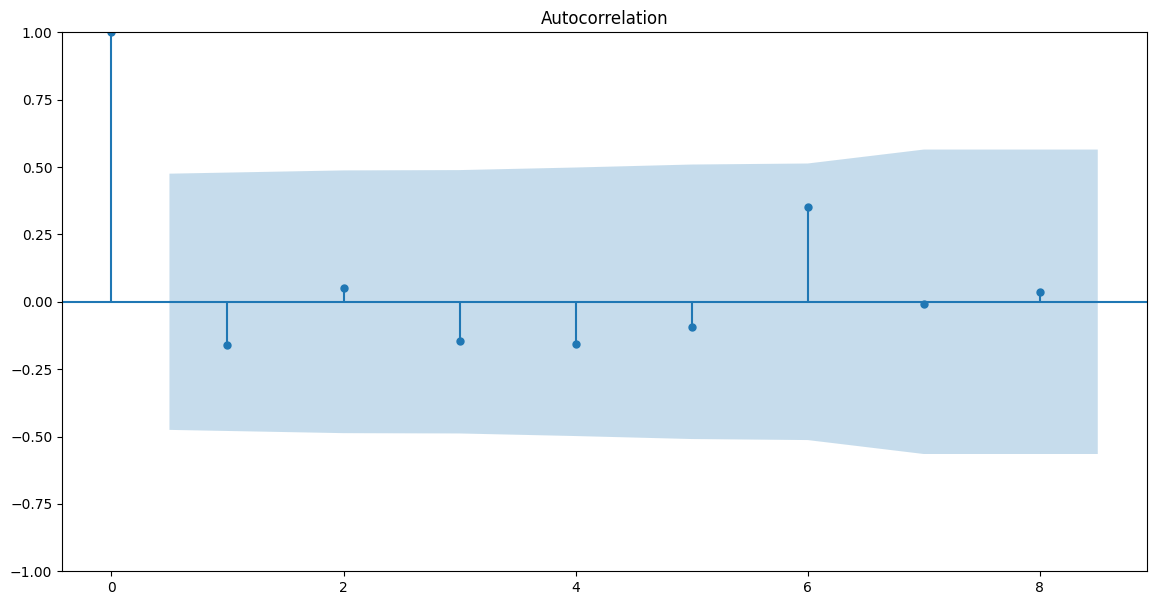

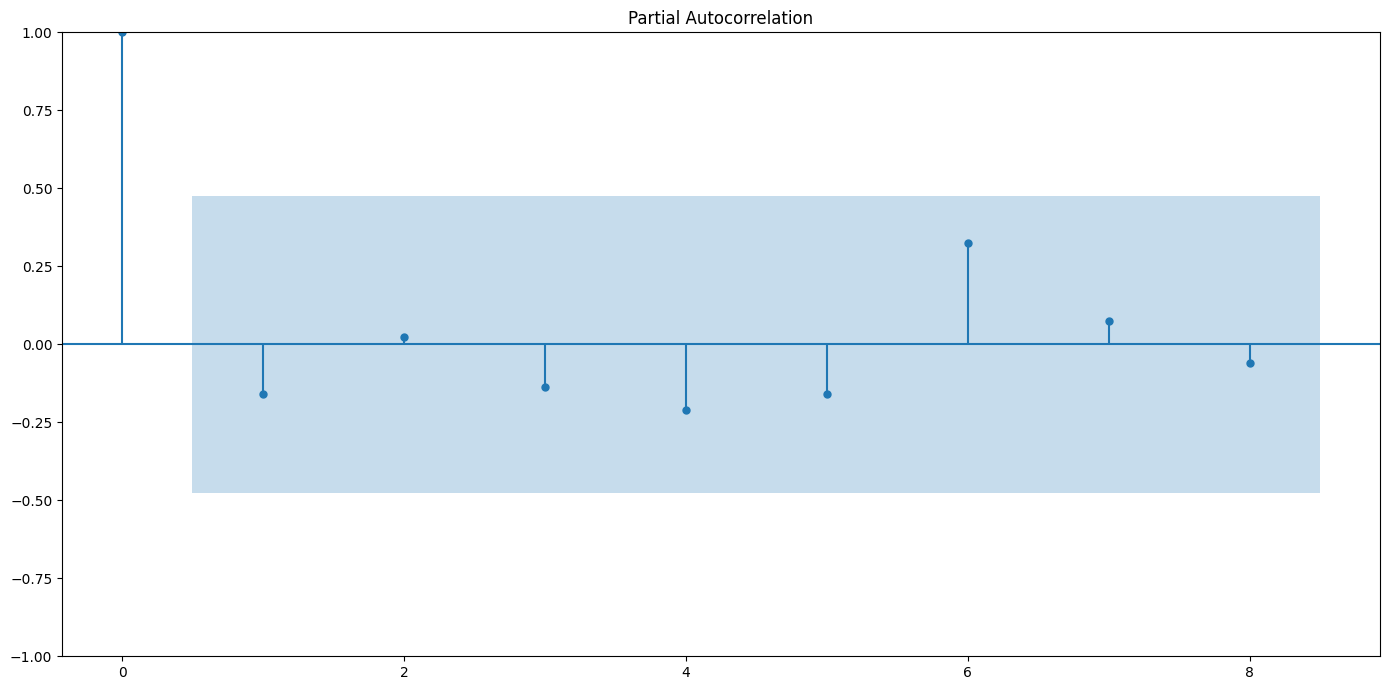

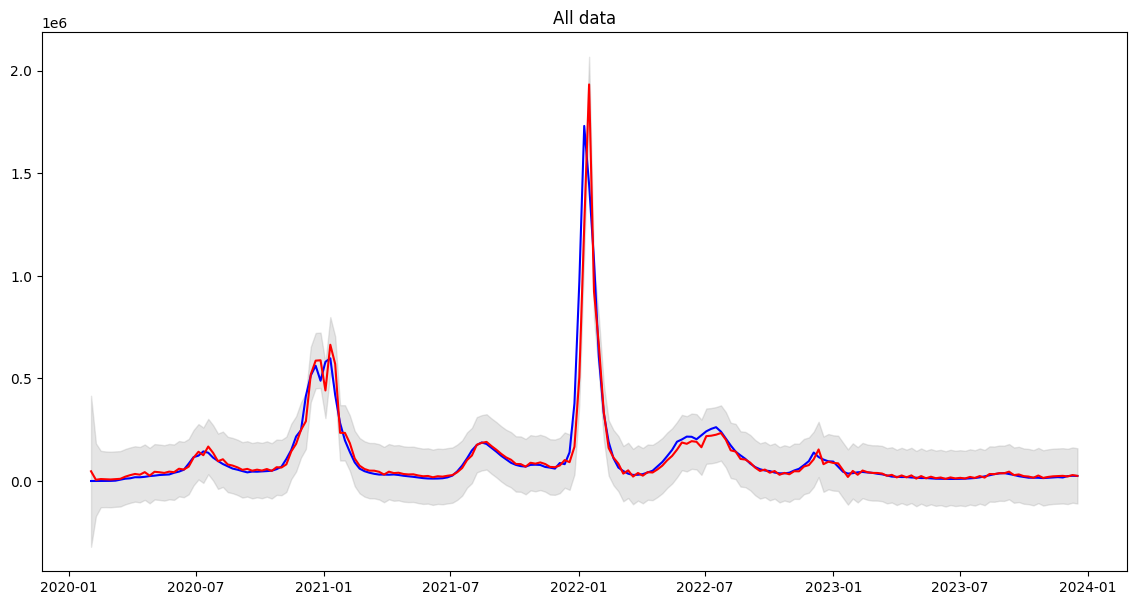

     lb_stat  lb_pvalue
10  0.167372        1.0


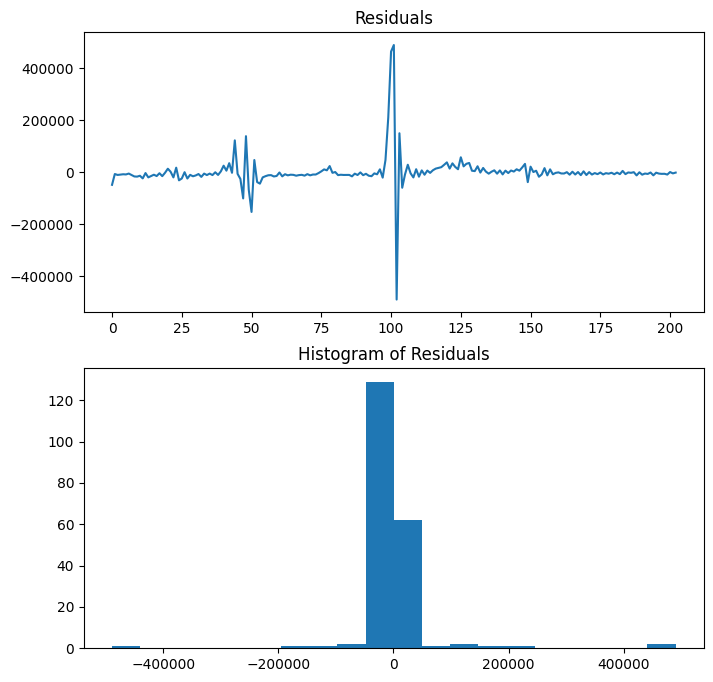

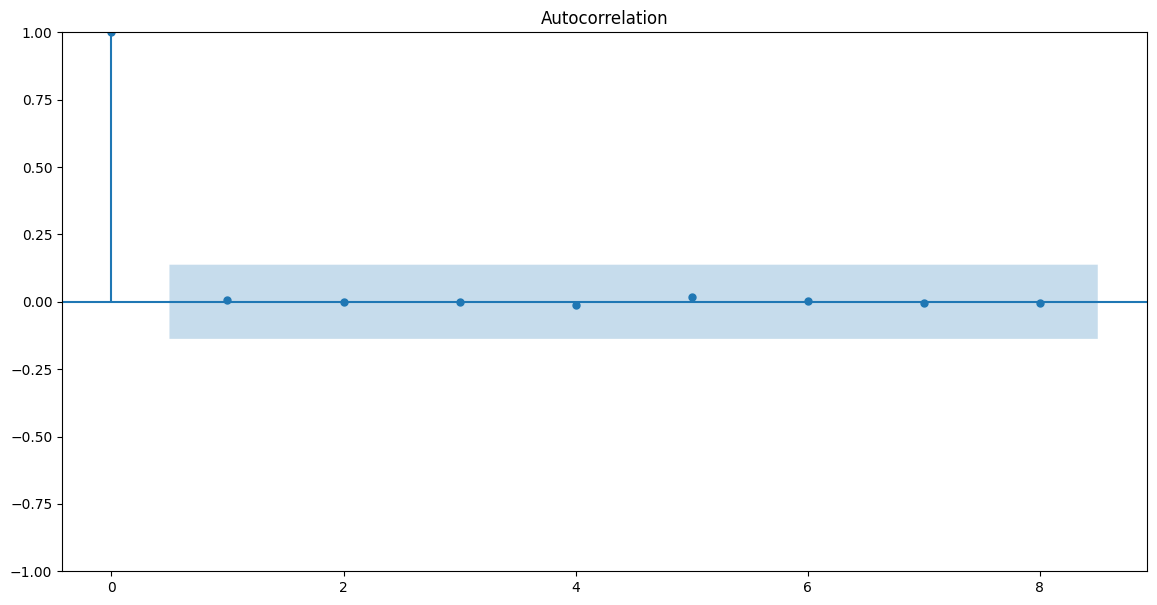

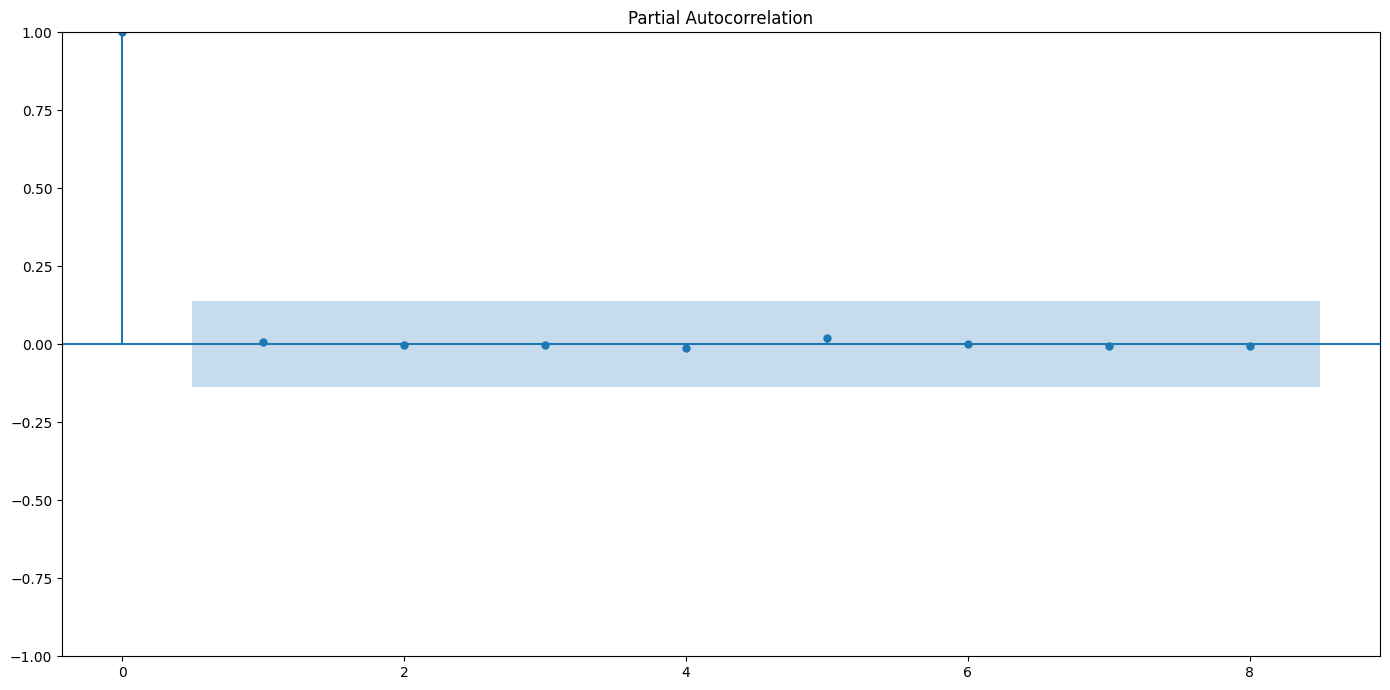

In [480]:
titles = ["1st Wave", "2nd Wave", "3rd Wave", "All data"]

for i, (start, end) in enumerate(splits):
    pred = best_models[i][1].get_prediction()
    pred_ci = pred.conf_int()
    lower_ci = pred_ci[:, 0]
    upper_ci = pred_ci[:, 1]
    plt.plot(pd.to_datetime(weekly_dates[start:end]), weekly_data["Confirmed"].values[start:end],color='b')
    plt.plot(pd.to_datetime(weekly_dates[start:end]), best_models[i][1].fittedvalues, color='r')
    plt.title(titles[i])
    plt.fill_between(pd.to_datetime(weekly_dates[start:end]), lower_ci, upper_ci, color='gray', alpha=0.2, label='Confidence Interval')
    plt.show()
    test_residuals(best_models[i][1].resid, lags=8)

Lastly, I also tried the data on a weekly sample basis.

### LSTMs

In [74]:
def test_lstm(data):
    data_lstm = data.reshape(-1, 1)
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_lstm)

    # Create sequences
    def create_sequences(data, seq_length):
        xs = []
        ys = []
        for i in range(len(data) - seq_length):
            x = data[i:i + seq_length]
            y = data[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    seq_length = 50
    X, y = create_sequences(scaled_data, seq_length)

    # Split into training and testing data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
    
    y_pred = model.predict(X)
    y_inv = scaler.inverse_transform(y.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    residuals = y_inv - y_pred_inv
    # Plot the residuals
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals of LSTM Model')
    plt.legend()
    plt.show()

    plt.plot(y_inv, label='Actual Values')
    plt.plot(y_pred_inv, label='Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    test_residuals(residuals)
    plt.show()
    return model


54 197
Epoch 1/20
3/3 [==============================] - 2s 242ms/step - loss: 0.2298 - val_loss: 0.1902
Epoch 2/20
3/3 [==============================] - 0s 24ms/step - loss: 0.1415 - val_loss: 0.0545
Epoch 3/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0597 - val_loss: 0.0957
Epoch 4/20
3/3 [==============================] - 0s 23ms/step - loss: 0.0397 - val_loss: 0.2630
Epoch 5/20
3/3 [==============================] - 0s 23ms/step - loss: 0.0556 - val_loss: 0.1032
Epoch 6/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0296 - val_loss: 0.0435
Epoch 7/20
3/3 [==============================] - 0s 23ms/step - loss: 0.0321 - val_loss: 0.0357
Epoch 8/20
3/3 [==============================] - 0s 23ms/step - loss: 0.0323 - val_loss: 0.0430
Epoch 9/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0295 - val_loss: 0.0575
Epoch 10/20
3/3 [==============================] - 0s 23ms/step - loss: 0.0276 - val_loss: 0.0799
Epoch 11/20
3/3 [====

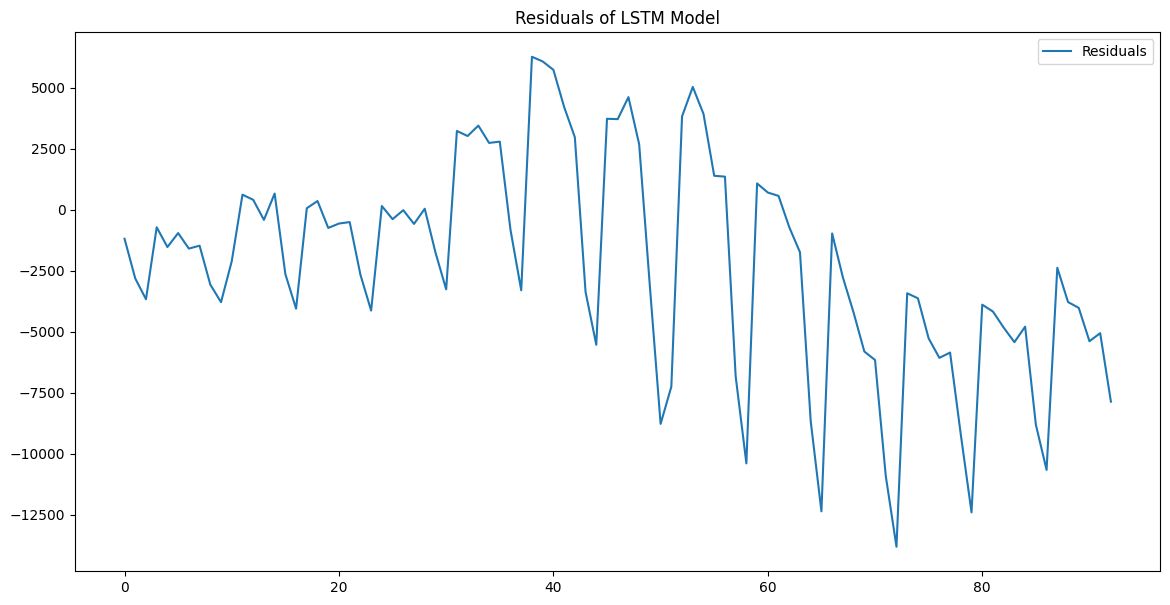

       lb_stat     lb_pvalue
10  189.114286  2.988720e-35


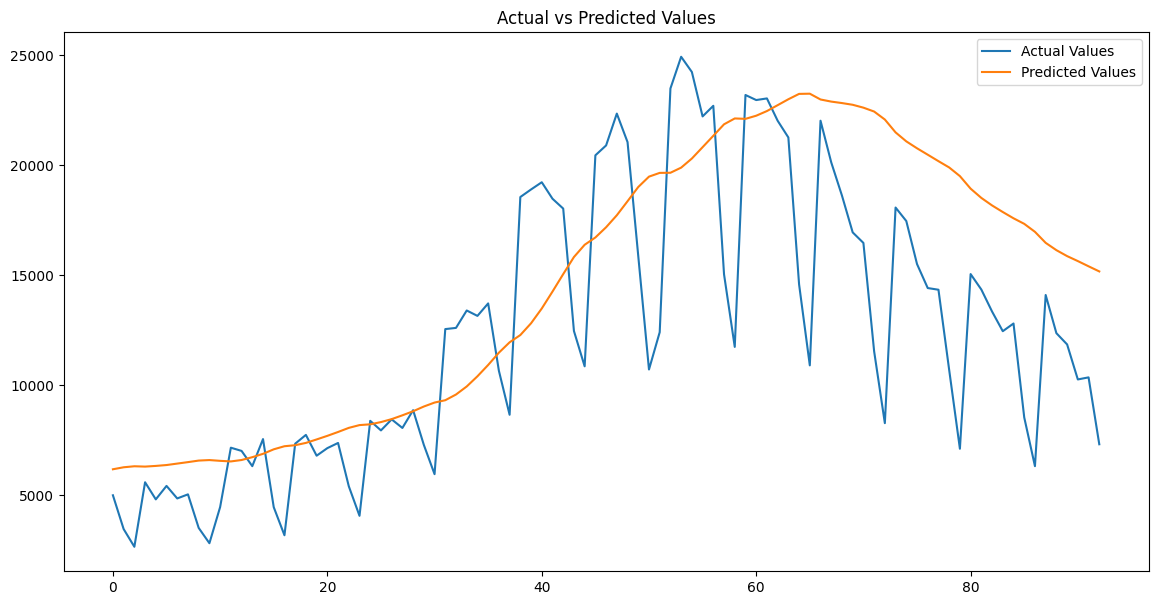

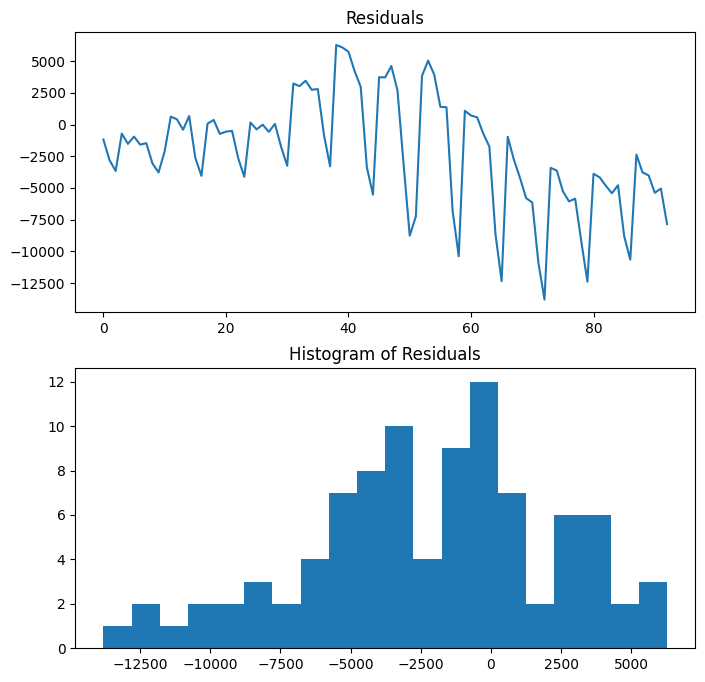

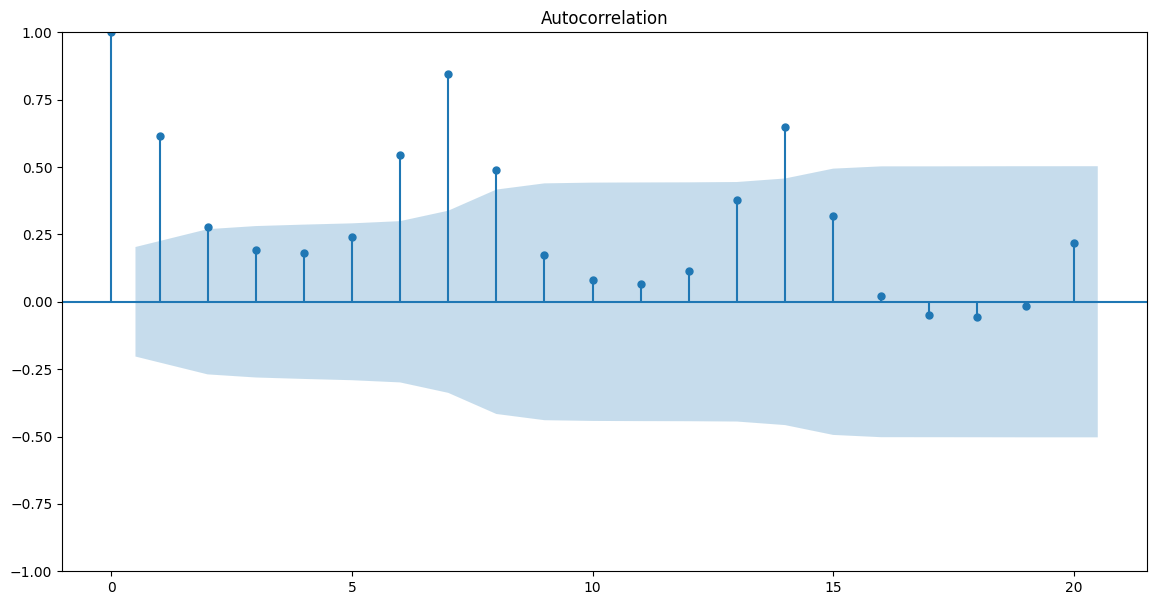

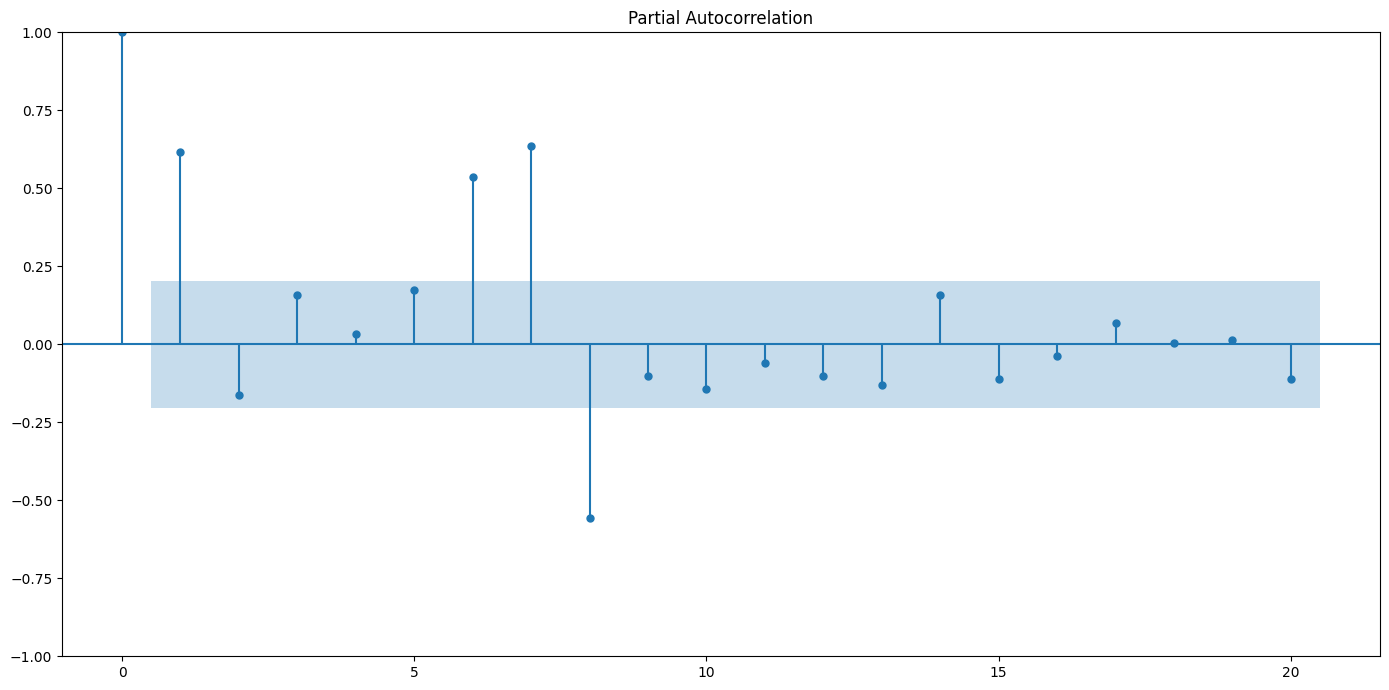

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -2542.283
Date:                Thu, 13 Jun 2024   AIC                           5106.566
Time:                        15:54:00   BIC                           5143.011
Sample:                             0   HQIC                          5121.310
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.758e+04   8.98e+04      0.530      0.596   -1.28e+05    2.24e+05
x1            55.7477     21.022      2.652      0.008      14.546      96.949
ar.L1          1.0796      0.682      1.583      0.1

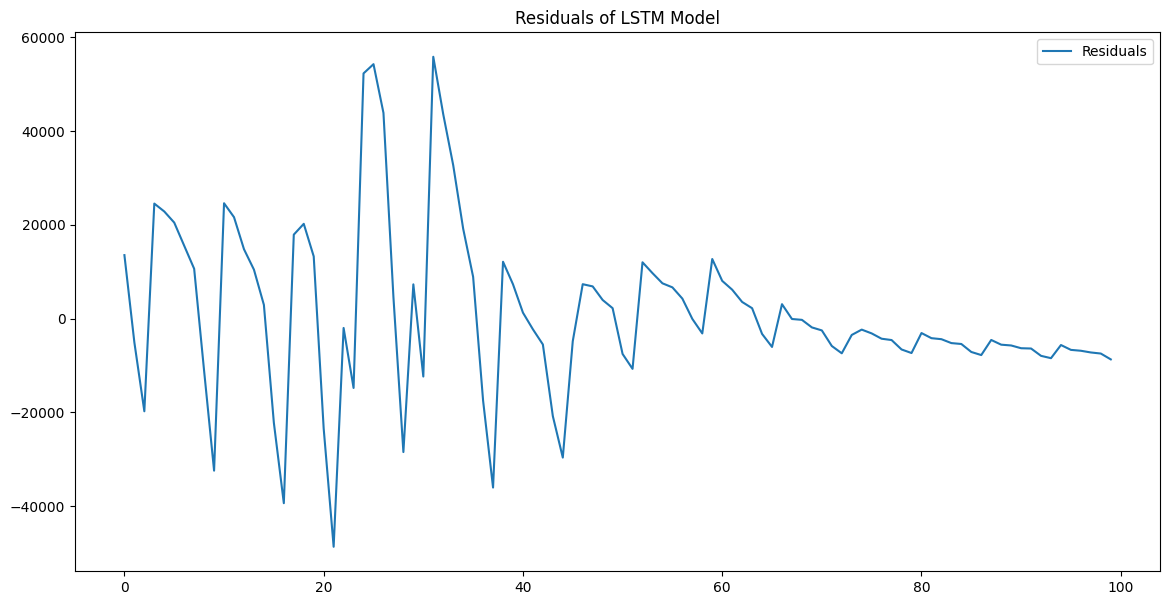

       lb_stat     lb_pvalue
10  109.211816  7.692908e-19


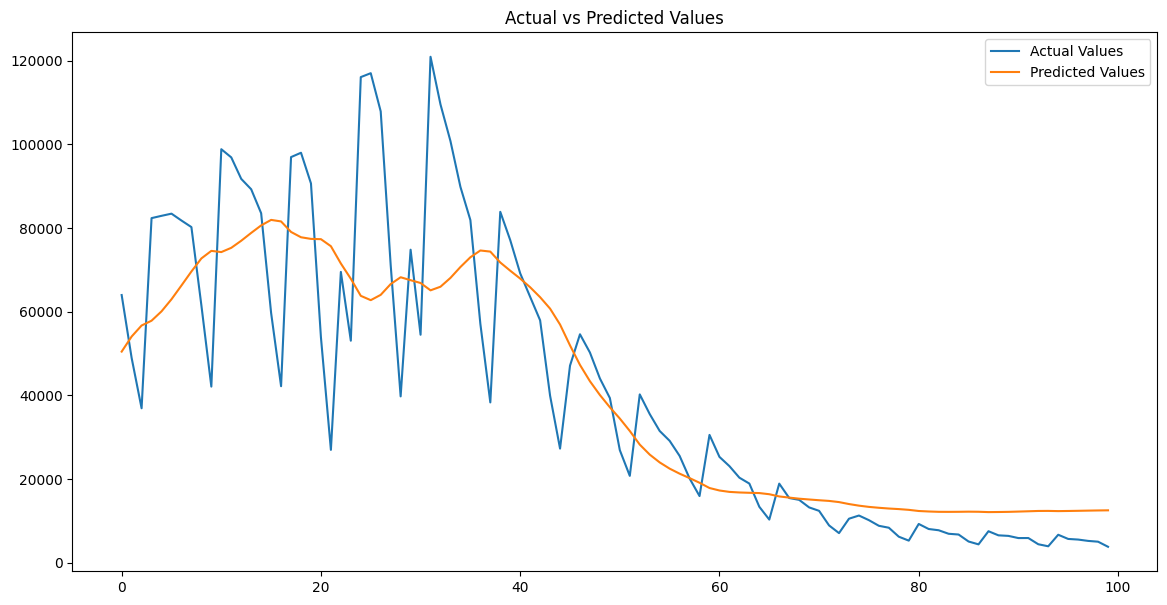

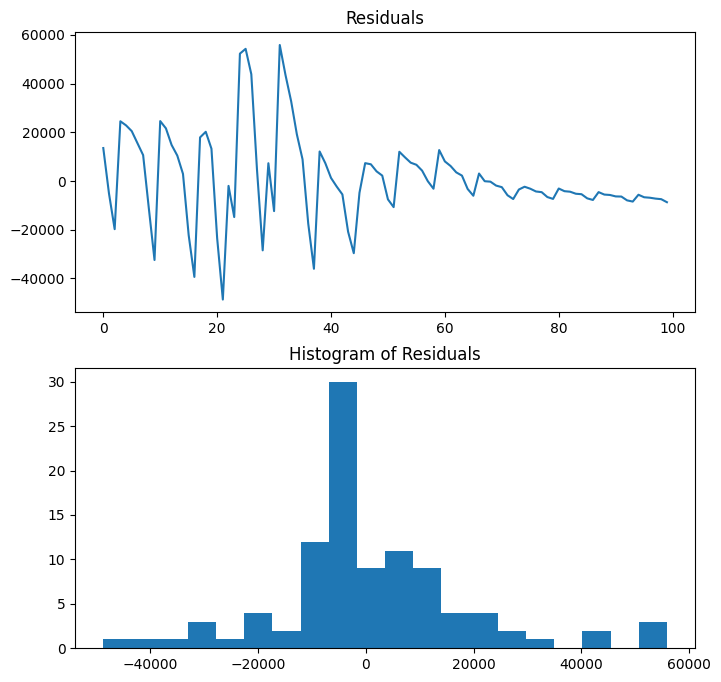

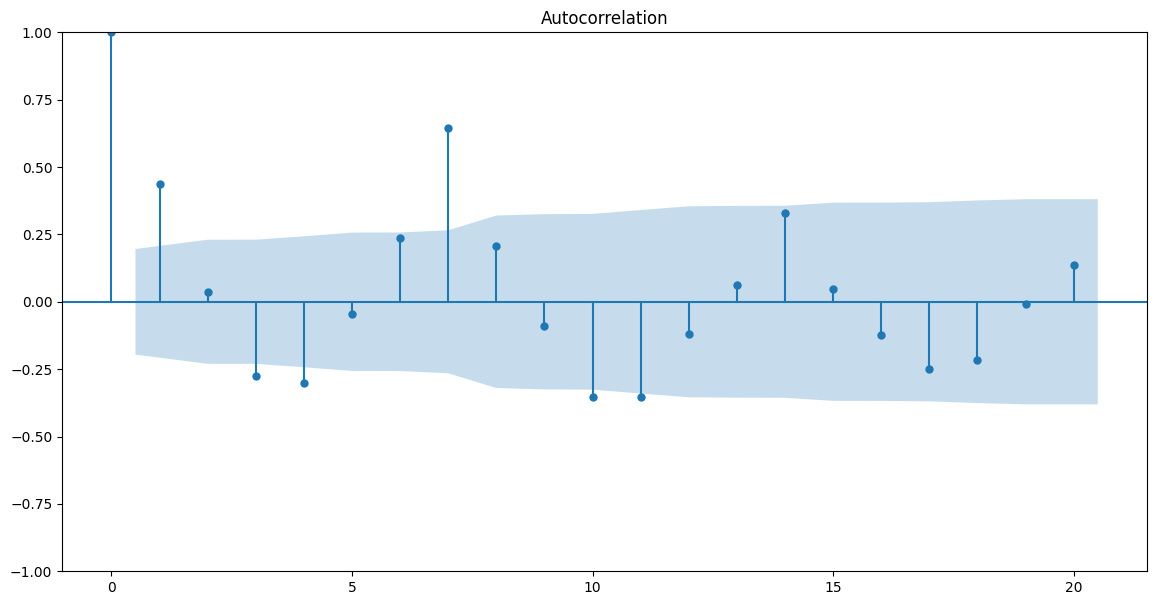

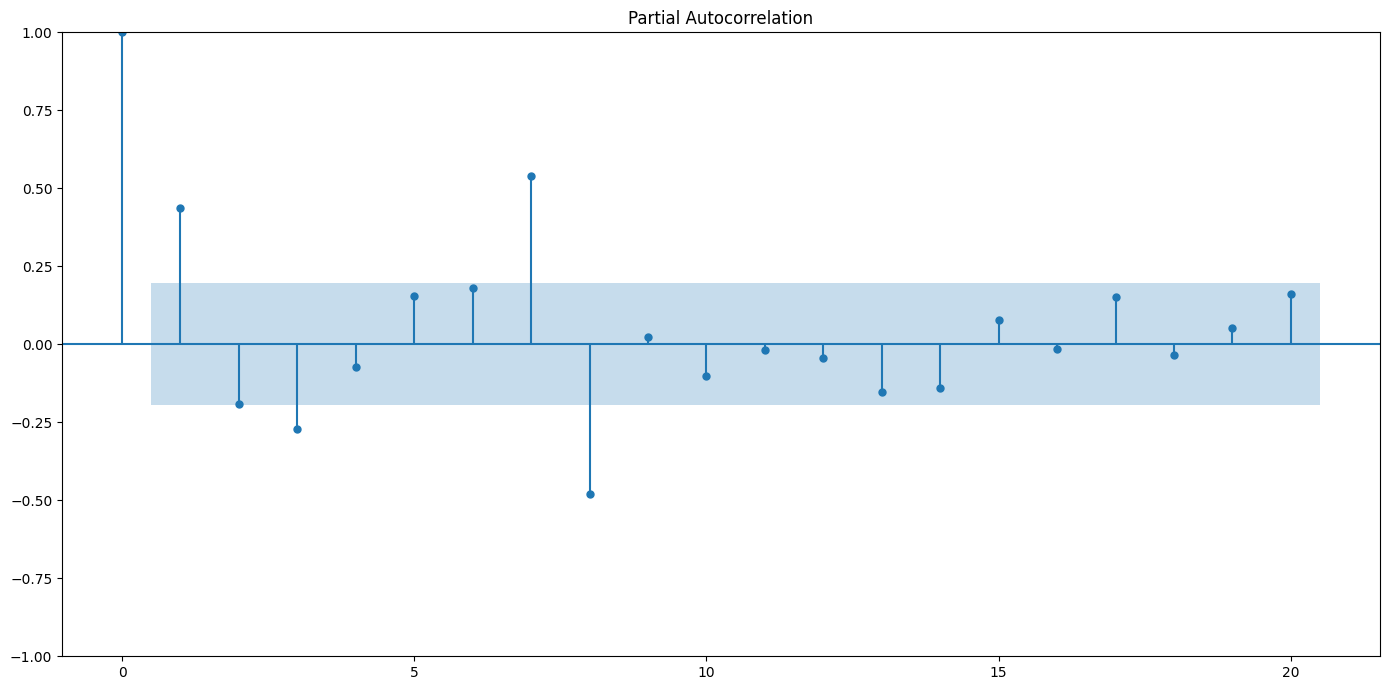

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -2542.283
Date:                Thu, 13 Jun 2024   AIC                           5106.566
Time:                        15:54:05   BIC                           5143.011
Sample:                             0   HQIC                          5121.310
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.758e+04   8.98e+04      0.530      0.596   -1.28e+05    2.24e+05
x1            55.7477     21.022      2.652      0.008      14.546      96.949
ar.L1          1.0796      0.682      1.583      0.1

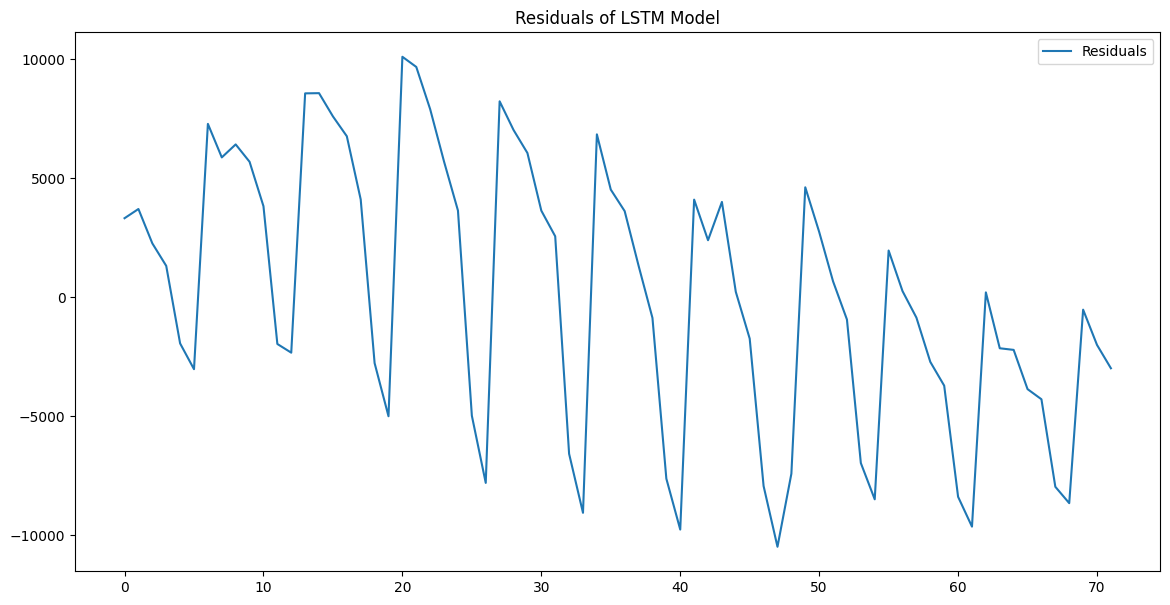

       lb_stat     lb_pvalue
10  115.978834  3.304964e-20


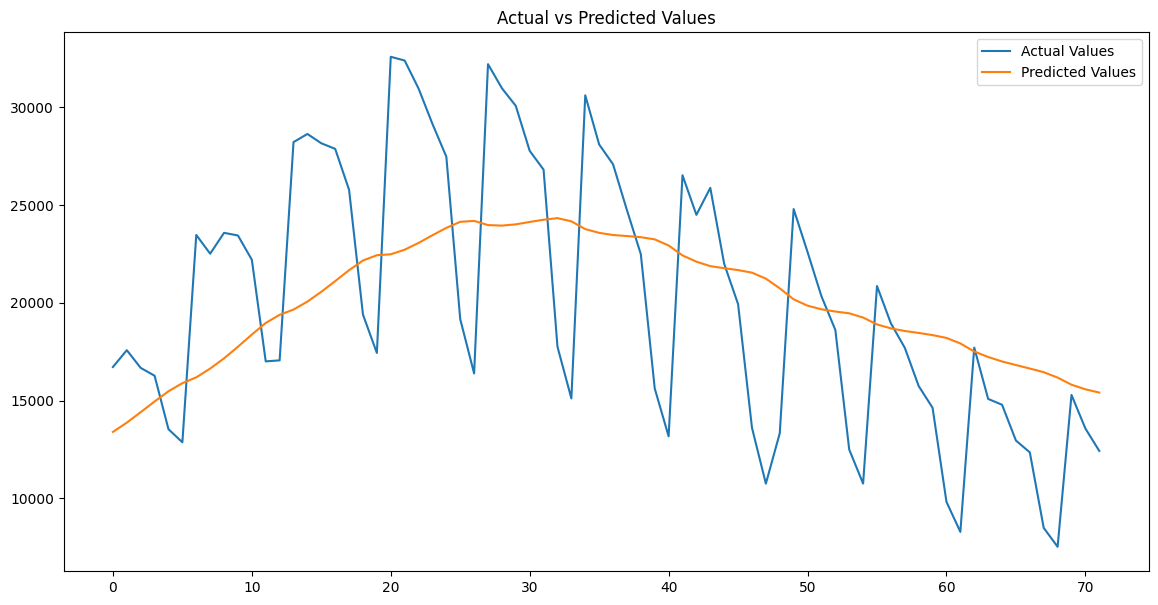

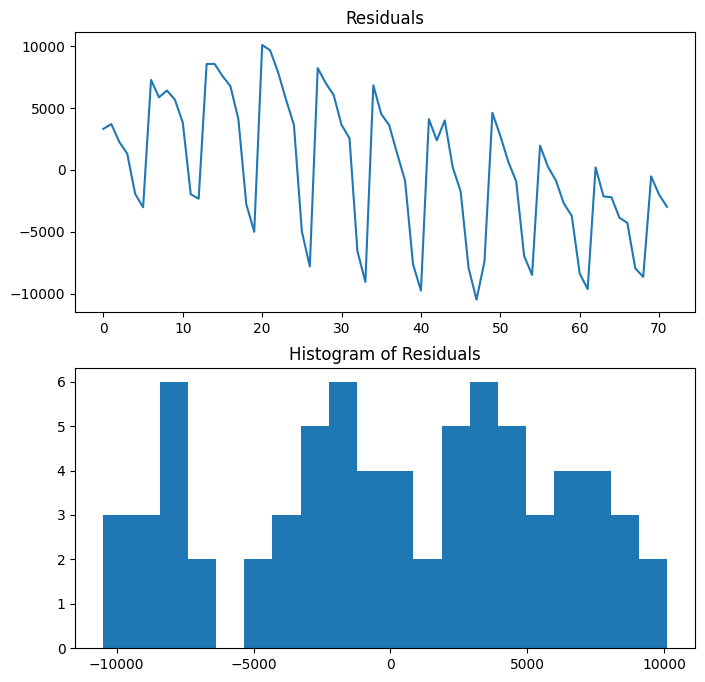

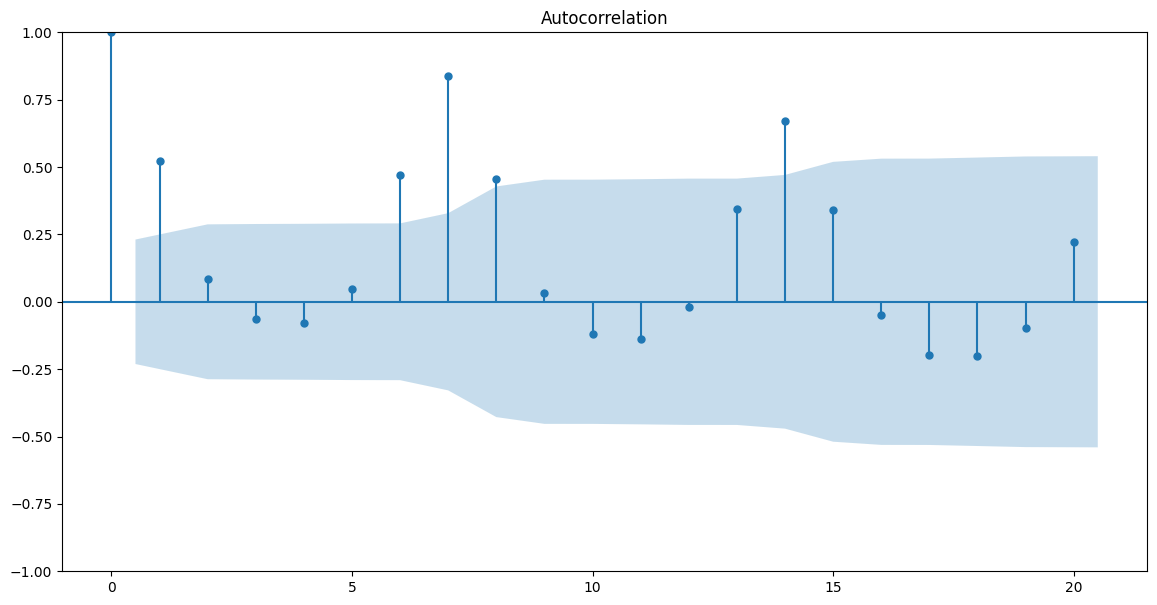

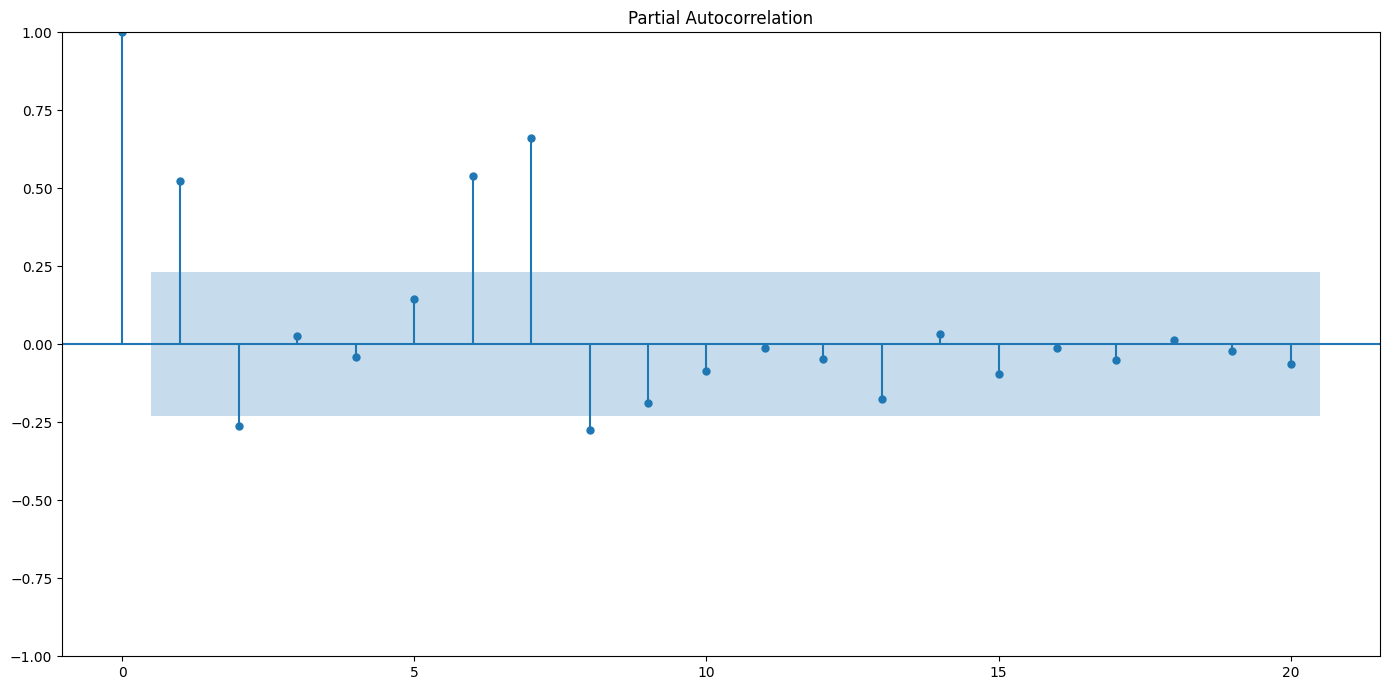

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -2542.283
Date:                Thu, 13 Jun 2024   AIC                           5106.566
Time:                        15:54:10   BIC                           5143.011
Sample:                             0   HQIC                          5121.310
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.758e+04   8.98e+04      0.530      0.596   -1.28e+05    2.24e+05
x1            55.7477     21.022      2.652      0.008      14.546      96.949
ar.L1          1.0796      0.682      1.583      0.1

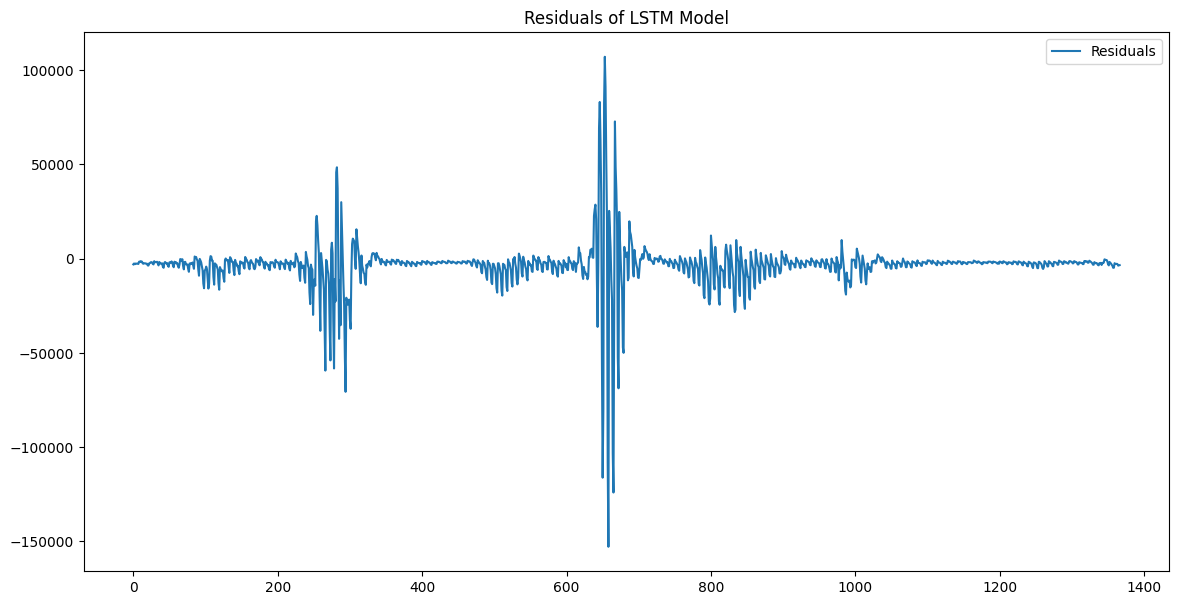

        lb_stat  lb_pvalue
10  1916.910169        0.0


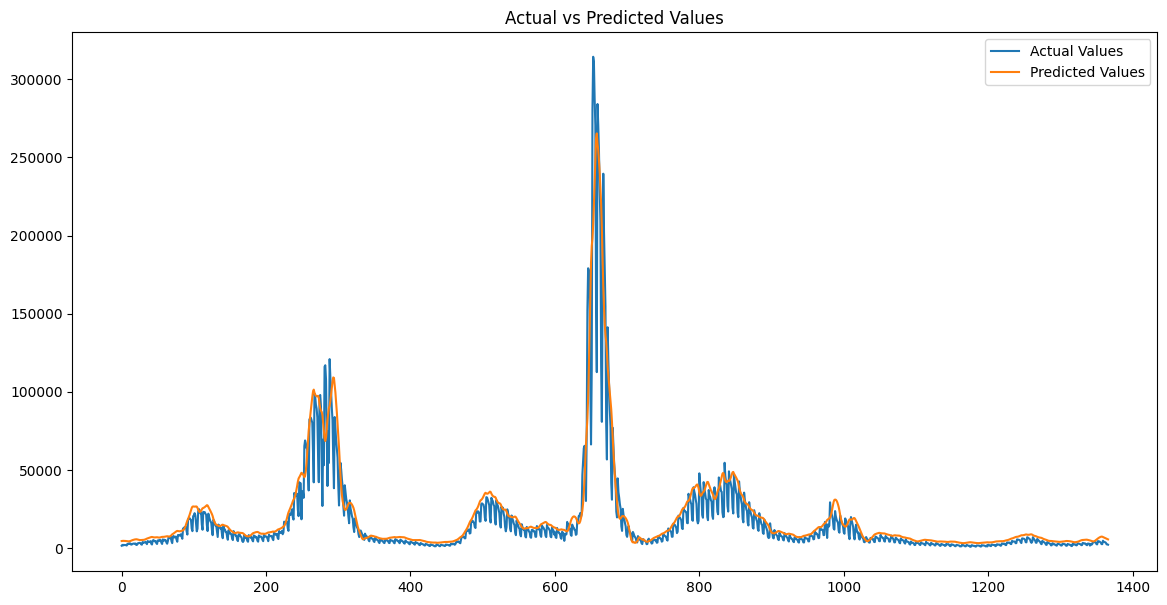

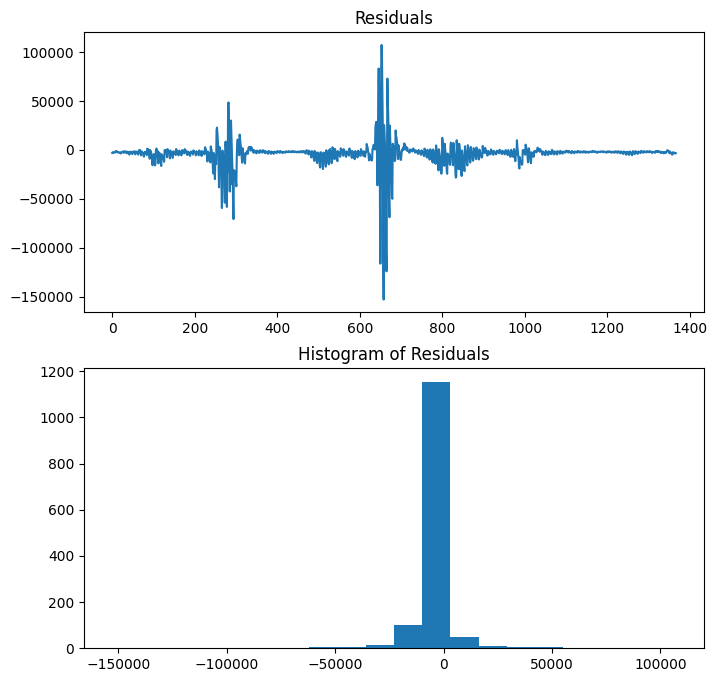

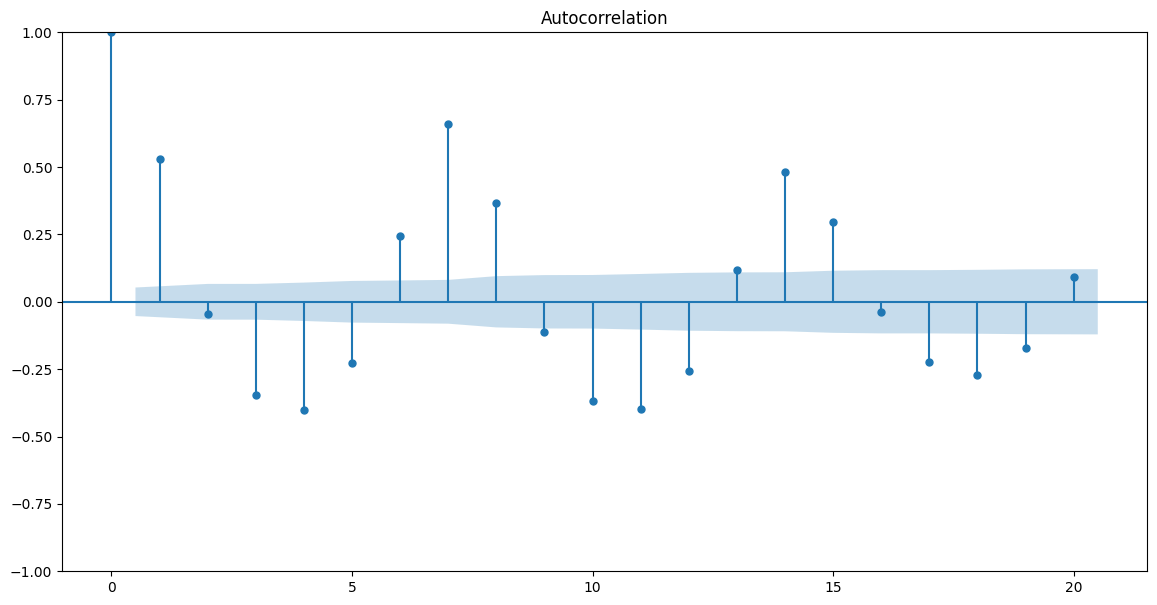

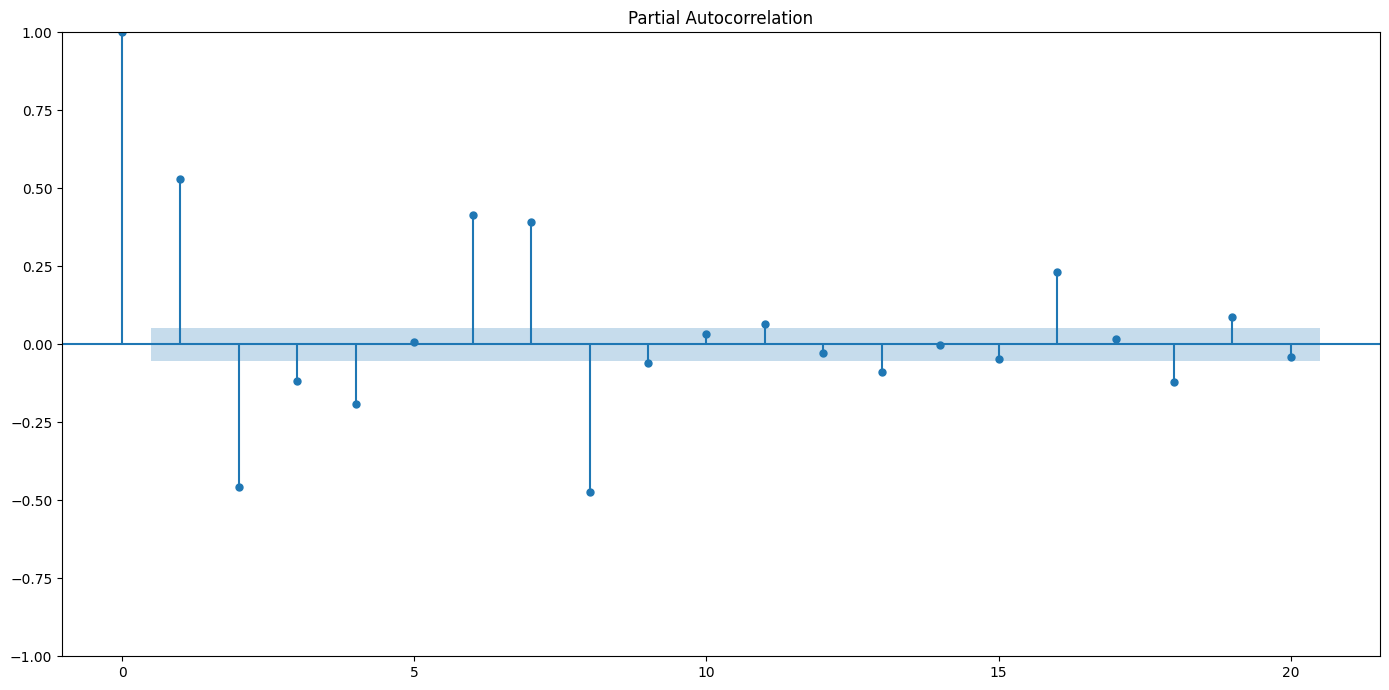

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -2542.283
Date:                Thu, 13 Jun 2024   AIC                           5106.566
Time:                        15:54:24   BIC                           5143.011
Sample:                             0   HQIC                          5121.310
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.758e+04   8.98e+04      0.530      0.596   -1.28e+05    2.24e+05
x1            55.7477     21.022      2.652      0.008      14.546      96.949
ar.L1          1.0796      0.682      1.583      0.1

In [485]:
splits = [
    (np.where(dates == '2020-03-26')[0][0], np.where(dates == '2020-08-16')[0][0]),
    (np.where(dates == '2020-10-15')[0][0], np.where(dates == '2021-03-14')[0][0]),
    (np.where(dates == '2021-05-31')[0][0], np.where(dates == '2021-09-30')[0][0]),
    (0, -1)
]

best_models = []
for start, end in splits:
    print(start, end)
    model= test_lstm(added_data["Confirmed"][start:end])
    best_models.append(model)

print(best_models)

48 191
Epoch 1/20
3/3 [==============================] - 2s 251ms/step - loss: 0.2866 - val_loss: 0.1552
Epoch 2/20
3/3 [==============================] - 0s 24ms/step - loss: 0.1074 - val_loss: 0.0223
Epoch 3/20
3/3 [==============================] - 0s 23ms/step - loss: 0.0137 - val_loss: 0.5457
Epoch 4/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0738 - val_loss: 0.3487
Epoch 5/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0298 - val_loss: 0.0687
Epoch 6/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0099 - val_loss: 0.0119
Epoch 7/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0151 - val_loss: 0.0059
Epoch 8/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0183 - val_loss: 0.0063
Epoch 9/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0167 - val_loss: 0.0128
Epoch 10/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0121 - val_loss: 0.0341
Epoch 11/20
3/3 [====

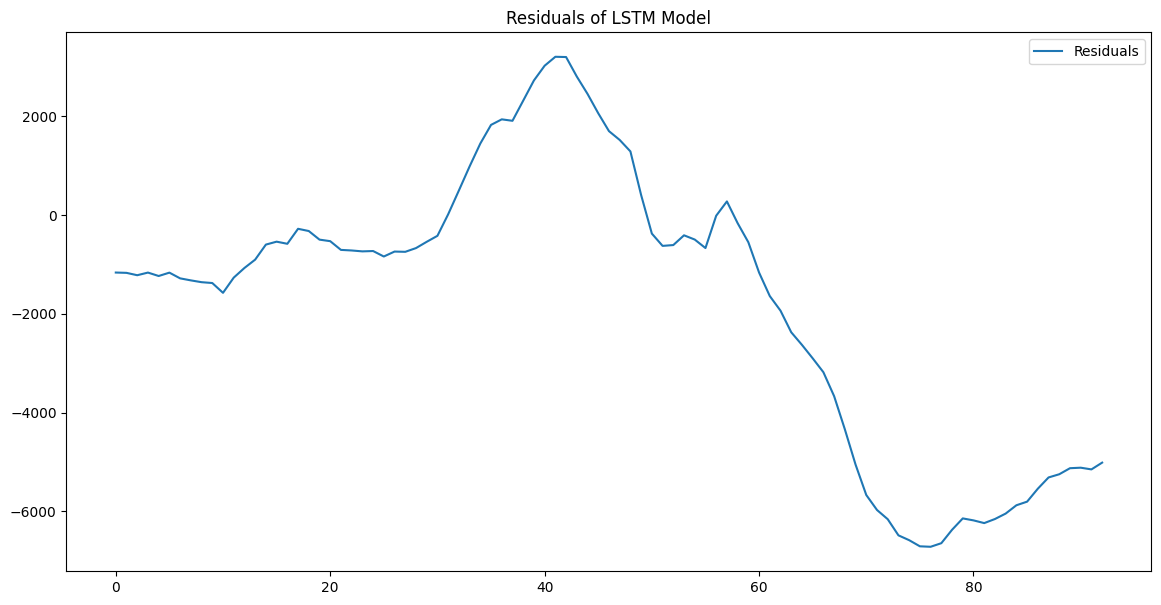

       lb_stat      lb_pvalue
10  711.328665  2.321619e-146


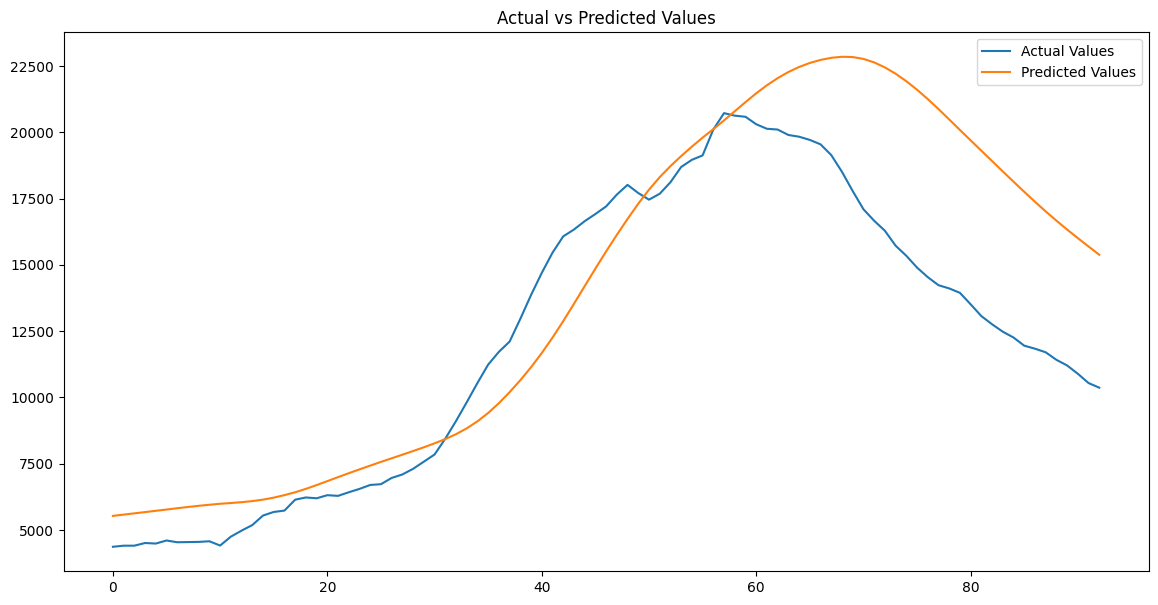

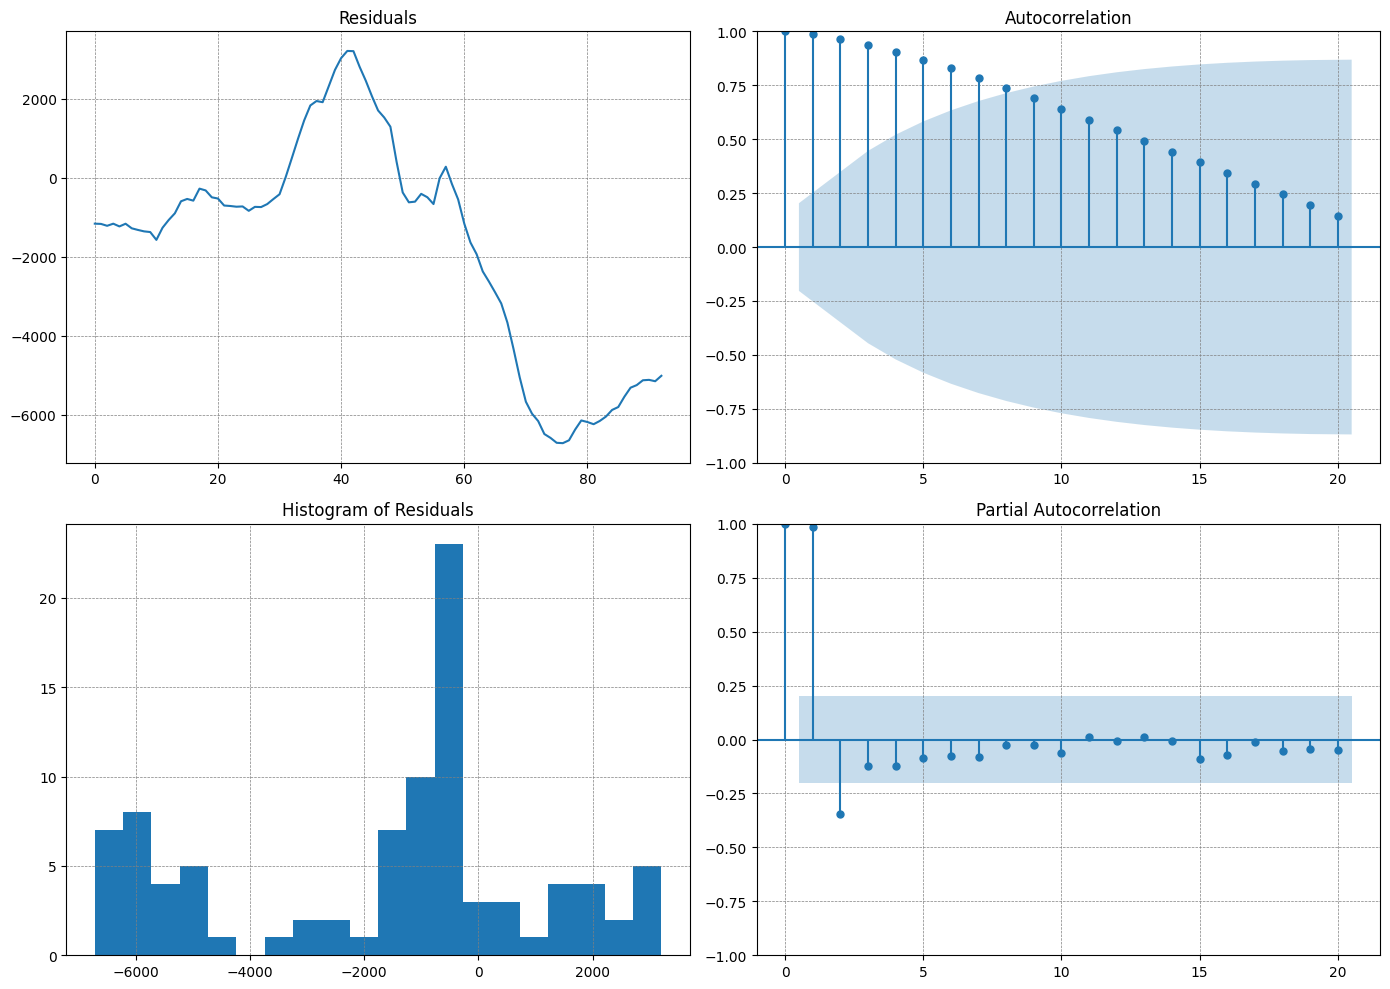

251 401
Epoch 1/20
3/3 [==============================] - 2s 244ms/step - loss: 0.4128 - val_loss: 5.3119e-04
Epoch 2/20
3/3 [==============================] - 0s 24ms/step - loss: 0.2225 - val_loss: 0.0232
Epoch 3/20
3/3 [==============================] - 0s 25ms/step - loss: 0.0771 - val_loss: 0.1476
Epoch 4/20
3/3 [==============================] - 0s 24ms/step - loss: 0.1111 - val_loss: 0.1233
Epoch 5/20
3/3 [==============================] - 0s 23ms/step - loss: 0.0713 - val_loss: 0.0539
Epoch 6/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0488 - val_loss: 0.0312
Epoch 7/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0575 - val_loss: 0.0259
Epoch 8/20
3/3 [==============================] - 0s 24ms/step - loss: 0.0591 - val_loss: 0.0288
Epoch 9/20
3/3 [==============================] - 0s 23ms/step - loss: 0.0505 - val_loss: 0.0376
Epoch 10/20
3/3 [==============================] - 0s 26ms/step - loss: 0.0397 - val_loss: 0.0516
Epoch 11/20
3/3 

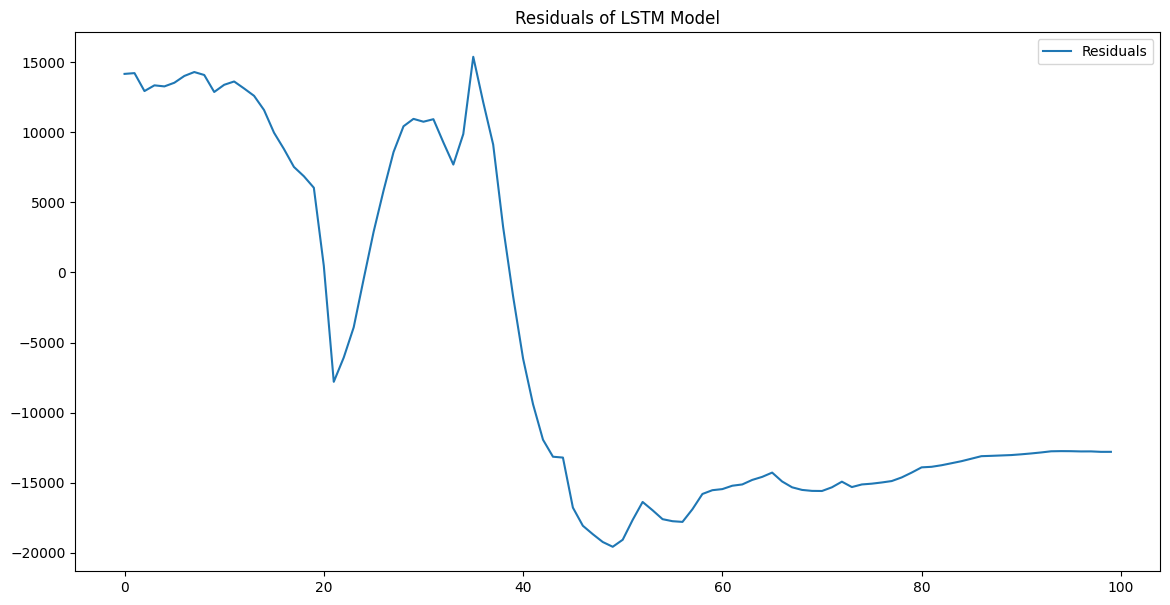

       lb_stat      lb_pvalue
10  651.289672  1.779759e-133


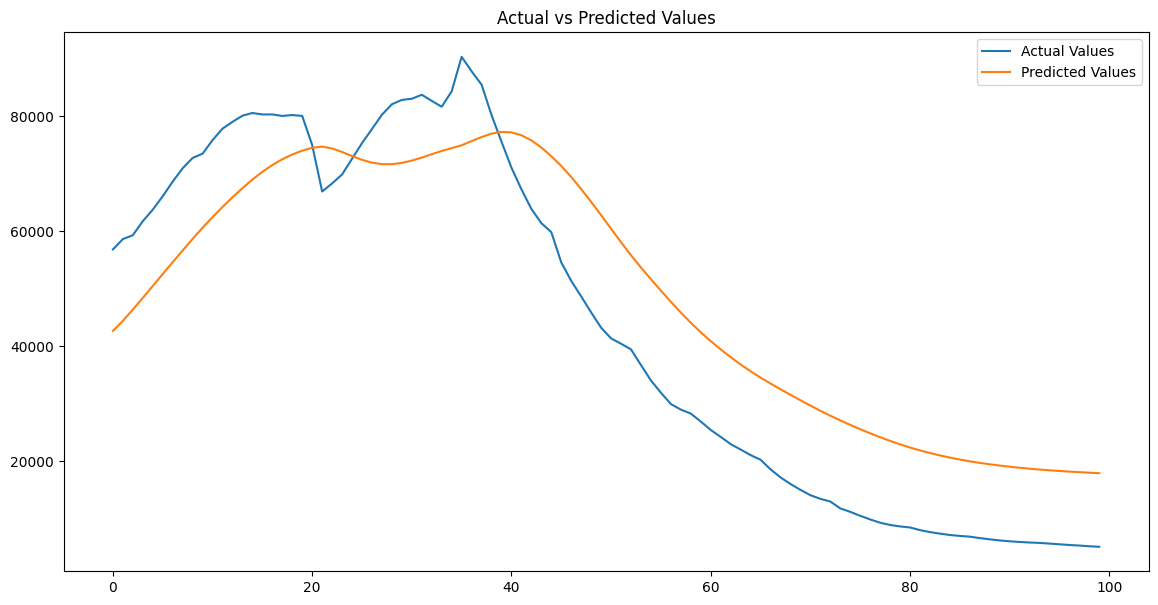

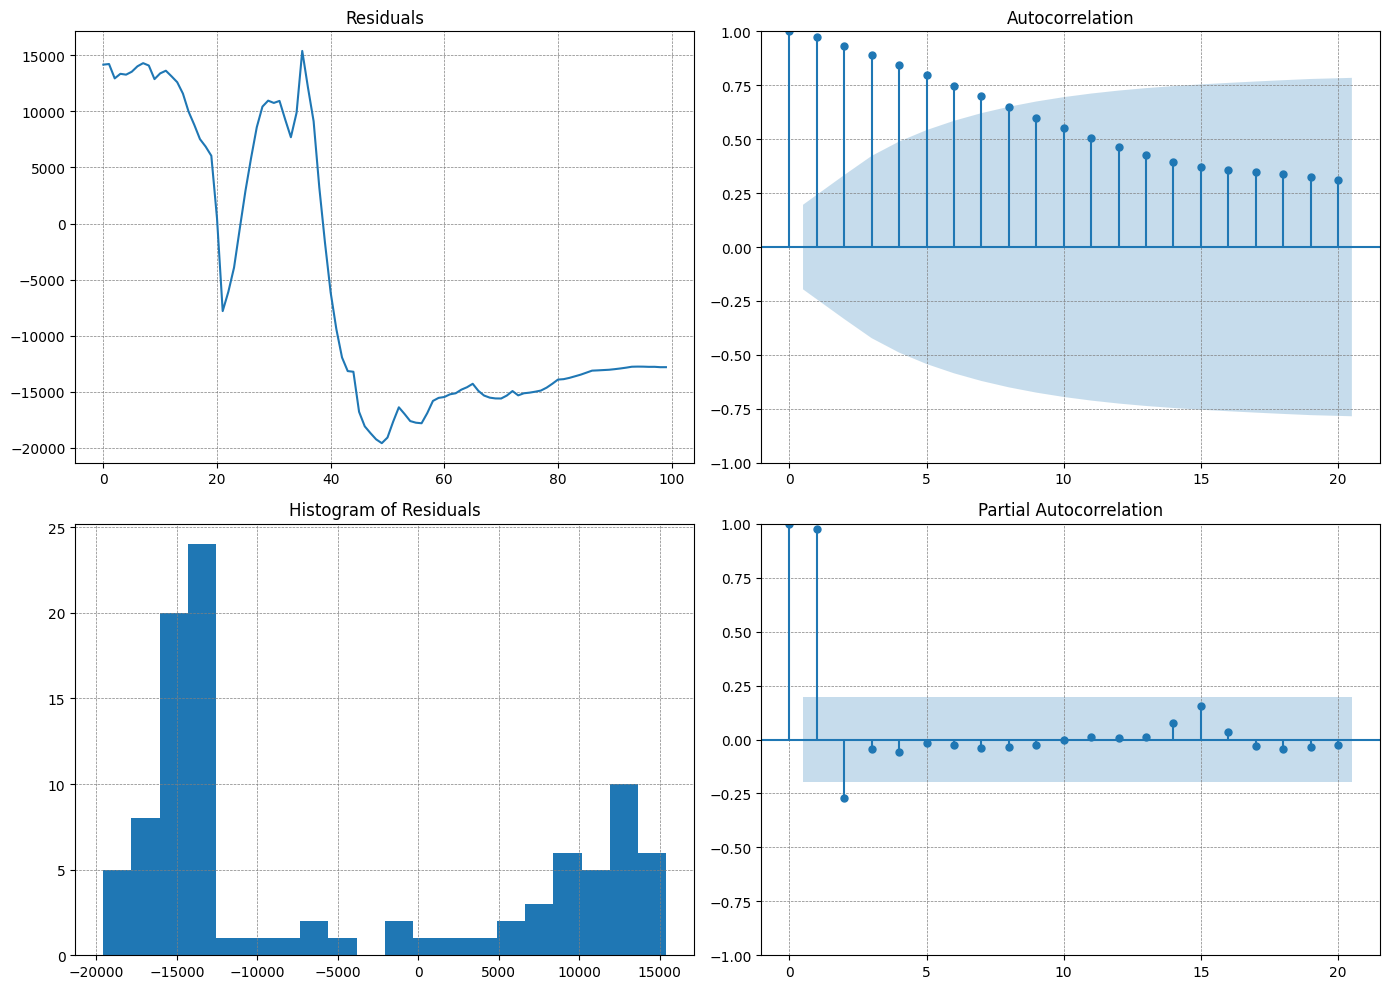

479 601
Epoch 1/20
2/2 [==============================] - 2s 467ms/step - loss: 0.7210 - val_loss: 0.2415
Epoch 2/20
2/2 [==============================] - 0s 35ms/step - loss: 0.4268 - val_loss: 0.0789
Epoch 3/20
2/2 [==============================] - 0s 33ms/step - loss: 0.2131 - val_loss: 0.0018
Epoch 4/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0702 - val_loss: 0.0725
Epoch 5/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0293 - val_loss: 0.2650
Epoch 6/20
2/2 [==============================] - 0s 35ms/step - loss: 0.0848 - val_loss: 0.2540
Epoch 7/20
2/2 [==============================] - 0s 36ms/step - loss: 0.0702 - val_loss: 0.1383
Epoch 8/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0342 - val_loss: 0.0517
Epoch 9/20
2/2 [==============================] - 0s 33ms/step - loss: 0.0156 - val_loss: 0.0162
Epoch 10/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0203 - val_loss: 0.0051
Epoch 11/20
2/2 [===

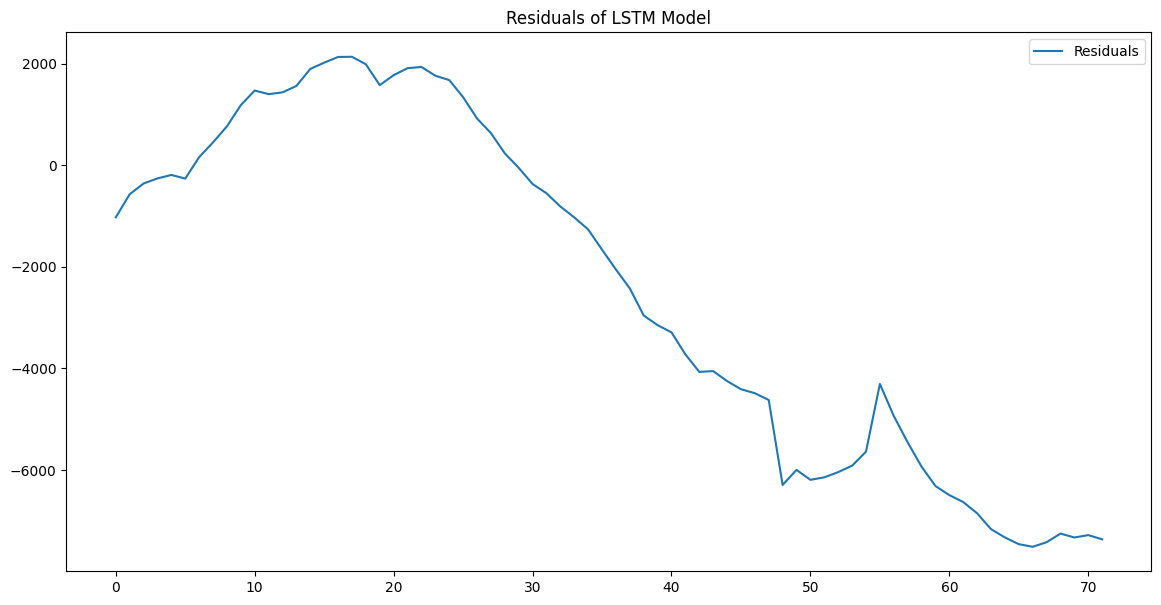

       lb_stat      lb_pvalue
10  556.798312  3.144166e-113


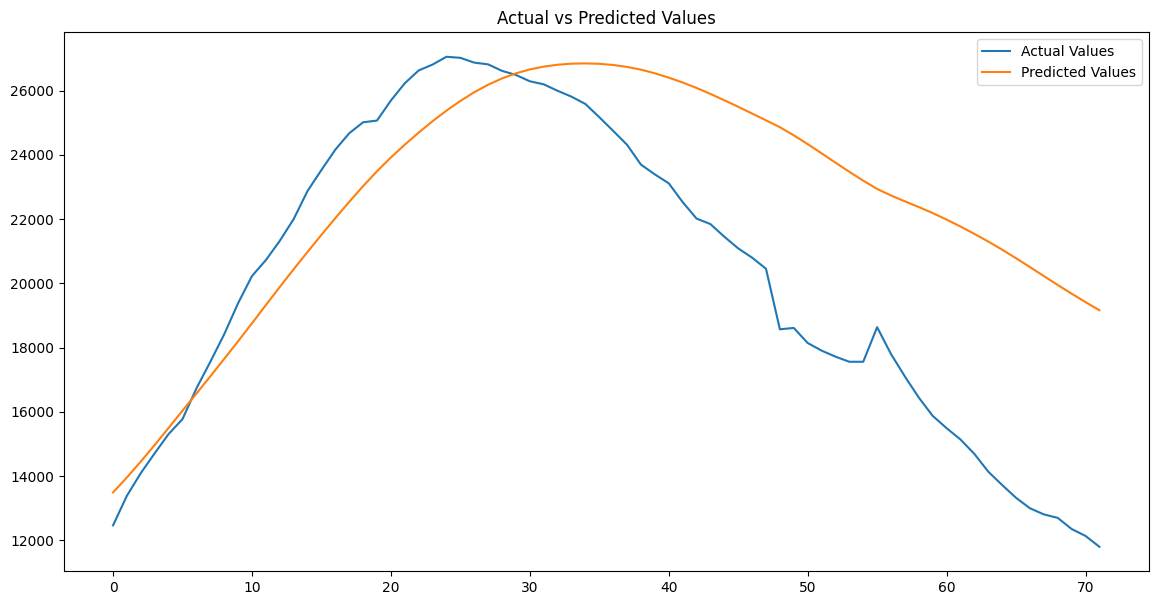

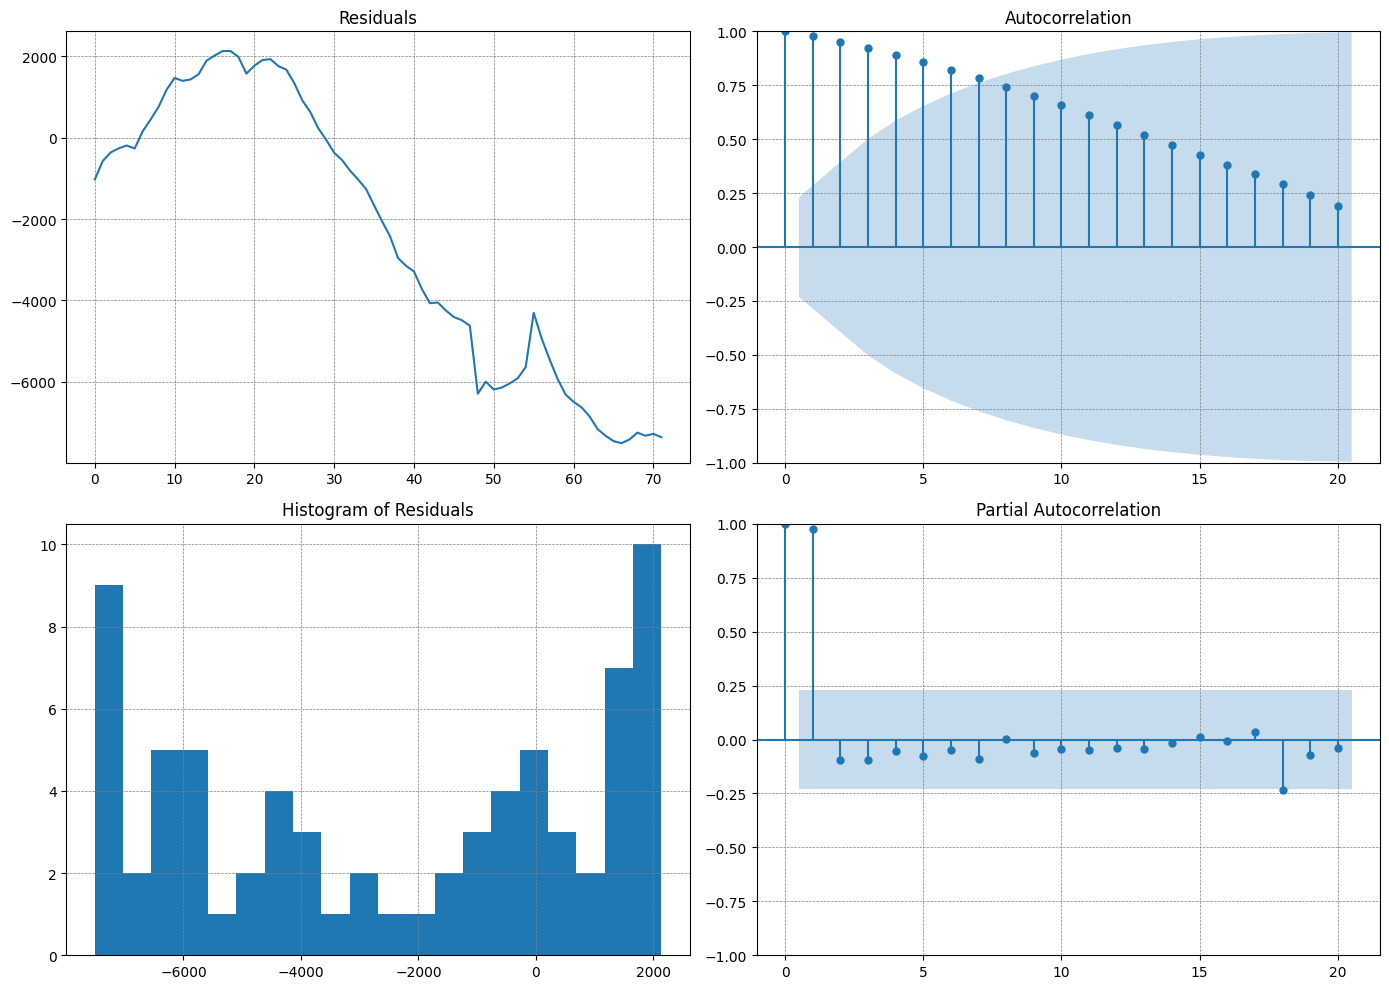

0 -1
Epoch 1/20
31/31 [==============================] - 3s 31ms/step - loss: 0.0078 - val_loss: 4.9873e-04
Epoch 2/20
31/31 [==============================] - 1s 16ms/step - loss: 0.0025 - val_loss: 3.4441e-04
Epoch 3/20
31/31 [==============================] - 0s 16ms/step - loss: 9.2245e-04 - val_loss: 4.3287e-05
Epoch 4/20
31/31 [==============================] - 1s 17ms/step - loss: 7.4854e-04 - val_loss: 1.0459e-04
Epoch 5/20
31/31 [==============================] - 1s 17ms/step - loss: 6.2434e-04 - val_loss: 1.7717e-04
Epoch 6/20
31/31 [==============================] - 0s 16ms/step - loss: 4.7672e-04 - val_loss: 8.2324e-05
Epoch 7/20
31/31 [==============================] - 0s 16ms/step - loss: 3.9157e-04 - val_loss: 8.1910e-05
Epoch 8/20
31/31 [==============================] - 0s 16ms/step - loss: 3.9937e-04 - val_loss: 1.2848e-04
Epoch 9/20
31/31 [==============================] - 1s 17ms/step - loss: 4.0780e-04 - val_loss: 7.8849e-05
Epoch 10/20
31/31 [=====================

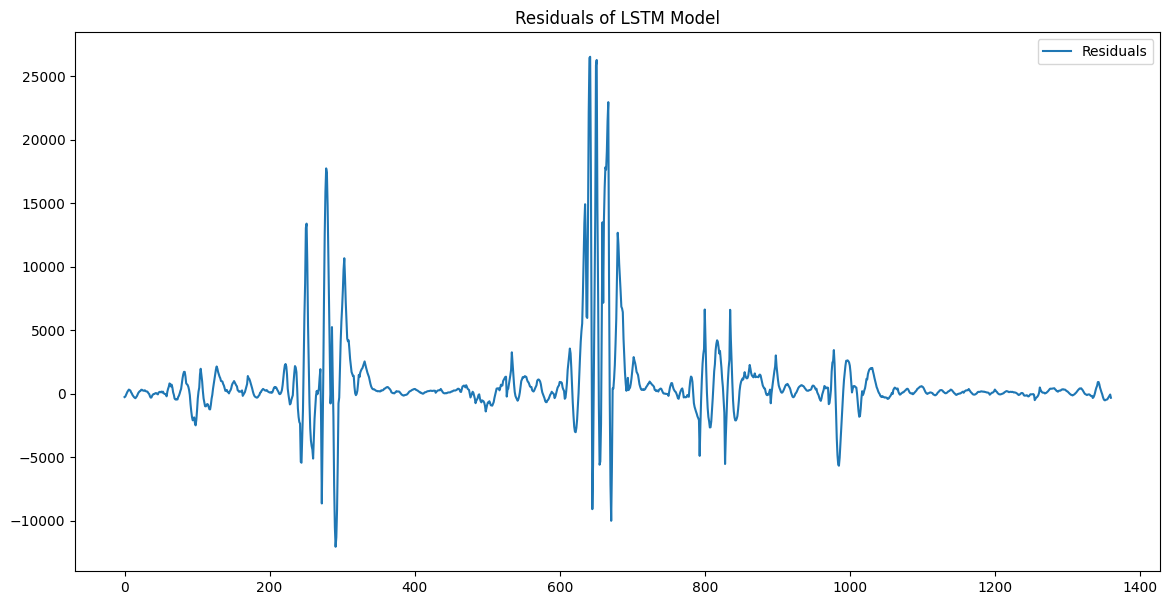

        lb_stat  lb_pvalue
10  2216.898062        0.0


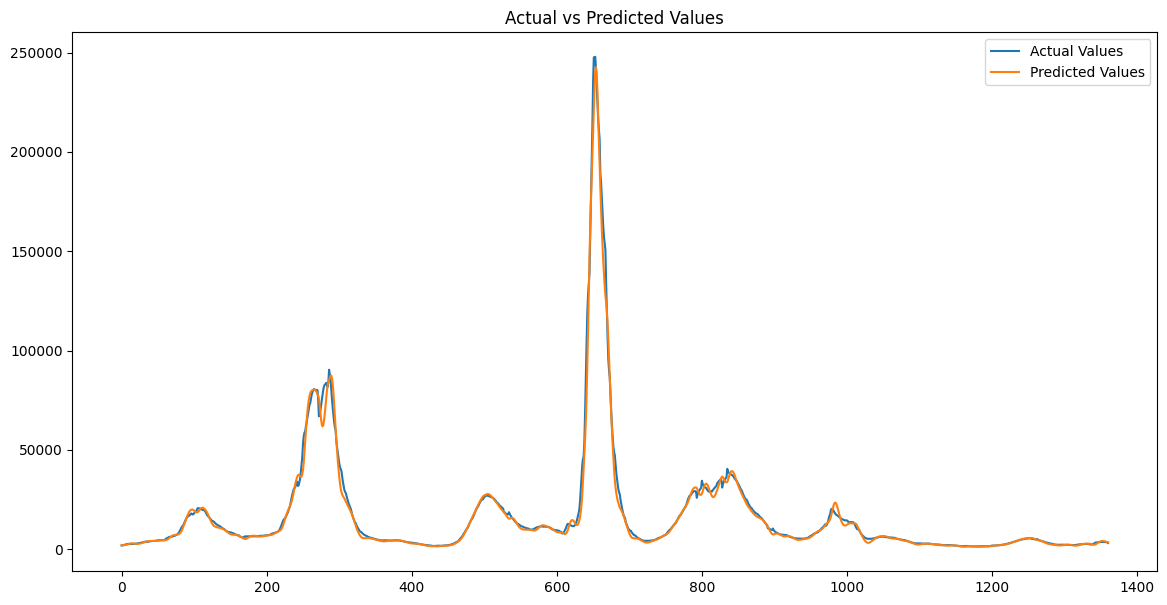

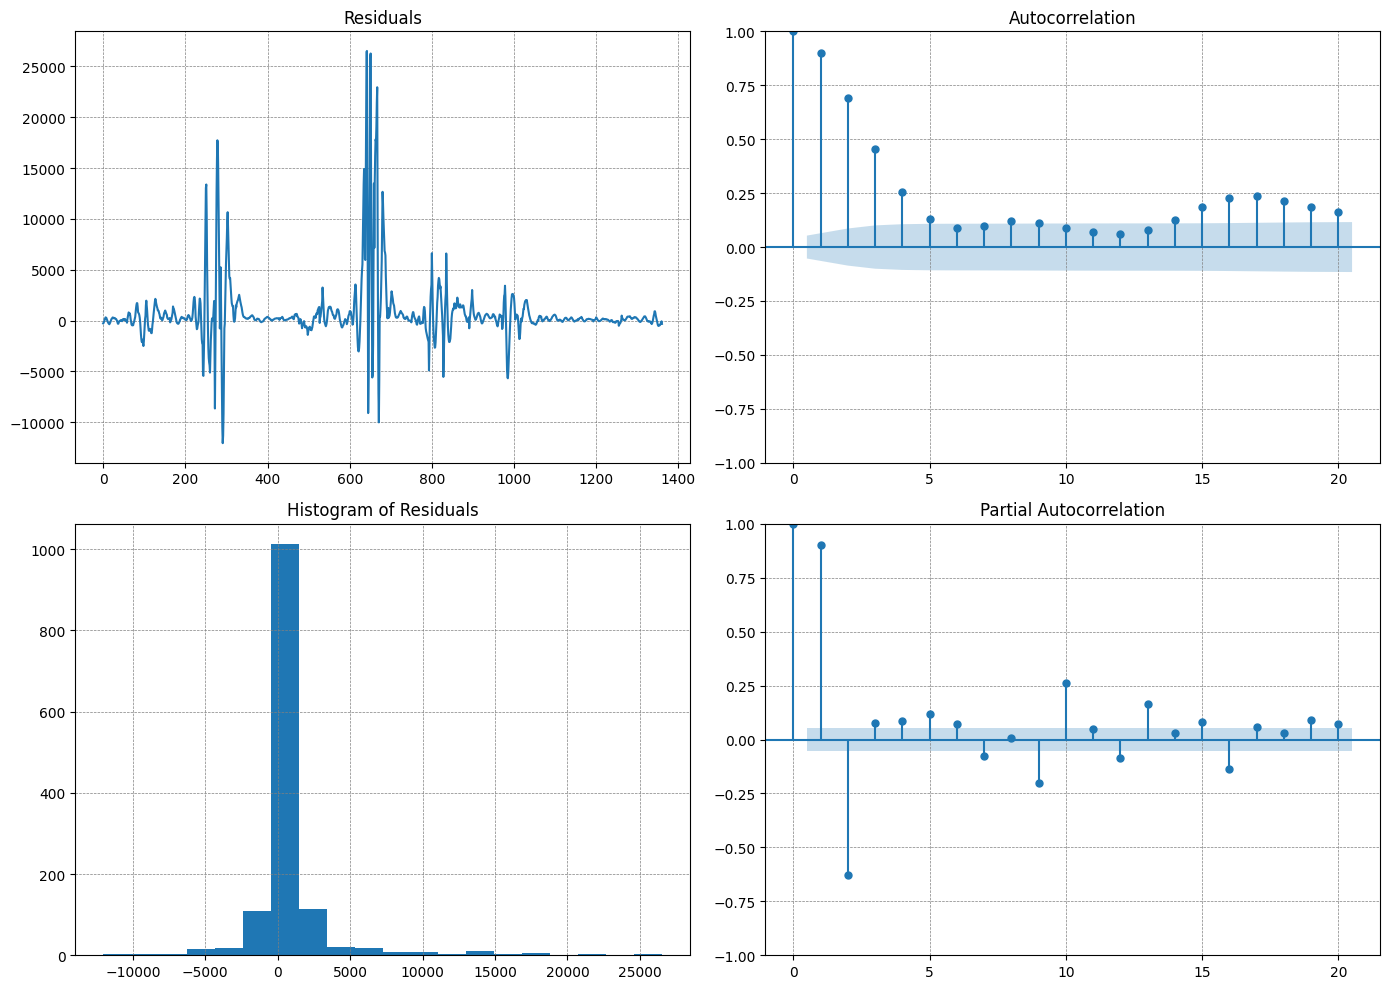

[<keras.engine.sequential.Sequential object at 0x0000024E7633EE90>, <keras.engine.sequential.Sequential object at 0x0000024E76F01180>, <keras.engine.sequential.Sequential object at 0x0000024E759DA410>, <keras.engine.sequential.Sequential object at 0x0000024E759D97E0>]


In [82]:
daily_data = pd.DataFrame(added_data, index=pd.to_datetime(dates))
weekly_data = daily_data.rolling(window=7).mean()
weekly_data = weekly_data.dropna()
weekly_dates = dates[np.where(dates == "2020-02-07")[0][0]:]
splits = [
    (np.where(weekly_dates == '2020-03-26')[0][0], np.where(weekly_dates == '2020-08-16')[0][0]),
    (np.where(weekly_dates == '2020-10-15')[0][0], np.where(weekly_dates == '2021-03-14')[0][0]),
    (np.where(weekly_dates == '2021-05-31')[0][0], np.where(weekly_dates == '2021-09-30')[0][0]),
    (0, -1)
]
best_models = []
for start, end in splits:
    print(start, end)
    model= test_lstm(weekly_data["Confirmed"].values[start:end])
    best_models.append(model)

print(best_models)